## Import Libraries

In [2]:
#-------- data manipulation --------
import pandas as pd
import sqlite3
import numpy as np
from collections import deque

#------- time manipulation ---------
import time

#------ finance indicators ---------

#---------- visualization ----------
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
import matplotlib.gridspec as gridspec
import plotly.graph_objects as go

#-------- basic statistics ---------
import scipy.stats as stats
from scipy.stats import skew, kurtosis
from statsmodels.stats.diagnostic import normal_ad

#----- time series analysis --------
from statsmodels.tsa.api import VAR
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.tsa.stattools as sts
from arch import arch_model

#------ os manipulation -----------
import os

## Function to read data from SQLite

In [4]:
def load_ohlcv_from_sqlite(table_name: str, db_path: str, start: str = None, end: str = None) -> pd.DataFrame:
    """
    Loads OHLCV data from a SQLite database table for backtesting.

    Parameters:
    - table_name: str, name of the table (e.g., 'btc_1h')
    - db_path: str, path to the SQLite database
    - start: str (optional), start timestamp in 'YYYY-MM-DD' or 'YYYY-MM-DD HH:MM:SS'
    - end: str (optional), end timestamp in 'YYYY-MM-DD' or 'YYYY-MM-DD HH:MM:SS'

    Returns:
    - DataFrame with datetime index and OHLCV columns
    """
    query = f"SELECT * FROM {table_name}"
    if start and end:
        query += f" WHERE timestamp BETWEEN '{start}' AND '{end}'"
    elif start:
        query += f" WHERE timestamp >= '{start}'"
    elif end:
        query += f" WHERE timestamp <= '{end}'"

    with sqlite3.connect(db_path) as conn:
        df = pd.read_sql(query, conn, parse_dates=["timestamp"])
    
    df.set_index("timestamp", inplace=True)
    df = df.sort_index()
    return df

# Example usage (commented, to be used interactively):
# btc_df = load_ohlcv_from_sqlite("btc_1h", "/mnt/data/crypto_data.sqlite", start="2024-01-01", end="2025-01-01")


## 1. Get data

In [5]:
db_path = "data/crypto_data.sqlite"

In [6]:
btc = load_ohlcv_from_sqlite(
    table_name="btc_1h", 
    db_path=db_path, 
    start="2022-12-30", 
    end="2025-06-29"
)

In [7]:
print(btc.head())

                               open      high       low     close      volume
timestamp                                                                    
2022-12-31 18:00:00-06:00  16541.77  16545.70  16508.39  16529.67  4364.83570
2022-12-31 19:00:00-06:00  16529.59  16556.80  16525.78  16551.47  3590.06669
2022-12-31 20:00:00-06:00  16551.47  16559.77  16538.14  16548.19  3318.84038
2022-12-31 21:00:00-06:00  16548.19  16548.19  16518.21  16533.04  4242.08050
2022-12-31 22:00:00-06:00  16533.04  16535.97  16511.92  16521.85  4285.00909


## 2. Iterative function

In [8]:
def simulate_market(df, delay=0.5):
    for i in range(1, len(df)):
        yield df.iloc[:i+1]  # yields growing slices
        time.sleep(delay)

In [9]:
btc.columns

Index(['open', 'high', 'low', 'close', 'volume'], dtype='object')

In [10]:
btc_test = btc.copy()

In [11]:
btc_test.head(3)

,open,high,low,close,volume
timestamp,,,,,
2022-12-31 18:00:00-06:00,16541.77,16545.70,16508.39,16529.67,4364.83570
2022-12-31 19:00:00-06:00,16529.59,16556.80,16525.78,16551.47,3590.06669
2022-12-31 20:00:00-06:00,16551.47,16559.77,16538.14,16548.19,3318.84038


In [12]:
btc_test["cummax"] = btc_test.close.cummax()

# Create an empty support column
btc_test['custom_support'] = None

# Initialize first support as the first close
prev_support = btc_test['close'].iloc[0]

# Iterate row by row
for i in range(len(btc_test)):
    current_price = btc_test['close'].iloc[i]

    if current_price < prev_support:
        # Only update if the new price is lower than previous support
        prev_support = current_price

    btc_test.iloc[i, btc_test.columns.get_loc('custom_support')] = prev_support


btc_test

,open,high,low,close,volume,cummax,custom_support
timestamp,,,,,,,
2022-12-31 18:00:00-06:00,16541.77,16545.70,16508.39,16529.67,4364.83570,16529.67,16529.67
2022-12-31 19:00:00-06:00,16529.59,16556.80,16525.78,16551.47,3590.06669,16551.47,16529.67
2022-12-31 20:00:00-06:00,16551.47,16559.77,16538.14,16548.19,3318.84038,16551.47,16529.67
2022-12-31 21:00:00-06:00,16548.19,16548.19,16518.21,16533.04,4242.08050,16551.47,16529.67
2022-12-31 22:00:00-06:00,16533.04,16535.97,16511.92,16521.85,4285.00909,16551.47,16521.85
...,...,...,...,...,...,...,...
2025-06-28 14:00:00-06:00,107225.74,107235.40,107154.62,107169.52,80.40679,111780.84,16513.34
2025-06-28 15:00:00-06:00,107169.52,107347.65,107169.52,107331.38,82.17435,111780.84,16513.34
2025-06-28 16:00:00-06:00,107331.37,107378.37,107257.09,107370.61,141.59714,111780.84,16513.34


[]

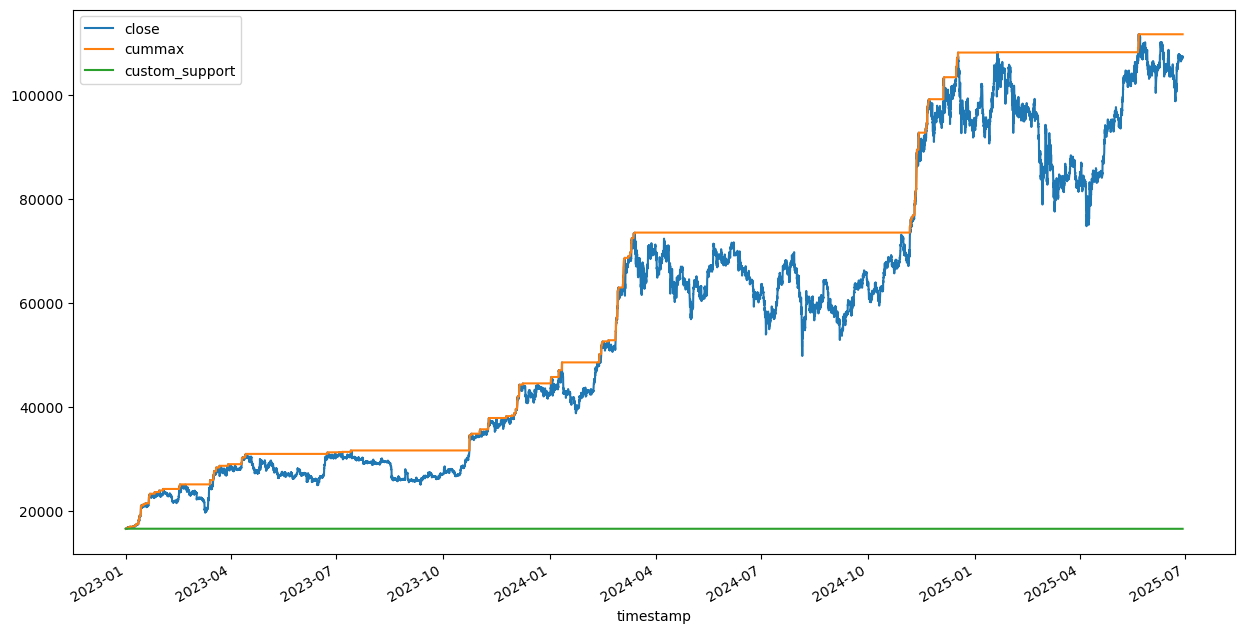

In [13]:
btc_test[["close", "cummax", "custom_support"]].plot(figsize=(15,8), fontsize=10)
plt.legend(fontsize=10)
plt.plot()

In [14]:
for n, row in enumerate(simulate_market(btc, delay=1), start=0):
    row = row.iloc[-1]

    print(f"n: {n} | time: {row.name} | O: {row['open']} | H: {row['high']} | "
          f"L: {row['low']} | C: {row['close']} | V: {row['volume']}")
    
    if n == 5:
        break

n: 0 | time: 2022-12-31 19:00:00-06:00 | O: 16529.59 | H: 16556.8 | L: 16525.78 | C: 16551.47 | V: 3590.06669
n: 1 | time: 2022-12-31 20:00:00-06:00 | O: 16551.47 | H: 16559.77 | L: 16538.14 | C: 16548.19 | V: 3318.84038
n: 2 | time: 2022-12-31 21:00:00-06:00 | O: 16548.19 | H: 16548.19 | L: 16518.21 | C: 16533.04 | V: 4242.0805
n: 3 | time: 2022-12-31 22:00:00-06:00 | O: 16533.04 | H: 16535.97 | L: 16511.92 | C: 16521.85 | V: 4285.00909
n: 4 | time: 2022-12-31 23:00:00-06:00 | O: 16522.22 | H: 16534.98 | L: 16512.3 | C: 16530.71 | V: 3717.37178
n: 5 | time: 2023-01-01 00:00:00-06:00 | O: 16530.71 | H: 16550.0 | L: 16528.81 | C: 16539.79 | V: 3344.90206


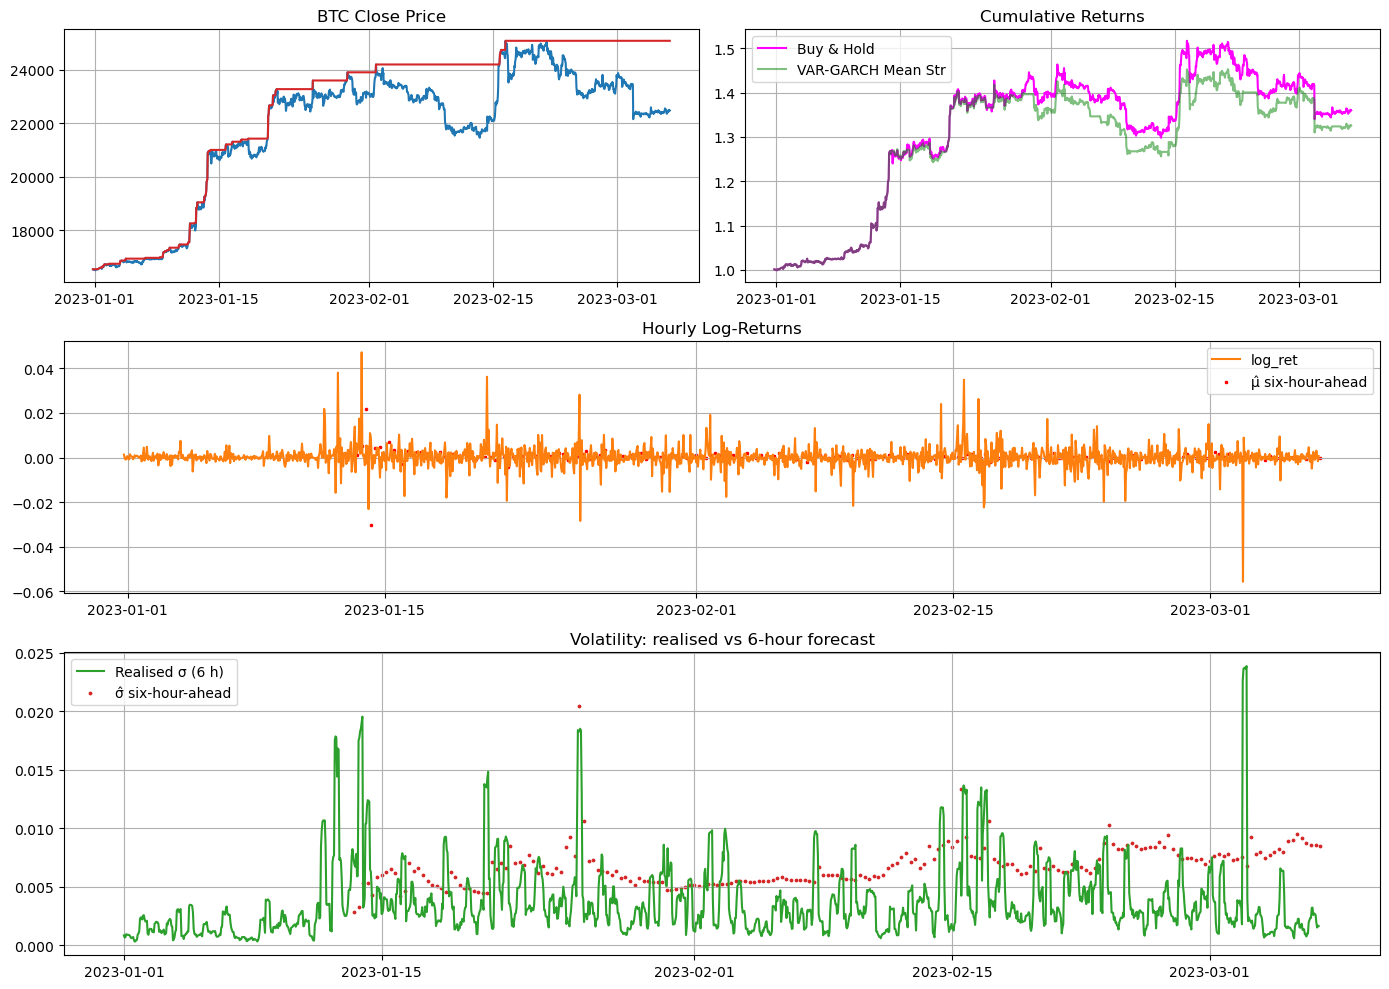

1564 | 2023-03-06 22:00:00-06:00 | Close 22,474.36 | log_ret -0.00347 | RV6h  0.00164 | μ̂(t+6h) nan | σ̂(t+6h) nan | position 1
Exit flag detected — stopping.


In [21]:
# ---------------- containers for plotting ---------------------------
ts_x, close_y, cummax_y, logret_y = [], [], [], []
realvol_y               = []

fcst_x, fcst_y          = [], []       # points drawn 6 h in the future

cstrategy_y, creturns_y       = [], []     # <-- will be filled now

# ----- new containers for mean forecasts -----
mean_fcst_x, mean_fcst_y = [], []     # time-stamps & values

# ---------------- container for permanent storage -------------------
results_log = []              # one dict = one row in final DF
decision_log = []
X_train = []                  # Train VAR model
position    = 1               # 1 = long ; 0 = flat
cum_asset   = 0.0             # cumulative *log* return of BTC
cum_strat   = 0.0             # cumulative *log* return of strategy

# -------------- MAIN BACKTEST LOOP (VAR-GARCH version) --------------
for n, partial_df  in enumerate(simulate_market(btc, delay=0.25), start=1):
    partial_df = partial_df.copy()
    # Current rows in partial_df:
    # index: timestamp
    # [0]: open
    # [1]: high
    # [2]: low
    # [3]: close
    # [4]: volume
    # added columns:
    partial_df['cummax'] = partial_df['close'].cummax()

    # ―――― 0. FIRST PARAMETERS ―――――――――――――――――――――――――――――――――――――
    latest   = partial_df.iloc[-1]        # last row
    tstamp = latest.name                  # current time
    prev_pos = position                   # yesterday’s stance

    first_row = latest[0]                 # first row to revert log changes


    # ―――― 1. CALCULATE LOG CHANGES TO TRAIN VAR ――――――――――――――――――――
    log_chg_open = np.log(partial_df['open'] / partial_df['open'].shift(1))
    log_chg_high = np.log(partial_df['high'] / partial_df['high'].shift(1)) 
    log_chg_low = np.log(partial_df['low'] / partial_df['low'].shift(1)) 
    log_chg_close = np.log(partial_df['close'] / partial_df['close'].shift(1))
    log_chg_volume = np.log(partial_df['volume'] / partial_df['volume'].shift(1))

    X_train.append(dict(
        timestamp = tstamp,
        open = log_chg_open.iloc[-1],
        high = log_chg_high.iloc[-1],
        low = log_chg_low.iloc[-1],
        close = log_chg_close.iloc[-1],
        volume = log_chg_volume.iloc[-1]
    ))

    # ―――― 2. RETURN ACCRUAL ―――――――――――――――――――――――――――――――――――――――
    cum_asset += log_chg_close.iloc[-1]
    cum_strat += prev_pos * log_chg_close.iloc[-1]
    creturns_y.append(np.exp(cum_asset))        # buy-&-hold equity curve
    cstrategy_y.append(np.exp(cum_strat))       # strategy equity curve


    # ―――― 3. REALISED VOL (6-h rolling σ of returns) ―――――――――――――――
    realised = log_chg_close.rolling(6).std().iloc[-1] if len(log_chg_close) >= 6 else np.nan

    # book-keeping for plots
    ts_x.append(tstamp);  close_y.append(latest.close)
    logret_y.append(log_chg_close.iloc[-1]);   realvol_y.append(realised)
    cummax_y.append(partial_df['cummax'].iloc[-1])

    # ---------- baseline row ---------------------------------
    results_log.append(dict(
        timestamp      = tstamp,
        close          = latest.close,
        log_ret        = log_chg_close.iloc[-1],
        realized_vol   = realised,
        forecasted_vol = np.nan,
        forecasted_mu  = np.nan,
        position       = position,        
        cum_asset      = cum_asset,      
        cum_strat      = cum_strat         
    ))

    # ―――― 4. ONLY FIT/FORECAST IF WE HAVE ENOUGH HIST. ――――――――――――
    df_train = pd.DataFrame(X_train).dropna()

    mu_6h = vol_6h = np.nan
    min_sample = 300        # keep it light in live loop
    lookback = int(0.6 * len(df_train))  # 60% of available data
    N_update = 6  # update every 6 hours, for example

    if len(X_train) >= min_sample and n % N_update == 0:
        # ---- 4A) VAR(k) on multivariate LOG-RETURNS -----------------
        y_vars = df_train[['open','high',
                       'low','close',
                       'volume']].dropna().iloc[-lookback:]
        var_model  = VAR(y_vars)
        var_res   = var_model.fit(ic='aic')
        lag_order = var_res.k_ar
        mu_path   = var_res.forecast(y_vars.values[-lag_order:], steps=6)
        
        # we want the 6-hour-ahead forecast for *close* return
        mu_6h     = mu_path[-1, y_vars.columns.get_loc('close')]

        # ---- 4B) GARCH(1,1) on VAR residual of close ----------------
        resids = var_res.resid['close'].dropna()
        resids = (resids * 1000).iloc[-lookback:]            # rescale
        g_mod  = arch_model(resids, p=1, q=1,
                            vol='GARCH', mean='Zero',
                            dist='t', rescale=False).fit(disp='off')

        if g_mod.optimization_result.success:
            g_fcast  = g_mod.forecast(horizon=6)
            vol_6h   = np.sqrt(g_fcast.variance.iloc[-1].values[-1]) / 1000

    # ------------------ dynamic σ_cut, binary stance ------------------

    λ          = 0.94          # decay
    alpha      = 1 - λ
    target_exp = 0.008         # floor
    k          = 1.5
    min_obs    = 30            # safety

    rv = pd.Series(realvol_y).dropna()       # realised σ list → Series

    if len(rv) >= min_obs:
        stats      = rv.ewm(alpha=alpha, adjust=False)
        ewma_mean  = stats.mean().iloc[-1]
        ewma_sd    = np.sqrt(stats.var(bias=False).iloc[-1])
        sigma_cut  = max(target_exp, ewma_mean + k * ewma_sd)
    else:
        sigma_cut  = target_exp

    eps            = 0.0005              # tiny mean filter

    # ―――― 5. DECISION LOGIC (long-only) ―――――――――――――――――――――――――
    # Default: keep yesterday’s stance
    new_pos = position
    reason = "HOLD: No action taken"
    close_price = latest.close
    cummax = partial_df['cummax'].iloc[-1]

    # --- Valid forecast?
    if np.isfinite(mu_6h) and np.isfinite(vol_6h):

        # --- Price drawdown protection first (override long if dropping)
        if close_price < cummax and mu_6h < -eps:
            new_pos = 0
            reason = f"FLAT: Price fell below cummax (C={close_price:.3f} < cummax={cummax:.3f}), and weak μ̂={mu_6h:.5f}"

        # --- Strong positive return forecast (go or stay long)
        elif mu_6h > eps:
            new_pos = 1
            if close_price < cummax:
                reason = f"LONG: Forecast strong (μ̂={mu_6h:.5f}), despite C={close_price:.3f} < cummax={cummax:.3f}"
            else:
                reason = f"LONG: Forecast strong and price at high (μ̂={mu_6h:.5f}, C={close_price:.3f} ≥ cummax={cummax:.3f})"

        # --- Negative forecast + high volatility → risk-off
        elif mu_6h < -eps and vol_6h > sigma_cut:
            new_pos = 0
            reason = f"FLAT: Forecast weak (μ̂={mu_6h:.5f}) and vol high (σ̂={vol_6h:.5f} > σ_cut={sigma_cut:.5f})"

        # --- Else: hold
        else:
            new_pos = position
            reason = f"HOLD: Valid forecast (μ̂={mu_6h:.5f}, σ̂={vol_6h:.5f}), but no trigger"

    else:
        # Invalid forecast inputs
        new_pos = position
        reason = "HOLD: Invalid forecast (μ̂ or σ̂ is NaN)"


    position = int(new_pos)

    # ―――― 6. LOGGING FOR LATER ANALYSIS ――――――――――――――――――――――――

    decision_log.append({
        "timestamp": tstamp,
        "prev_position": prev_pos,
        "new_position": new_pos,
        "mu_6h": mu_6h,
        "vol_6h": vol_6h,
        "sigma_cut": sigma_cut,
        "close": close_price,
        "cummax": cummax,
        "reason": reason
    })

                    
    # ---------- if we have a forecast, plot & store it 6 h ahead ------
    if not np.isnan(vol_6h):
        future_ts   = tstamp + pd.Timedelta(hours=6)

        fcst_x.append(future_ts);   fcst_y.append(vol_6h)
        mean_fcst_x.append(future_ts); mean_fcst_y.append(mu_6h)

        results_log.append(dict(
        timestamp      = future_ts,
        close          = np.nan,
        log_ret        = np.nan,
        realized_vol   = np.nan,
        forecasted_vol = vol_6h,
        forecasted_mu  = mu_6h,
        position       = position,        
        cum_asset      = cum_asset,      
        cum_strat      = cum_strat ))


    # ―――― 7. PLOT ――――――――――――――――――――――――――――――――――――――――――
    clear_output(wait=True)
    fig = plt.figure(figsize=(14, 10))
    gs  = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1.2])


    # 1) Price
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(ts_x, close_y, color="tab:blue")
    ax1.plot(ts_x, cummax_y, color="tab:red")
    ax1.set_title("BTC Close Price"); ax1.grid(True)


    # 2) Cum-returns vs strategy
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(ts_x, creturns_y,  label="Buy & Hold", color="magenta")
    ax2.plot(ts_x, cstrategy_y, label="VAR-GARCH Mean Str", color="green", alpha=0.5)
    ax2.set_title("Cumulative Returns"); ax2.legend(); ax2.grid(True)

    # 3) Log-returns + mean
    ax3 = fig.add_subplot(gs[1, :])
    ax3.plot(ts_x, logret_y, color="tab:orange", label="log_ret")
    ax3.scatter(mean_fcst_x, mean_fcst_y, color="red",
                marker="x", s=3, label="μ̂ six-hour-ahead")
    ax3.set_title("Hourly Log-Returns"); ax3.legend(); ax3.grid(True)


    # 4) Volatility
    ax4 = fig.add_subplot(gs[2, :])
    ax4.plot(ts_x, realvol_y, color="tab:green", label="Realised σ (6 h)")
    ax4.scatter(fcst_x, fcst_y, color="tab:red",
                marker="o", s=3, label="σ̂ six-hour-ahead")
    ax4.set_title("Volatility: realised vs 6-hour forecast")
    ax4.legend(); ax4.grid(True)

    plt.tight_layout(); plt.show()

    print(f"{n:3d} | {tstamp} | Close {latest.close:,.2f} | "
        f"log_ret {log_chg_high.iloc[-1]: .5f} | RV6h {realised: .5f} | "
        f"μ̂(t+6h) {mu_6h if np.isfinite(mu_6h) else 'nan'} | "
        f"σ̂(t+6h) {vol_6h if np.isfinite(vol_6h) else 'nan'} | "
        f"position {position}")

    # Auto-stop via file flag
    if os.path.exists("exit.flag"):
        print("Exit flag detected — stopping.")
        break

    # if n == 5000: break

# ------------------------- FINAL DF -------------------------
# 1) Build DataFrame, set index, sort
df_results = (pd.DataFrame(results_log)
                .set_index("timestamp")
                .sort_index())          # ensure chronological order

# 2) Collapse to hourly granularity
df_results.index = df_results.index.floor("h")

# 3) Aggregate duplicates:
#    - take FIRST actual price/return/realised vol for the hour
#    - take LAST forecasts & cumulative P/L (they belong to the future row)
df_final = (df_results
              .groupby(level=0)
              .agg(close          = ('close',          'first'),
                   log_ret        = ('log_ret',        'first'),
                   realized_vol   = ('realized_vol',   'first'),
                   forecasted_vol = ('forecasted_vol', 'last'),
                   forecasted_mu  = ('forecasted_mu',  'last'),
                   position       = ('position',       'last'),
                   cum_asset      = ('cum_asset',      'last'),
                   cum_strat      = ('cum_strat',      'last'))
              .sort_index())      # keep index in time order

df_decision_log = (pd.DataFrame(decision_log)
                   .set_index("timestamp")
                   .sort_index()) 
df_log_changes = (pd.DataFrame(X_train)
                  .set_index("timestamp")
                  .sort_index()) 

In [15]:
# ---------------- containers for plotting ---------------------------
ts_x, close_y, cummax_y, logret_y = [], [], [], []
realvol_y               = []

fcst_x, fcst_y          = [], []       # points drawn 6 h in the future

cstrategy_y, creturns_y       = [], []     # <-- will be filled now

# ----- new containers for mean forecasts -----
mean_fcst_x, mean_fcst_y = [], []     # time-stamps & values

# ---------------- container for permanent storage -------------------
results_log = []              # one dict = one row in final DF
decision_log = []
X_train = []                  # Train VAR model
position    = 1               # 1 = long ; 0 = flat
cum_asset   = 0.0             # cumulative *log* return of BTC
cum_strat   = 0.0             # cumulative *log* return of strategy

# --- predictions storage ---
var_res = None
lag_order = None
g_mod = None

# -------------- MAIN BACKTEST LOOP (VAR-GARCH version) --------------
for n, partial_df  in enumerate(simulate_market(btc, delay=0.25), start=1):
    partial_df = partial_df.copy()
    # Current rows in partial_df:
    # index: timestamp
    # [0]: open
    # [1]: high
    # [2]: low
    # [3]: close
    # [4]: volume
    # added columns:
    partial_df['cummax'] = partial_df['close'].cummax()

    # ―――― 0. FIRST PARAMETERS ―――――――――――――――――――――――――――――――――――――
    latest   = partial_df.iloc[-1]        # last row
    tstamp = latest.name                  # current time
    prev_pos = position                   # yesterday’s stance

    first_row = latest[0]                 # first row to revert log changes


    # ―――― 1. CALCULATE LOG CHANGES TO TRAIN VAR ――――――――――――――――――――
    vol = partial_df['volume'].replace(0, np.nan)
    
    log_chg_open = np.log(partial_df['open'] / partial_df['open'].shift(1))
    log_chg_high = np.log(partial_df['high'] / partial_df['high'].shift(1)) 
    log_chg_low = np.log(partial_df['low'] / partial_df['low'].shift(1)) 
    log_chg_close = np.log(partial_df['close'] / partial_df['close'].shift(1))
    log_chg_volume = np.log(vol / vol.shift(1))

    X_train.append(dict(
        timestamp = tstamp,
        open = log_chg_open.iloc[-1],
        high = log_chg_high.iloc[-1],
        low = log_chg_low.iloc[-1],
        close = log_chg_close.iloc[-1],
        volume = log_chg_volume.iloc[-1]
    ))

    # ―――― 2. RETURN ACCRUAL ―――――――――――――――――――――――――――――――――――――――
    cum_asset += log_chg_close.iloc[-1]
    cum_strat += prev_pos * log_chg_close.iloc[-1]
    creturns_y.append(np.exp(cum_asset))        # buy-&-hold equity curve
    cstrategy_y.append(np.exp(cum_strat))       # strategy equity curve


    # ―――― 3. REALISED VOL (6-h rolling σ of returns) ―――――――――――――――
    # realised = log_chg_close.rolling(6).std().iloc[-1] if len(log_chg_close) >= 6 else np.nan
    realised = np.sqrt((log_chg_close**2).rolling(6).sum()).iloc[-1] \
           if len(log_chg_close) >= 6 else np.nan

    # book-keeping for plots
    ts_x.append(tstamp);  close_y.append(latest.close)
    logret_y.append(log_chg_close.iloc[-1]);   realvol_y.append(realised)
    cummax_y.append(partial_df['cummax'].iloc[-1])

    # ---------- baseline row ---------------------------------
    results_log.append(dict(
        timestamp      = tstamp,
        close          = latest.close,
        log_ret        = log_chg_close.iloc[-1],
        realized_vol   = realised,
        forecasted_vol = np.nan,
        forecasted_mu  = np.nan,
        position       = position,        
        cum_asset      = cum_asset,      
        cum_strat      = cum_strat         
    ))

    # ―――――――― 4. ONLY FIT IF WE HAVE ENOUGH HIST. ――――――――――――
    df_train = pd.DataFrame(X_train).dropna()

    mu_6h_mean = mu_6h = vol_6h = np.nan
    min_sample = 300        # keep it light in live loop
    lookback = int(0.6 * len(df_train))  # 60% of available data
    N_update = 3  # update every 3 hours


    # ---------- 4A) FIT MODEL every N_update steps ----------
    if len(df_train) >= min_sample and n % N_update == 0:
        y_vars = df_train[['open', 'high', 'low', 'close', 'volume']].dropna().iloc[-lookback:]
        y_vars = y_vars.replace([np.inf,-np.inf], np.nan).dropna()

        #--------------------- VAR model ---------------------
        var_model = VAR(y_vars)
        var_res = var_model.fit(maxlags=6) # ic='aic'
        lag_order = var_res.k_ar
        #-------------- GARCH(1,1) model ---------------------
        resids = var_res.resid['close'].dropna()
        resids = (resids * 1000).iloc[-lookback:]
        g_mod = arch_model(resids, p=1, q=1, vol='GARCH', mean='Zero',
                        dist='t', rescale=False).fit(disp='off')

    # ---------- 4B) FORECAST every loop ----------
    if var_res is not None and lag_order is not None:
        y_vars = df_train[['open', 'high', 'low', 'close', 'volume']].dropna().iloc[-lookback:]
        if len(y_vars) >= lag_order:
            mu_path = var_res.forecast(y_vars.values[-lag_order:], steps=6)
            idx_close = y_vars.columns.get_loc('close')


            mu_vec      = mu_path[:, idx_close]      # all 6 hourly forecasts
            mu_6h       = mu_vec[-1]                 # hour t+6
            mu_6h_mean  = mu_vec.sum()              # average of t+1 … t+6


    if g_mod is not None and g_mod.optimization_result.success:
        g_fcast = g_mod.forecast(horizon=6)
        var_path = g_fcast.variance.iloc[-1].values   # 6 values
        vol_6h   = np.sqrt(var_path.sum()) / 1000     # block risk
        # vol_6h = np.sqrt(g_fcast.variance.iloc[-1].values[-1]) / 1000

    # ------------------ dynamic σ_cut, binary stance ------------------

    λ          = 0.94          # decay
    alpha      = 1 - λ
    target_exp = 0.008         # floor
    k          = 1.5
    min_obs    = 30            # safety

    rv = pd.Series(realvol_y).dropna()       # realised σ list → Series

    if len(rv) >= min_obs:
        stats      = rv.ewm(alpha=alpha, adjust=False)
        ewma_mean  = stats.mean().iloc[-1]
        ewma_sd    = np.sqrt(stats.var(bias=False).iloc[-1])
        sigma_cut  = max(target_exp, ewma_mean + k * ewma_sd)
    else:
        sigma_cut  = target_exp

    # ―――― 5. DECISION LOGIC (long-only) ―――――――――――――――――――――――――

    #############################################################
    #############################################################

    # ─── parameters ─────────────────────────────────────────────────────
    eps          = 0.0009      # 5 bp minimum signal size
    dd_pct       = 0.04      # 0 = any dip below cummax
    # dd_pct    = 0.05         # 2 % trailing stop if you prefer

    # ─── defaults ───────────────────────────────────────────────────────
    new_pos = position
    reason  = "HOLD: no valid forecast"
    close_price = latest.close
    cummax       = partial_df['cummax'].iloc[-1]
    trail_threshold = cummax * (1 - dd_pct)  
    trail_break  = close_price < trail_threshold

    if np.isfinite(mu_6h_mean) and np.isfinite(vol_6h):

        mu_signal   = mu_6h_mean   # sum

        # 1)  TRAILING-STOP (price below cummax)  ------------------------
        if trail_break:
            if mu_signal >  eps:
                new_pos = 1          # rule-3 override: bullish again
                reason  = (f"LONG: μ̂={mu_signal:.5f}>eps even though "
                        f"price {close_price:.2f} < trail_threshold {trail_threshold:.2f}")
            else:                    # μ̂ ≤ eps  → flatten
                new_pos = 0
                reason  = (f"FLAT: price < trail_threshold "
                        f"(C={close_price:.2f} vs {trail_threshold:.2f}), "
                        f"μ̂={mu_signal:.5f} not bullish")

        # 2)  NORMAL REGIME (price still near highs)  --------------------
        else:
            if   mu_signal >  eps:                    # rule-1
                new_pos = 1
                reason  = (f"LONG: μ̂={mu_signal:.5f}>eps, "
                        f"price near cummax")
            elif mu_signal < -eps and vol_6h > sigma_cut:
                new_pos = 0                       # risk-off branch
                reason  = (f"FLAT: μ̂={mu_signal:.5f}<-eps and "
                        f"σ̂={vol_6h:.5f}>σ_cut={sigma_cut:.5f}")
            else:
                reason  = (f"HOLD: μ̂={mu_signal:.5f}, σ̂={vol_6h:.5f}, "
                        "no trigger")

    else:
        reason = "HOLD: invalid μ̂ or σ̂"

    position = int(new_pos)

    #############################################################
    #############################################################

    # ―――― 6. LOGGING FOR LATER ANALYSIS ――――――――――――――――――――――――

    decision_log.append({
        "timestamp": tstamp,
        "prev_position": prev_pos,
        "new_position": new_pos,
        "mu_6h": mu_signal,
        "vol_6h": vol_6h,
        "sigma_cut": sigma_cut,
        "close": close_price,
        "cummax": cummax,
        "reason": reason
    })

                    
    # ---------- if we have a forecast, plot & store it 6 h ahead ------
    if not np.isnan(vol_6h):
        future_ts   = tstamp + pd.Timedelta(hours=6)

        fcst_x.append(future_ts);   fcst_y.append(vol_6h)
        mean_fcst_x.append(future_ts); mean_fcst_y.append(mu_signal)

        # fcst_x.append(tstamp);   fcst_y.append(vol_6h)
         # mean_fcst_x.append(tstamp); mean_fcst_y.append(mu_signal)

        results_log.append(dict(
        timestamp      = tstamp,
        close          = np.nan,
        log_ret        = np.nan,
        realized_vol   = np.nan,
        forecasted_vol = vol_6h,
        forecasted_mu  = mu_signal,
        position       = position,        
        cum_asset      = cum_asset,      
        cum_strat      = cum_strat,
        reason         = reason))


    # ―――― 7. PLOT ――――――――――――――――――――――――――――――――――――――――――
    clear_output(wait=True)
    fig = plt.figure(figsize=(14, 10))
    gs  = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1.2])


    # 1) Price
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(ts_x, close_y, color="tab:blue")
    ax1.plot(ts_x, cummax_y, color="tab:red")
    ax1.set_title("BTC Close Price"); ax1.grid(True)


    # 2) Cum-returns vs strategy
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(ts_x, creturns_y,  label="Buy & Hold", color="magenta")
    ax2.plot(ts_x, cstrategy_y, label="VAR-GARCH Mean Str", color="green", alpha=0.6)
    ax2.set_title("Cumulative Returns"); ax2.legend(); ax2.grid(True)

    # 3) Log-returns + mean
    ax3 = fig.add_subplot(gs[1, :])
    ax3.plot(ts_x, logret_y, color="tab:orange", label="log_ret")
    ax3.plot(mean_fcst_x, mean_fcst_y, color="purple", label="μ̂ six-hour-ahead", alpha=0.6)
    ax3.set_title("Hourly Log-Returns"); ax3.legend(); ax3.grid(True)


    # 4) Volatility
    ax4 = fig.add_subplot(gs[2, :])
    ax4.plot(ts_x, realvol_y, color="tab:green", label="Realised σ (6 h)")
    ax4.plot(fcst_x, fcst_y, color="tab:purple", label="σ̂ six-hour-ahead", alpha=0.6)
    ax4.set_title("Volatility: realised vs 6-hour forecast")
    ax4.legend(); ax4.grid(True)

    plt.tight_layout(); plt.show()

    print(f"{n:3d} | {tstamp} | Close {latest.close:,.2f} | trail_threshold {trail_threshold:,.2f} | "
        f"log_ret {log_chg_close.iloc[-1]: .5f} | RV6h {realised: .5f} | "
        f"μ̂_signal {mu_signal if np.isfinite(mu_signal) else 'nan'} | "
        f"σ̂(t+6h) {vol_6h if np.isfinite(vol_6h) else 'nan'} | "
        f"position {position}")

    # Auto-stop via file flag
    if os.path.exists("exit.flag"):
        print("Exit flag detected — stopping.")
        break

    # if n == 5000: break

# ------------------------- FINAL DF -------------------------
# 1) Build DataFrame, set index, sort
df_results = (pd.DataFrame(results_log)
                .set_index("timestamp")
                .sort_index())          # ensure chronological order

# 2) Collapse to hourly granularity
df_results.index = df_results.index.floor("h")

# 3) Aggregate duplicates:
#    - take FIRST actual price/return/realised vol for the hour
#    - take LAST forecasts & cumulative P/L (they belong to the future row)
# df_final = (df_results
#               .groupby(level=0)
#               .agg(close          = ('close',          'first'),
#                    log_ret        = ('log_ret',        'first'),
#                    realized_vol   = ('realized_vol',   'first'),
#                    forecasted_vol = ('forecasted_vol', 'last'),
#                    forecasted_mu  = ('forecasted_mu',  'last'),
#                    position       = ('position',       'last'),
#                    cum_asset      = ('cum_asset',      'last'),
#                    cum_strat      = ('cum_strat',      'last'))
#               .sort_index())      # keep index in time order

df_decision_log = (pd.DataFrame(decision_log)
                   .set_index("timestamp")
                   .sort_index()) 
df_log_changes = (pd.DataFrame(X_train)
                  .set_index("timestamp")
                  .sort_index()) 

NameError: name 'mu_signal' is not defined

In [42]:
df_final


,close,log_ret,realized_vol,forecasted_vol,forecasted_mu,position,cum_asset,cum_strat
timestamp,,,,,,,,
2022-12-31 19:00:00-06:00,16551.47,0.001318,NaN,NaN,NaN,1,0.001318,0.001318
2022-12-31 20:00:00-06:00,16548.19,-0.000198,NaN,NaN,NaN,1,0.001120,0.001120
2022-12-31 21:00:00-06:00,16533.04,-0.000916,NaN,NaN,NaN,1,0.000204,0.000204
2022-12-31 22:00:00-06:00,16521.85,-0.000677,NaN,NaN,NaN,1,-0.000473,-0.000473
2022-12-31 23:00:00-06:00,16530.71,0.000536,NaN,NaN,NaN,1,0.000063,0.000063
...,...,...,...,...,...,...,...,...
2023-02-21 07:00:00-06:00,NaN,NaN,NaN,0.017370,0.000495,1,0.413717,0.392043
2023-02-21 08:00:00-06:00,NaN,NaN,NaN,0.017370,0.005980,1,0.401210,0.379537
2023-02-21 09:00:00-06:00,NaN,NaN,NaN,0.024618,0.001759,1,0.405686,0.384013


In [45]:
df_decision_log

,prev_position,new_position,mu_6h,vol_6h,sigma_cut,close,cummax,reason
timestamp,,,,,,,,
2022-12-31 19:00:00-06:00,1,1,NaN,NaN,0.008,16551.47,16551.47,HOLD: invalid μ̂ or σ̂
2022-12-31 20:00:00-06:00,1,1,NaN,NaN,0.008,16548.19,16551.47,HOLD: invalid μ̂ or σ̂
2022-12-31 21:00:00-06:00,1,1,NaN,NaN,0.008,16533.04,16551.47,HOLD: invalid μ̂ or σ̂
2022-12-31 22:00:00-06:00,1,1,NaN,NaN,0.008,16521.85,16551.47,HOLD: invalid μ̂ or σ̂
2022-12-31 23:00:00-06:00,1,1,NaN,NaN,0.008,16530.71,16551.47,HOLD: invalid μ̂ or σ̂
...,...,...,...,...,...,...,...,...
2023-02-21 01:00:00-06:00,1,1,0.000244,0.017370,0.008,24999.95,25072.67,"HOLD: μ̂=0.00049, σ̂=0.01737, no trigger"
2023-02-21 02:00:00-06:00,1,1,0.002522,0.017370,0.008,24689.23,25072.67,"LONG: μ̂=0.00598>eps, price near cummax"
2023-02-21 03:00:00-06:00,1,1,-0.002834,0.024618,0.008,24799.99,25072.67,"LONG: μ̂=0.00176>eps, price near cummax"


In [43]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_final.index,
    y=df_final['cum_asset'],
    mode='lines',
    name='Buy & Hold Strategy'
))

fig.add_trace(go.Scatter(
    x=df_final.index,
    y=df_final['cum_strat'],
    mode='lines',
    name='Active Strategy'
))

fig.update_layout(
    title='Cumulative Returns: Strategy vs Buy & Hold',
    xaxis_title='Timestamp',
    yaxis_title='Cumulative Log Return',
    legend=dict(x=0, y=1.1, orientation='h'),
    hovermode='x unified',
    template='seaborn'  # Optional: try 'plotly', 'ggplot2', 'seaborn'
)

fig.show()

#### v.05

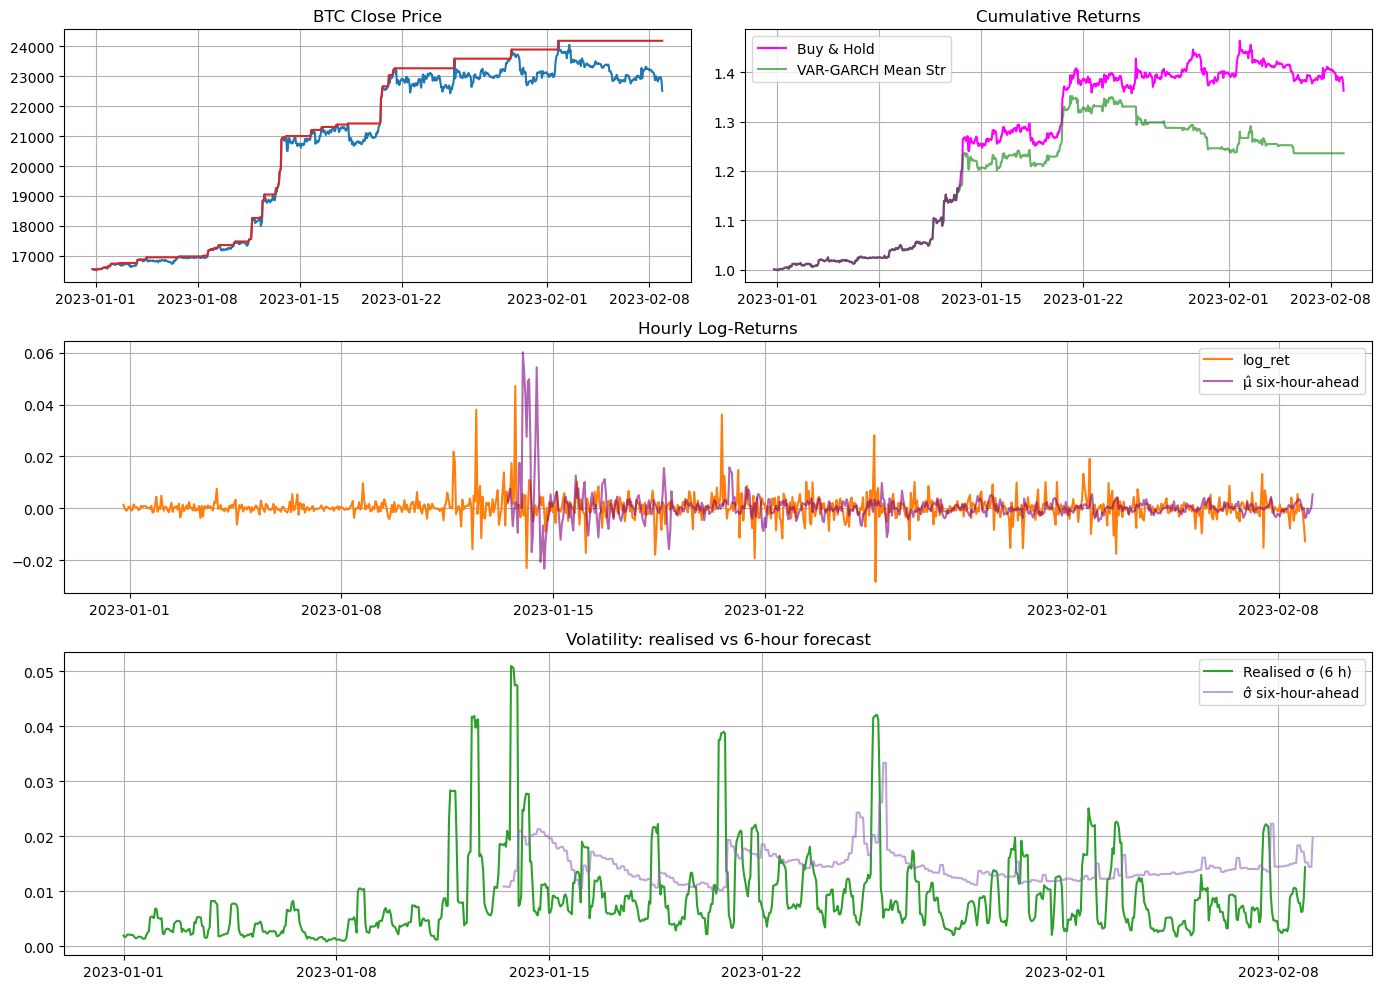

939 | 2023-02-08 21:00:00-06:00 | Close 22,518.44 | trail 27,501.37 | r -0.01272 | RV_blk  0.01436 | μ̂_blk  0.00525 | σ̂_blk  0.01967 | pos 1 | eps  0.00393 | cooldown 2 | hold_ttl   6.00000
Exit flag detected — stopping.


In [ ]:
# ---------------- containers for plotting ---------------------------
ts_x, close_y, cummax_y, logret_y = [], [], [], []
realvol_y               = []

fcst_x, fcst_y          = [], []       # points drawn 6 h in the future

cstrategy_y, creturns_y       = [], []     # <-- will be filled now

# ----- new containers for mean forecasts -----
mean_fcst_x, mean_fcst_y = [], []     # time-stamps & values

# ---------------- container for permanent storage -------------------
results_log = []              # one dict = one row in final DF
decision_log = []
forecast_log = []   # forecasts indexed by their target time (t+6h)
X_train = []                  # Train VAR model

mu_hist = deque(maxlen=2000)        # recent μ forecasts for adaptive eps
hold_ttl = 0                  # bars left to honor a block-long view
cooldown = 0                  # bars left before next flip allowed
position    = 1               # 1 = long ; 0 = flat
cum_asset   = 0.0             # cumulative *log* return of BTC
cum_strat   = 0.0             # cumulative *log* return of strategy

# --- predictions storage ---
var_res = None
lag_order = None
g_mod = None

# -------------- MAIN BACKTEST LOOP (VAR-GARCH version) --------------
for n, partial_df  in enumerate(simulate_market(btc, delay=0.1), start=1):
    partial_df = partial_df.copy()
    # Current rows in partial_df:
    # index: timestamp
    # [0]: open
    # [1]: high
    # [2]: low
    # [3]: close
    # [4]: volume
    # added columns:
    partial_df['cummax'] = partial_df['close'].cummax()

    # ―――― 0. FIRST PARAMETERS ―――――――――――――――――――――――――――――――――――――
    latest   = partial_df.iloc[-1]        # last row
    tstamp = latest.name                  # current time
    prev_pos = position                   # yesterday’s stance

    first_row = latest[0]                 # first row to revert log changes


    # ―――― 1. CALCULATE LOG CHANGES TO TRAIN VAR ――――――――――――――――――――
    vol = partial_df['volume'].replace(0, np.nan)
    
    log_chg_open = np.log(partial_df['open'] / partial_df['open'].shift(1))
    log_chg_high = np.log(partial_df['high'] / partial_df['high'].shift(1)) 
    log_chg_low = np.log(partial_df['low'] / partial_df['low'].shift(1)) 
    log_chg_close = np.log(partial_df['close'] / partial_df['close'].shift(1))
    log_chg_volume = np.log(vol / vol.shift(1))

    X_train.append(dict(
        timestamp = tstamp,
        open = log_chg_open.iloc[-1],
        high = log_chg_high.iloc[-1],
        low = log_chg_low.iloc[-1],
        close = log_chg_close.iloc[-1],
        volume = log_chg_volume.iloc[-1]
    ))

    # ―――― 2. RETURN ACCRUAL ―――――――――――――――――――――――――――――――――――――――
    cum_asset += log_chg_close.iloc[-1]
    cum_strat += prev_pos * log_chg_close.iloc[-1]
    creturns_y.append(np.exp(cum_asset))        # buy-&-hold equity curve
    cstrategy_y.append(np.exp(cum_strat))       # strategy equity curve


    # ―――― 3. REALISED VOL (6-h rolling σ of returns) ―――――――――――――――
    # realised = log_chg_close.rolling(6).std().iloc[-1] if len(log_chg_close) >= 6 else np.nan
    realised = np.sqrt((log_chg_close**2).rolling(6).sum()).iloc[-1] \
           if len(log_chg_close) >= 6 else np.nan

    # book-keeping for plots
    ts_x.append(tstamp);  close_y.append(latest.close)
    logret_y.append(log_chg_close.iloc[-1]);   realvol_y.append(realised)
    cummax_y.append(partial_df['cummax'].iloc[-1])

    # ---------- baseline row ---------------------------------
    results_log.append(dict(
        timestamp      = tstamp,
        close          = latest.close,
        log_ret        = log_chg_close.iloc[-1],
        realized_vol   = realised,
        forecasted_vol = np.nan,
        forecasted_mu  = np.nan,
        position       = position,        
        cum_asset      = cum_asset,      
        cum_strat      = cum_strat         
    ))

    # ―――――――― 4. ONLY FIT IF WE HAVE ENOUGH HIST. ――――――――――――
    df_train = pd.DataFrame(X_train).dropna()

    # initialize per-iteration
    mu_6h = mu_block = vol_6h = mu_signal = np.nan

    min_sample = 300        # keep it light in live loop
    lookback = int(0.6 * len(df_train))  # 60% of available data
    N_update = 3  # update every 3 hours


    # ---------- 4A) FIT MODEL every N_update steps ----------
    if len(df_train) >= min_sample and n % N_update == 0:
        y_vars = df_train[['open', 'high', 'low', 'close', 'volume']].dropna().iloc[-lookback:]
        y_vars = y_vars.replace([np.inf,-np.inf], np.nan).dropna()

        #--------------------- VAR model ---------------------
        var_model = VAR(y_vars)
        var_res = var_model.fit(maxlags=6, trend='n')   # <- 'n' for returns,  ic='aic'
        lag_order = var_res.k_ar
        #-------------- GARCH(1,1) model ---------------------
        resids = var_res.resid['close'].dropna()
        resids = (resids * 1000).iloc[-lookback:]
        g_mod = arch_model(resids, p=1, q=1, vol='GARCH', mean='Zero',
                        dist='t', rescale=False).fit(disp='off')

    # ---------- 4B) FORECAST every loop ----------
    if var_res is not None and lag_order is not None:
        y_vars = df_train[['open', 'high', 'low', 'close', 'volume']].dropna().iloc[-lookback:]
        if len(y_vars) >= lag_order:
            mu_path = var_res.forecast(y_vars.values[-lag_order:], steps=6)
            idx_close = y_vars.columns.get_loc('close')
            mu_vec      = mu_path[:, idx_close]      # all 6 hourly forecasts

            mu_6h     = mu_vec[-1]        # last step
            mu_block  = mu_vec.sum()      # 6-hour block return
            mu_signal = mu_block          # trade on the block


    if g_mod is not None and g_mod.optimization_result.success:
        g_fcast = g_mod.forecast(horizon=6)
        var_path = g_fcast.variance.iloc[-1].values   # 6 values
        vol_6h   = np.sqrt(var_path.sum()) / 1000     # block risk
        # vol_6h = np.sqrt(g_fcast.variance.iloc[-1].values[-1]) / 1000

    # ------------------ dynamic σ_cut, binary stance ------------------

    λ          = 0.94          # decay
    alpha      = 1 - λ
    target_exp = 0.008         # floor
    k          = 1.5
    min_obs    = 30            # safety

    rv = pd.Series(realvol_y).dropna()       # realised σ list → Series

    if len(rv) >= min_obs:
        stats      = rv.ewm(alpha=alpha, adjust=False)
        ewma_mean  = stats.mean().iloc[-1]
        ewma_sd    = np.sqrt(stats.var(bias=False).iloc[-1])
        sigma_cut  = max(target_exp, ewma_mean + k * ewma_sd)
    else:
        sigma_cut  = target_exp
    
    # --------------- adaptative eps threshold -------------------------

    if np.isfinite(mu_signal):
        mu_hist.append(mu_signal)


    # after updating mu_hist and vol_6h
    base_eps = np.quantile(np.abs(mu_hist), 0.55) if len(mu_hist) >= 200 else 9e-4
    vol_term = 0.20 * vol_6h if np.isfinite(vol_6h) else 0.0
    eps = max(0.5 * base_eps, vol_term)

    # ―――― 5. DECISION LOGIC (long-only) ―――――――――――――――――――――――――

    #############################################################
    #############################################################

    # ─── parameters ─────────────────────────────────────────────────────

    # ─── defaults ───────────────────────────────────────────────────────
    close_price = latest.close
    cummax       = partial_df['cummax'].iloc[-1]

    real_vol_block_now = (pd.Series(logret_y)**2).rolling(6).sum().pow(0.5).iloc[-1]
    if not np.isfinite(real_vol_block_now):
        real_vol_block_now = 0.0
    dd_pct = np.clip(0.02 + 4.0*real_vol_block_now, 0.02, 0.08)
    trail_break  = close_price < trail_threshold

    new_pos = position
    reason  = "HOLD: no valid forecast"

    if cooldown > 0:
        cooldown -= 1  # simple cool-down counter
    
    # decrement hold window BEFORE making a new decision,
    # so the bar you open the trade doesn't eat a tick
    if hold_ttl > 0:
        hold_ttl -= 1


    new_pos = position
    reason  = "HOLD: no valid forecast"

    if np.isfinite(mu_signal) and np.isfinite(vol_6h):

        # --- emergency flat only if trailing + (risk high & μ not bullish) or μ clearly negative
        emergency_flat = trail_break and ((vol_6h > sigma_cut and mu_signal <= eps) or (mu_signal < -eps))

        if emergency_flat and cooldown == 0:
            new_pos = 0
            reason  = (f"FLAT: trail & risk (μ̂_blk={mu_signal:.5f}, "
                    f"σ̂_blk={vol_6h:.5f} > σ_cut={sigma_cut:.5f})")

        # --- if in a hold window, keep long unless emergency (handled above)
        elif hold_ttl > 0:
            new_pos = 1
            reason  = f"HOLD-LONG: honoring 6-bar window (TTL={hold_ttl})"

        # --- normal regime
        else:
            if mu_signal > eps and cooldown == 0:
                new_pos = 1
                hold_ttl = 6                       # start a fresh 6-bar hold
                reason   = f"LONG: μ̂_blk={mu_signal:.5f} > eps (start 6-bar hold)"
            elif mu_signal < -eps and vol_6h > sigma_cut and cooldown == 0:
                new_pos = 0
                reason  = (f"FLAT: μ̂_blk={mu_signal:.5f} < -eps and "
                        f"σ̂_blk={vol_6h:.5f} > σ_cut={sigma_cut:.5f})")
            else:
                reason  = (f"HOLD: μ̂_blk={mu_signal:.5f}, σ̂_blk={vol_6h:.5f}; no trigger")

    # apply cooldown if we flipped
    if int(new_pos) != int(position):
        cooldown = 2
    position = int(new_pos)


    #############################################################
    #############################################################

    # ―――― 6. LOGGING FOR LATER ANALYSIS ――――――――――――――――――――――――

    decision_log.append({
        "timestamp": tstamp,
        "prev_position": prev_pos,
        "new_position": new_pos,
        "cooldown": cooldown,
        "hold_ttl": hold_ttl,     # ← add
        "eps": eps,
        "mu_blk": mu_signal,
        "sigma_cut": sigma_cut,
        "vol_6h": vol_6h,
        "close": close_price,
        "cummax": cummax,
        "trail_threshold": trail_threshold,
        "reason": reason
    })
                    
    # ---------- if we have a forecast, plot & store it 6 h ahead ------
    if np.isfinite(vol_6h) and np.isfinite(mu_signal):
        future_ts   = tstamp + pd.Timedelta(hours=6)

        # for plotting
        fcst_x.append(future_ts);   fcst_y.append(vol_6h)
        mean_fcst_x.append(future_ts); mean_fcst_y.append(mu_signal)

        results_log.append(dict(
        timestamp      = future_ts,
        close          = np.nan,
        log_ret        = np.nan,
        realized_vol   = np.nan,
        forecasted_vol = vol_6h,
        forecasted_mu  = mu_signal,
        position       = np.nan,        
        cum_asset      = np.nan,      
        cum_strat      = np.nan))

        # store forecast for evaluation (no position or P&L here)
        forecast_log.append(dict(
            origin_ts      = tstamp,         # when it was produced (optional, nice for audits)
            target_ts      = future_ts,      # when the forecast is meant to apply
            forecasted_vol = vol_6h,
            forecasted_mu  = mu_signal
        ))


    # ―――― 7. PLOT ――――――――――――――――――――――――――――――――――――――――――
    clear_output(wait=True)
    fig = plt.figure(figsize=(14, 10))
    gs  = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1.2])


    # 1) Price
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(ts_x, close_y, color="tab:blue")
    ax1.plot(ts_x, cummax_y, color="tab:red")
    ax1.set_title("BTC Close Price"); ax1.grid(True)


    # 2) Cum-returns vs strategy
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(ts_x, creturns_y,  label="Buy & Hold", color="magenta")
    ax2.plot(ts_x, cstrategy_y, label="VAR-GARCH Mean Str", color="green", alpha=0.6)
    ax2.set_title("Cumulative Returns"); ax2.legend(); ax2.grid(True)

    # 3) Log-returns + mean
    ax3 = fig.add_subplot(gs[1, :])
    ax3.plot(ts_x, logret_y, color="tab:orange", label="log_ret")
    ax3.plot(mean_fcst_x, mean_fcst_y, color="purple", label="μ̂ six-hour-ahead", alpha=0.6)
    ax3.set_title("Hourly Log-Returns"); ax3.legend(); ax3.grid(True)


    # 4) Volatility
    ax4 = fig.add_subplot(gs[2, :])
    ax4.plot(ts_x, realvol_y, color="tab:green", label="Realised σ (6 h)")
    ax4.plot(fcst_x, fcst_y, color="tab:purple", label="σ̂ six-hour-ahead", alpha=0.6)
    ax4.set_title("Volatility: realised vs 6-hour forecast")
    ax4.legend(); ax4.grid(True)

    plt.tight_layout(); plt.show()

    
    print(f"{n:3d} | {tstamp} | Close {latest.close:,.2f} | "
        f"trail {trail_threshold:,.2f} | r {log_chg_close.iloc[-1]: .5f} | "
        f"RV_blk {realised: .5f} | μ̂_blk {mu_signal if np.isfinite(mu_signal) else np.nan: .5f} | "
        f"σ̂_blk {vol_6h if np.isfinite(vol_6h) else np.nan: .5f} | "
        f"pos {position} | eps {eps: .5f} | cooldown {cooldown} | hold_ttl  {hold_ttl: .5f}")


    # Auto-stop via file flag
    if os.path.exists("exit.flag"):
        print("Exit flag detected — stopping.")
        break

    # if n == 5000: break

# ------------------------- FINAL DF -------------------------
# 1) Build DataFrame, set index, sort
df_results = (pd.DataFrame(results_log)
                .set_index("timestamp")
                .sort_index())          # ensure chronological order

# 2) Collapse to hourly granularity
df_results.index = df_results.index.floor("h")

# 3) Aggregate duplicates:
#    - take FIRST actual price/return/realised vol for the hour
#    - take LAST forecasts & cumulative P/L (they belong to the future row)
df_final = (df_results
    .groupby(level=0)
    .agg(
        close          = ('close',          'first'),
        log_ret        = ('log_ret',        'first'),
        realized_vol   = ('realized_vol',   'first'),
        forecasted_vol = ('forecasted_vol', 'last'),   # picks the one non-NaN
        forecasted_mu  = ('forecasted_mu',  'last'),
        position       = ('position',       'max'),   # baseline has value; forecast row is NaN
        cum_asset      = ('cum_asset',      'last'),
        cum_strat      = ('cum_strat',      ''),
    )
    .sort_index()
)


df_log_changes = (pd.DataFrame(X_train)
                  .set_index("timestamp")
                  .sort_index())

# Build df_forecasts safely
df_forecasts = pd.DataFrame(forecast_log)

if df_forecasts.empty or 'target_ts' not in df_forecasts.columns:
    print("No forecast rows captured yet (df_forecasts is empty).")
    df_forecasts = (pd.DataFrame(columns=['origin_ts','forecasted_vol','forecasted_mu'])
                      .set_index(pd.DatetimeIndex([], name='target_ts')))
else:
    df_forecasts = df_forecasts.set_index('target_ts').sort_index()


df_decision_log = (pd.DataFrame(decision_log)
                    .set_index("timestamp")
                    .sort_index())

In [58]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_final.index,
    y=df_final['cum_asset'],
    mode='lines',
    name='Buy & Hold Strategy'
))

fig.add_trace(go.Scatter(
    x=df_final.index,
    y=df_final['cum_strat'],
    mode='lines',
    name='Active Strategy'
))

fig.update_layout(
    title='Cumulative Returns: Strategy vs Buy & Hold',
    xaxis_title='Timestamp',
    yaxis_title='Cumulative Log Return',
    legend=dict(x=0, y=1.1, orientation='h'),
    hovermode='x unified',
    template='seaborn'  # Optional: try 'plotly', 'ggplot2', 'seaborn'
)

fig.show()

In [94]:
# 6h realized block (trailing, so at time T it equals T-5..T sum)
real_mu_block  = df_final['log_ret'].rolling(6).sum()
real_vol_block = (df_final['log_ret']**2).rolling(6).sum()**0.5

# forecasts are stored by target time (t+6h) — perfect to join on index
df_eval = (df_final
    .join(df_decision_log[['new_position','eps','sigma_cut','trail_threshold','reason']], how='left')
    .assign(real_mu_block = real_mu_block, real_vol_block = real_vol_block)
    .dropna(subset=['real_mu_block'])  # need realized 6h blocks
)

df_eval[['forecasted_mu','forecasted_vol','real_mu_block','real_vol_block','new_position','eps']]


,forecasted_mu,forecasted_vol,real_mu_block,real_vol_block,new_position,eps
timestamp,,,,,,
2023-01-01 00:00:00-06:00,NaN,NaN,0.000612,0.001914,1.0,0.000450
2023-01-01 01:00:00-06:00,NaN,NaN,-0.001529,0.001613,1.0,0.000450
2023-01-01 02:00:00-06:00,NaN,NaN,-0.002108,0.001780,1.0,0.000450
2023-01-01 03:00:00-06:00,NaN,NaN,0.000293,0.002129,1.0,0.000450
2023-01-01 04:00:00-06:00,NaN,NaN,0.001602,0.002116,1.0,0.000450
...,...,...,...,...,...,...
2023-02-08 17:00:00-06:00,0.003218,0.018324,-0.001786,0.007845,0.0,0.003048
2023-02-08 18:00:00-06:00,0.001462,0.017181,0.003820,0.006223,0.0,0.002884
2023-02-08 19:00:00-06:00,-0.000607,0.017181,0.003197,0.006333,0.0,0.002884


In [95]:
d = df_eval.dropna(subset=['forecasted_mu','real_mu_block']).copy()

# (a) Is μ predictive?
hit_rate = np.mean(np.sign(d['forecasted_mu']) == np.sign(d['real_mu_block']))
corr     = d[['forecasted_mu','real_mu_block']].corr().iloc[0,1]
print(f"Directional hit rate: {hit_rate:.2%}  |  Corr: {corr:.3f}")

# (b) Are we just filtering away most longs?
trade_frac = np.mean(d['forecasted_mu'] > d['eps'])
print(f"Share of times μ > eps: {trade_frac:.2%}")

# (c) What happens when we *do* go long?
mask_long = d['new_position'] == 1
print("Avg realized 6h when LONG:", d.loc[mask_long, 'real_mu_block'].mean())
print("Avg realized 6h when FLAT:", d.loc[~mask_long,'real_mu_block'].mean())

# (d) Does the vol-linked threshold kill entries in rallies?
d['mu_over_eps'] = d['forecasted_mu'] - d['eps']
print(d[['mu_over_eps','forecasted_vol','real_mu_block']].describe())

# (e) How often did trailing stop flatten us *before* good 6h returns?
trail_flat = d['reason'].fillna('').str.contains('FLAT: trail')
print("Count trail flats:", trail_flat.sum(),
      " | Avg next 6h return after trail flat:", d.loc[trail_flat, 'real_mu_block'].mean())


Directional hit rate: 55.52%  |  Corr: 0.015
Share of times μ > eps: 15.77%
Avg realized 6h when LONG: 0.0038993185702933036
Avg realized 6h when FLAT: -0.0006031699398697855
       mu_over_eps  forecasted_vol  real_mu_block
count   634.000000      634.000000     634.000000
mean     -0.002186        0.014520       0.001719
std       0.006534        0.003039       0.012565
min      -0.027358        0.010119      -0.032818
25%      -0.004191        0.012463      -0.004180
50%      -0.002742        0.013903       0.000442
75%      -0.001062        0.015872       0.006382
max       0.056460        0.033328       0.079637
Count trail flats: 161  | Avg next 6h return after trail flat: -0.0004965828432378397


#### v.06

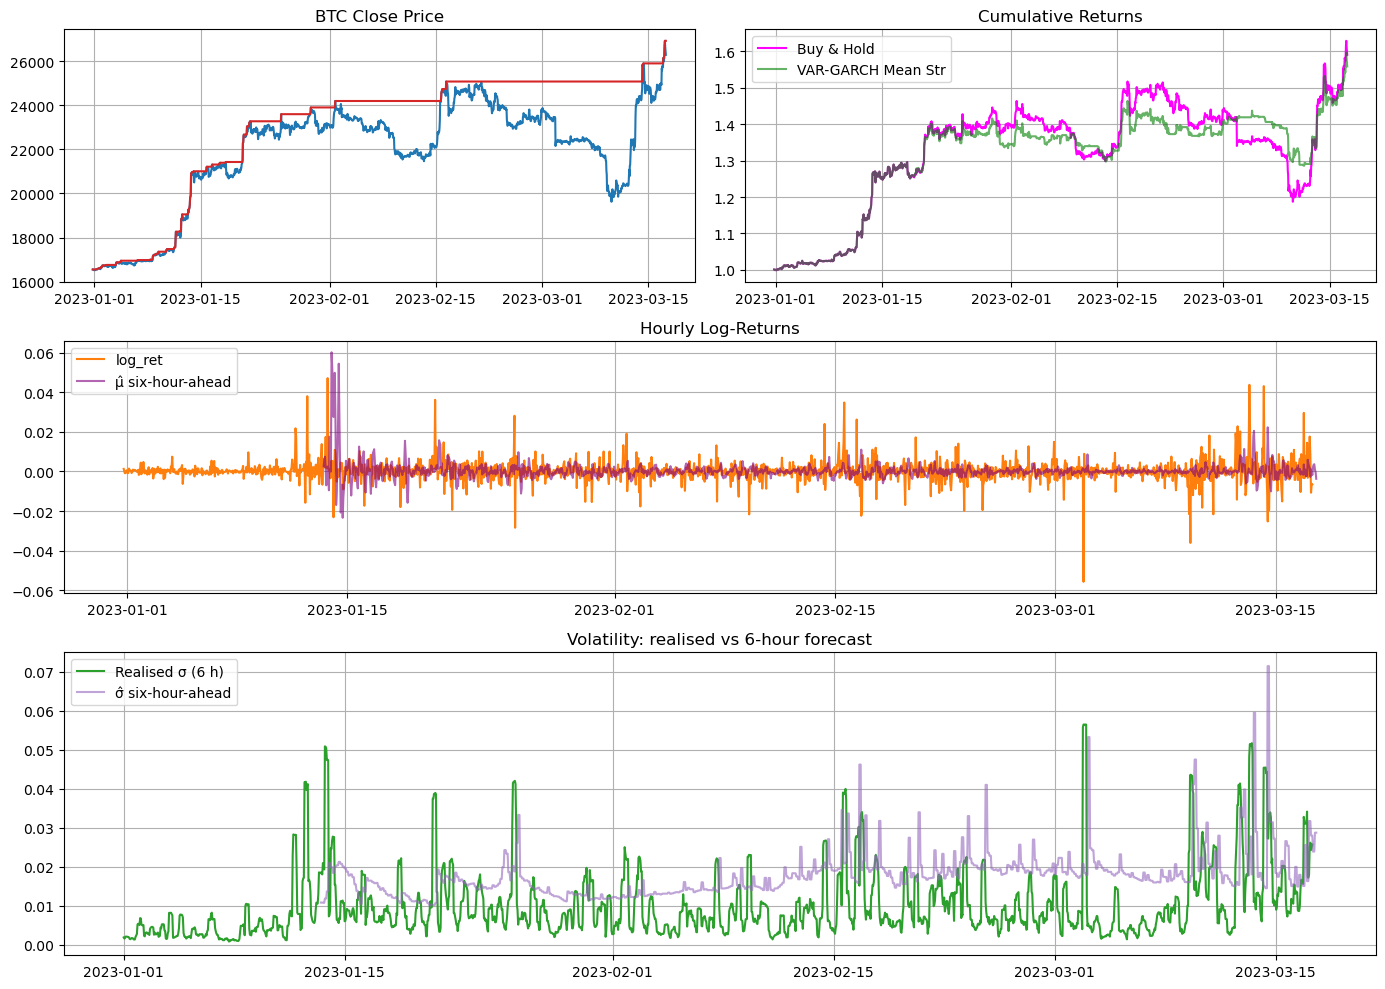

1814 | 2023-03-17 08:00:00-06:00 | Close 26,283.00 | trail 25,129.80 | r -0.00648 | RV_blk  0.02573 | μ̂_blk -0.00369 | σ̂_blk  0.02877 | pos 1 | s_eps  0.04724 | cooldown 0 | hold_ttl   3.00000
Exit flag detected — stopping.


In [19]:
# ---------------- containers for plotting ---------------------------
ts_x, close_y, cummax_y, logret_y = [], [], [], []
realvol_y               = []

fcst_x, fcst_y          = [], []       # points drawn 6 h in the future

cstrategy_y, creturns_y       = [], []     # <-- will be filled now

# ----- new containers for mean forecasts -----
mean_fcst_x, mean_fcst_y = [], []     # time-stamps & values

# ---------------- container for permanent storage -------------------
results_log = []              # one dict = one row in final DF
decision_log = []
forecast_log = []   # forecasts indexed by their target time (t+6h)
X_train = []                  # Train VAR model

mu_hist = deque(maxlen=2000)        # recent μ forecasts for adaptive eps
s_hist = deque(maxlen=2000)   # top of file with other deques
hold_ttl = 0                  # bars left to honor a block-long view
cooldown = 0                  # bars left before next flip allowed
position    = 1               # 1 = long ; 0 = flat
cum_asset   = 0.0             # cumulative *log* return of BTC
cum_strat   = 0.0             # cumulative *log* return of strategy

# --- predictions storage ---
var_res = None
lag_order = None
g_mod = None

# -------------- MAIN BACKTEST LOOP (VAR-GARCH version) --------------
for n, partial_df  in enumerate(simulate_market(btc, delay=0.1), start=1):
    partial_df = partial_df.copy()
    # Current rows in partial_df:
    # index: timestamp
    # [0]: open
    # [1]: high
    # [2]: low
    # [3]: close
    # [4]: volume
    # added columns:
    partial_df['cummax'] = partial_df['close'].cummax()

    # ―――― 0. FIRST PARAMETERS ―――――――――――――――――――――――――――――――――――――
    latest   = partial_df.iloc[-1]        # last row
    tstamp = latest.name                  # current time
    prev_pos = position                   # yesterday’s stance

    first_row = latest[0]                 # first row to revert log changes


    # ―――― 1. CALCULATE LOG CHANGES TO TRAIN VAR ――――――――――――――――――――
    vol = partial_df['volume'].replace(0, np.nan)
    
    log_chg_open = np.log(partial_df['open'] / partial_df['open'].shift(1))
    log_chg_high = np.log(partial_df['high'] / partial_df['high'].shift(1)) 
    log_chg_low = np.log(partial_df['low'] / partial_df['low'].shift(1)) 
    log_chg_close = np.log(partial_df['close'] / partial_df['close'].shift(1))
    log_chg_volume = np.log(vol / vol.shift(1))

    X_train.append(dict(
        timestamp = tstamp,
        open = log_chg_open.iloc[-1],
        high = log_chg_high.iloc[-1],
        low = log_chg_low.iloc[-1],
        close = log_chg_close.iloc[-1],
        volume = log_chg_volume.iloc[-1]
    ))

    # ―――― 2. RETURN ACCRUAL ―――――――――――――――――――――――――――――――――――――――
    cum_asset += log_chg_close.iloc[-1]
    cum_strat += prev_pos * log_chg_close.iloc[-1]
    creturns_y.append(np.exp(cum_asset))        # buy-&-hold equity curve
    cstrategy_y.append(np.exp(cum_strat))       # strategy equity curve


    # ―――― 3. REALISED VOL (6-h rolling σ of returns) ―――――――――――――――
    # realised = log_chg_close.rolling(6).std().iloc[-1] if len(log_chg_close) >= 6 else np.nan
    realised = np.sqrt((log_chg_close**2).rolling(6).sum()).iloc[-1] \
           if len(log_chg_close) >= 6 else np.nan

    # book-keeping for plots
    ts_x.append(tstamp);  close_y.append(latest.close)
    logret_y.append(log_chg_close.iloc[-1]);   realvol_y.append(realised)
    cummax_y.append(partial_df['cummax'].iloc[-1])

    # ---------- baseline row ---------------------------------
    results_log.append(dict(
        timestamp      = tstamp,
        close          = latest.close,
        log_ret        = log_chg_close.iloc[-1],
        realized_vol   = realised,
        forecasted_vol = np.nan,
        forecasted_mu  = np.nan,
        position       = position,        
        cum_asset      = cum_asset,      
        cum_strat      = cum_strat         
    ))

    # ―――――――― 4. ONLY FIT IF WE HAVE ENOUGH HIST. ――――――――――――
    df_train = pd.DataFrame(X_train).dropna()

    # initialize per-iteration
    mu_6h = mu_block = vol_6h = mu_signal = np.nan

    min_sample = 300        # keep it light in live loop
    lookback = int(0.6 * len(df_train))  # 60% of available data
    N_update = 3  # update every 3 hours


    # ---------- 4A) FIT MODEL every N_update steps ----------
    if len(df_train) >= min_sample and n % N_update == 0:
        y_vars = df_train[['open', 'high', 'low', 'close', 'volume']].dropna().iloc[-lookback:]
        y_vars = y_vars.replace([np.inf,-np.inf], np.nan).dropna()

        #--------------------- VAR model ---------------------
        var_model = VAR(y_vars)
        var_res = var_model.fit(maxlags=6, trend='n')   # <- 'n' for returns,  ic='aic'
        lag_order = var_res.k_ar
        #-------------- GARCH(1,1) model ---------------------
        resids = var_res.resid['close'].dropna()
        resids = (resids * 1000).iloc[-lookback:]
        g_mod = arch_model(resids, p=1, q=1, vol='GARCH', mean='Zero',
                        dist='t', rescale=False).fit(disp='off')

    # ---------- 4B) FORECAST every loop ----------
    if var_res is not None and lag_order is not None:
        y_vars = df_train[['open', 'high', 'low', 'close', 'volume']].dropna().iloc[-lookback:]
        if len(y_vars) >= lag_order:
            mu_path = var_res.forecast(y_vars.values[-lag_order:], steps=6)
            idx_close = y_vars.columns.get_loc('close')
            mu_vec      = mu_path[:, idx_close]      # all 6 hourly forecasts

            mu_6h     = mu_vec[-1]        # last step
            mu_block  = mu_vec.sum()      # 6-hour block return
            mu_signal = mu_block          # trade on the block


    if g_mod is not None and g_mod.optimization_result.success:
        g_fcast = g_mod.forecast(horizon=6)
        var_path = g_fcast.variance.iloc[-1].values   # 6 values
        vol_6h   = np.sqrt(var_path.sum()) / 1000     # block risk
        # vol_6h = np.sqrt(g_fcast.variance.iloc[-1].values[-1]) / 1000

    # ------------------ dynamic σ_cut, binary stance ------------------

    λ          = 0.94          # decay
    alpha      = 1 - λ
    target_exp = 0.008         # floor
    k          = 1.5
    min_obs    = 30            # safety

    rv = pd.Series(realvol_y).dropna()       # realised σ list → Series

    if len(rv) >= min_obs:
        stats      = rv.ewm(alpha=alpha, adjust=False)
        ewma_mean  = stats.mean().iloc[-1]
        ewma_sd    = np.sqrt(stats.var(bias=False).iloc[-1])
        sigma_cut  = max(target_exp, ewma_mean + k * ewma_sd)
    else:
        sigma_cut  = target_exp
    
    # --------------- adaptative eps threshold -------------------------

    if np.isfinite(mu_signal):
        mu_hist.append(mu_signal)


    # after updating mu_hist and vol_6h
    s = mu_signal / (vol_6h + 1e-12)           # 6h Sharpe-like score

    # keep a short history of scores for an adaptive but mild threshold
    if np.isfinite(s):
        s_hist.append(s)

    # light hurdle; aim to trade ~40–60% of the time (tune the quantile)
    s_eps = np.quantile(np.abs(s_hist), 0.40) if len(s_hist) >= 200 else 0.10

    # ―――― 5. DECISION LOGIC (long-only) ―――――――――――――――――――――――――

    #############################################################
    #############################################################

    close_price = latest.close
    cummax       = partial_df['cummax'].iloc[-1]

    real_vol_block_now = (pd.Series(logret_y)**2).rolling(6).sum().pow(0.5).iloc[-1]
    if not np.isfinite(real_vol_block_now):
        real_vol_block_now = 0.0
    dd_pct = np.clip(0.015 + 2.0*real_vol_block_now, 0.015, 0.08)

    trail_threshold = cummax * (1 - dd_pct)
    trail_break  = close_price < trail_threshold

    if cooldown > 0:
        cooldown -= 1  # simple cool-down counter

    # decrement hold window BEFORE making a new decision (once, here)
    if hold_ttl > 0:
        hold_ttl = max(hold_ttl - 1, 0)

    new_pos = position
    reason  = "HOLD: no valid forecast"


    if np.isfinite(mu_signal) and np.isfinite(vol_6h):
        # --- paste your block here ---
        # --- emergency flat still allowed
        emergency_flat = trail_break and (s <= s_eps/2 or mu_signal < -abs(s_eps)*vol_6h)

        if emergency_flat and cooldown == 0:
            new_pos = 0
            reason  = f"FLAT: trail & risk (s={s:.2f} <= {s_eps/2:.2f})"

        elif hold_ttl > 0:
            new_pos = 1
            if s > s_eps:                          # optional refresh
                hold_ttl = 6
            reason  = f"HOLD-LONG: honoring window (TTL={hold_ttl}, s={s:.2f})"

        else:
            if s > s_eps and cooldown == 0:
                new_pos = 1
                hold_ttl = 6
                reason   = f"LONG: s={s:.2f} > s_eps={s_eps:.2f} (start 6-bar hold)"
            elif s < -s_eps and vol_6h > sigma_cut and cooldown == 0:
                new_pos = 0
                reason  = f"FLAT: s={s:.2f} < -s_eps and σ̂_blk>{sigma_cut:.5f}"
            else:
                reason  = f"HOLD: s={s:.2f}, σ̂_blk={vol_6h:.5f}; no trigger"


    # apply cooldown if we flipped
    if int(new_pos) != int(position):
        cooldown = 2
    position = int(new_pos)


    #############################################################
    #############################################################

    # ―――― 6. LOGGING FOR LATER ANALYSIS ――――――――――――――――――――――――

    decision_log.append({
        "timestamp": tstamp,
        "prev_position": prev_pos,
        "new_position": new_pos,
        "cooldown": cooldown,
        "hold_ttl": hold_ttl,     # ← add
        "mu_blk": mu_signal,
        "sigma_cut": sigma_cut,
        "vol_6h": vol_6h,
        "close": close_price,
        "cummax": cummax,
        "trail_threshold": trail_threshold,
        "reason": reason,
        "s": s,
        "s_eps": s_eps
    })
                    
    # ---------- if we have a forecast, plot & store it 6 h ahead ------
    if np.isfinite(vol_6h) and np.isfinite(mu_signal):
        future_ts   = tstamp + pd.Timedelta(hours=6)

        # for plotting
        fcst_x.append(future_ts);   fcst_y.append(vol_6h)
        mean_fcst_x.append(future_ts); mean_fcst_y.append(mu_signal)

        results_log.append(dict(
        timestamp      = future_ts,
        close          = np.nan,
        log_ret        = np.nan,
        realized_vol   = np.nan,
        forecasted_vol = vol_6h,
        forecasted_mu  = mu_signal,
        position       = np.nan,        
        cum_asset      = np.nan,      
        cum_strat      = np.nan))

        # store forecast for evaluation (no position or P&L here)
        forecast_log.append(dict(
            origin_ts      = tstamp,         # when it was produced (optional, nice for audits)
            target_ts      = future_ts,      # when the forecast is meant to apply
            forecasted_vol = vol_6h,
            forecasted_mu  = mu_signal
        ))


    # ―――― 7. PLOT ――――――――――――――――――――――――――――――――――――――――――
    clear_output(wait=True)
    fig = plt.figure(figsize=(14, 10))
    gs  = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1.2])


    # 1) Price
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(ts_x, close_y, color="tab:blue")
    ax1.plot(ts_x, cummax_y, color="tab:red")
    ax1.set_title("BTC Close Price"); ax1.grid(True)


    # 2) Cum-returns vs strategy
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(ts_x, creturns_y,  label="Buy & Hold", color="magenta")
    ax2.plot(ts_x, cstrategy_y, label="VAR-GARCH Mean Str", color="green", alpha=0.6)
    ax2.set_title("Cumulative Returns"); ax2.legend(); ax2.grid(True)

    # 3) Log-returns + mean
    ax3 = fig.add_subplot(gs[1, :])
    ax3.plot(ts_x, logret_y, color="tab:orange", label="log_ret")
    ax3.plot(mean_fcst_x, mean_fcst_y, color="purple", label="μ̂ six-hour-ahead", alpha=0.6)
    ax3.set_title("Hourly Log-Returns"); ax3.legend(); ax3.grid(True)


    # 4) Volatility
    ax4 = fig.add_subplot(gs[2, :])
    ax4.plot(ts_x, realvol_y, color="tab:green", label="Realised σ (6 h)")
    ax4.plot(fcst_x, fcst_y, color="tab:purple", label="σ̂ six-hour-ahead", alpha=0.6)
    ax4.set_title("Volatility: realised vs 6-hour forecast")
    ax4.legend(); ax4.grid(True)

    plt.tight_layout(); plt.show()

    
    print(f"{n:3d} | {tstamp} | Close {latest.close:,.2f} | "
        f"trail {trail_threshold:,.2f} | r {log_chg_close.iloc[-1]: .5f} | "
        f"RV_blk {realised: .5f} | μ̂_blk {mu_signal if np.isfinite(mu_signal) else np.nan: .5f} | "
        f"σ̂_blk {vol_6h if np.isfinite(vol_6h) else np.nan: .5f} | "
        f"pos {position} | s_eps {s_eps: .5f} | cooldown {cooldown} | hold_ttl  {hold_ttl: .5f}")


    # Auto-stop via file flag
    if os.path.exists("exit.flag"):
        print("Exit flag detected — stopping.")
        break

    # if n == 5000: break

# ------------------------- FINAL DF -------------------------
# 1) Build DataFrame, set index, sort
df_results = (pd.DataFrame(results_log)
                .set_index("timestamp")
                .sort_index())          # ensure chronological order

# 2) Collapse to hourly granularity
df_results.index = df_results.index.floor("h")

# 3) Aggregate duplicates:
#    - take FIRST actual price/return/realised vol for the hour
#    - take LAST forecasts & cumulative P/L (they belong to the future row)
df_final = (df_results
    .groupby(level=0)
    .agg(
        close          = ('close',          'first'),
        log_ret        = ('log_ret',        'first'),
        realized_vol   = ('realized_vol',   'first'),
        forecasted_vol = ('forecasted_vol', 'last'),   # picks the one non-NaN
        forecasted_mu  = ('forecasted_mu',  'last'),
        position       = ('position',       'last'),   # baseline has value; forecast row is NaN
        cum_asset      = ('cum_asset',      'last'),
        cum_strat      = ('cum_strat',      'last'),
    )
    .sort_index()
)


df_log_changes = (pd.DataFrame(X_train)
                  .set_index("timestamp")
                  .sort_index())

# Build df_forecasts safely
df_forecasts = pd.DataFrame(forecast_log)

if df_forecasts.empty or 'target_ts' not in df_forecasts.columns:
    print("No forecast rows captured yet (df_forecasts is empty).")
    df_forecasts = (pd.DataFrame(columns=['origin_ts','forecasted_vol','forecasted_mu'])
                      .set_index(pd.DatetimeIndex([], name='target_ts')))
else:
    df_forecasts = df_forecasts.set_index('target_ts').sort_index()


df_decision_log = (pd.DataFrame(decision_log)
                    .set_index("timestamp")
                    .sort_index())

### v.07

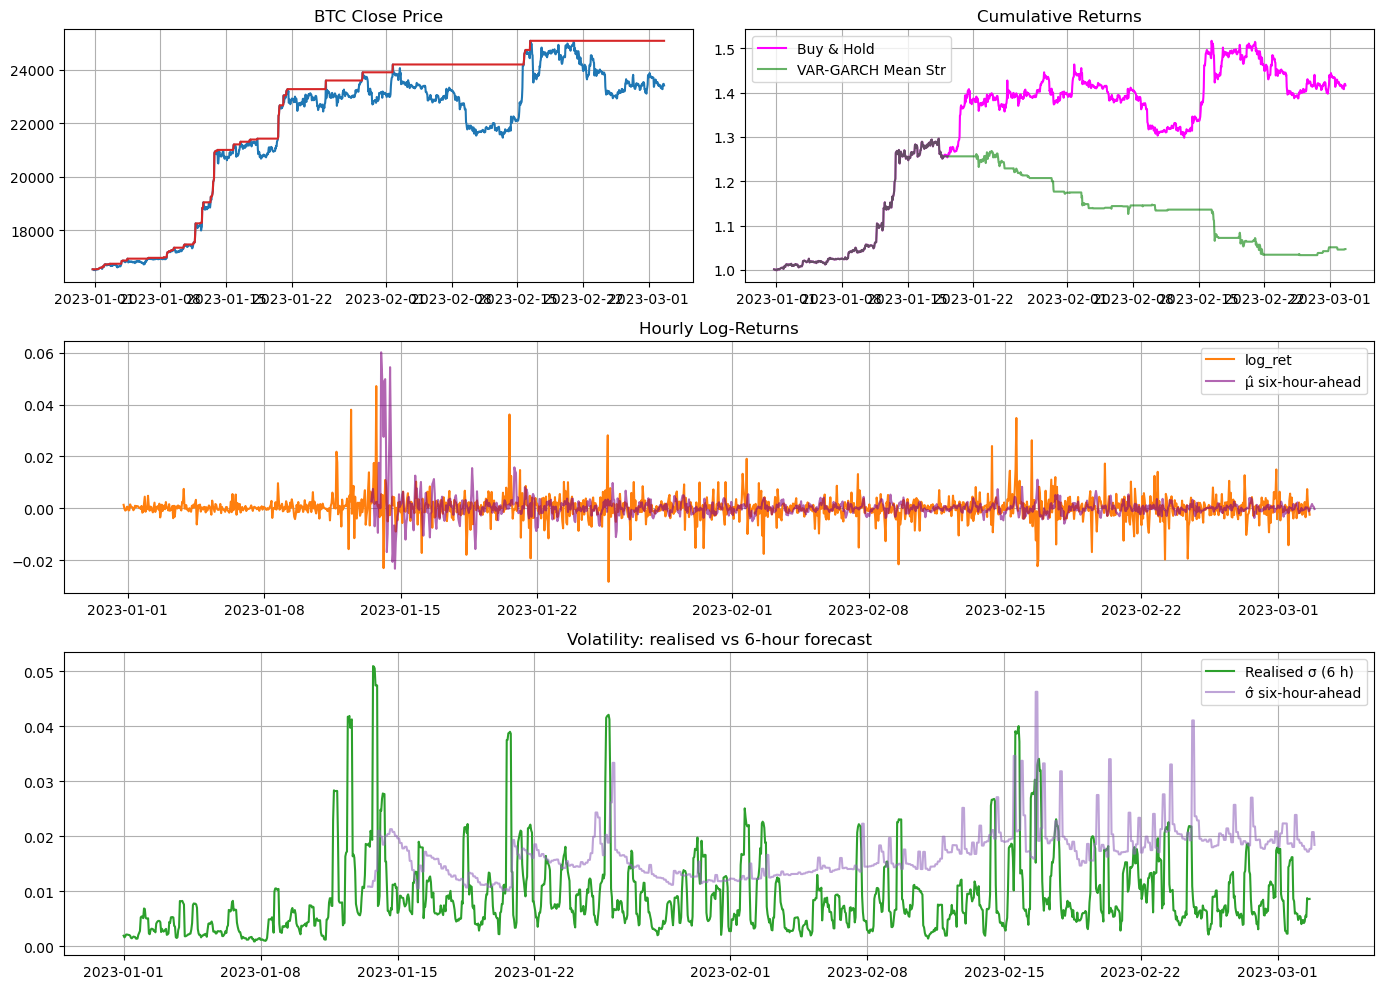

1461 | 2023-03-02 15:00:00-06:00 | Close 23,408.65 | trail 24,265.54 | r -0.00249 | RV_blk  0.00860 | μ̂_blk -0.00032 | σ̂_blk  0.01842 | zK -0.23 | pos 0 | cooldown 1 | hold_ttl  0
Exit flag detected — stopping.


In [23]:
# --- event-strategy params ---
USE_EVENT  = True
SHOCK_WIN  = 3        # hours to define the shock window
SHOCK_K    = -1.25    # shock threshold on z_K (try -1.25 … -1.5)
CONF_MINS  = 2        # bars for breakout confirmation window
ARM_H      = 6        # how long we wait for a confirmation after a shock
HOLD_H     = 6        # bars to hold after entry
COOL_H     = 2        # cooldown bars after any flip



# ---------------- containers for plotting ---------------------------
ts_x, close_y, cummax_y, logret_y = [], [], [], []
realvol_y               = []

fcst_x, fcst_y          = [], []       # points drawn 6 h in the future

cstrategy_y, creturns_y       = [], []     # <-- will be filled now

# ----- new containers for mean forecasts -----
mean_fcst_x, mean_fcst_y = [], []     # time-stamps & values

# ---------------- container for permanent storage -------------------
results_log = []              # one dict = one row in final DF
decision_log = []
forecast_log = []   # forecasts indexed by their target time (t+6h)
X_train = []                  # Train VAR model

mu_hist = deque(maxlen=2000)        # recent μ forecasts for adaptive eps
armed_ttl = 0       # counts down while “armed” waiting for confirm

hold_ttl = 0                  # bars left to honor a block-long view
cooldown = 0                  # bars left before next flip allowed
position    = 1               # 1 = long ; 0 = flat
cum_asset   = 0.0             # cumulative *log* return of BTC
cum_strat   = 0.0             # cumulative *log* return of strategy

# --- predictions storage ---
var_res = None
lag_order = None
g_mod = None

# -------------- MAIN BACKTEST LOOP (VAR-GARCH version) --------------
for n, partial_df  in enumerate(simulate_market(btc, delay=0.1), start=1):
    partial_df = partial_df.copy()
    # Current rows in partial_df:
    # index: timestamp
    # [0]: open
    # [1]: high
    # [2]: low
    # [3]: close
    # [4]: volume
    # added columns:
    partial_df['cummax'] = partial_df['close'].cummax()

    # ―――― 0. FIRST PARAMETERS ―――――――――――――――――――――――――――――――――――――
    latest   = partial_df.iloc[-1]        # last row
    tstamp = latest.name                  # current time
    prev_pos = position                   # yesterday’s stance

    first_row = latest[0]                 # first row to revert log changes


    # ―――― 1. CALCULATE LOG CHANGES TO TRAIN VAR ――――――――――――――――――――
    vol = partial_df['volume'].replace(0, np.nan)
    
    log_chg_open = np.log(partial_df['open'] / partial_df['open'].shift(1))
    log_chg_high = np.log(partial_df['high'] / partial_df['high'].shift(1)) 
    log_chg_low = np.log(partial_df['low'] / partial_df['low'].shift(1)) 
    log_chg_close = np.log(partial_df['close'] / partial_df['close'].shift(1))
    log_chg_volume = np.log(vol / vol.shift(1))

    X_train.append(dict(
        timestamp = tstamp,
        open = log_chg_open.iloc[-1],
        high = log_chg_high.iloc[-1],
        low = log_chg_low.iloc[-1],
        close = log_chg_close.iloc[-1],
        volume = log_chg_volume.iloc[-1]
    ))

    # ―――― 2. RETURN ACCRUAL ―――――――――――――――――――――――――――――――――――――――
    cum_asset += log_chg_close.iloc[-1]
    cum_strat += prev_pos * log_chg_close.iloc[-1]
    creturns_y.append(np.exp(cum_asset))        # buy-&-hold equity curve
    cstrategy_y.append(np.exp(cum_strat))       # strategy equity curve


    # ―――― 3. REALISED VOL (6-h rolling σ of returns) ―――――――――――――――
    # realised = log_chg_close.rolling(6).std().iloc[-1] if len(log_chg_close) >= 6 else np.nan
    realised = np.sqrt((log_chg_close**2).rolling(6).sum()).iloc[-1] \
           if len(log_chg_close) >= 6 else np.nan

    # book-keeping for plots
    ts_x.append(tstamp);  close_y.append(latest.close)
    logret_y.append(log_chg_close.iloc[-1]);   realvol_y.append(realised)
    cummax_y.append(partial_df['cummax'].iloc[-1])

    # ---------- baseline row ---------------------------------
    results_log.append(dict(
        timestamp      = tstamp,
        close          = latest.close,
        log_ret        = log_chg_close.iloc[-1],
        realized_vol   = realised,
        forecasted_vol = np.nan,
        forecasted_mu  = np.nan,
        position       = position,        
        cum_asset      = cum_asset,      
        cum_strat      = cum_strat         
    ))

    # ―――――――― 4. ONLY FIT IF WE HAVE ENOUGH HIST. ――――――――――――
    df_train = pd.DataFrame(X_train).dropna()

    # initialize per-iteration
    mu_6h = mu_block = vol_6h = mu_signal = np.nan

    min_sample = 300        # keep it light in live loop
    lookback = int(0.6 * len(df_train))  # 60% of available data
    N_update = 3  # update every 3 hours


    # ---------- 4A) FIT MODEL every N_update steps ----------
    if len(df_train) >= min_sample and n % N_update == 0:
        y_vars = df_train[['open', 'high', 'low', 'close', 'volume']].dropna().iloc[-lookback:]
        y_vars = y_vars.replace([np.inf,-np.inf], np.nan).dropna()

        #--------------------- VAR model ---------------------
        var_model = VAR(y_vars)
        var_res = var_model.fit(maxlags=6, trend='n')   # <- 'n' for returns,  ic='aic'
        lag_order = var_res.k_ar
        #-------------- GARCH(1,1) model ---------------------
        resids = var_res.resid['close'].dropna()
        resids = (resids * 1000).iloc[-lookback:]
        g_mod = arch_model(resids, p=1, q=1, vol='GARCH', mean='Zero',
                        dist='t', rescale=False).fit(disp='off')

    # ---------- 4B) FORECAST every loop ----------
    if var_res is not None and lag_order is not None:
        y_vars = df_train[['open', 'high', 'low', 'close', 'volume']].dropna().iloc[-lookback:]
        if len(y_vars) >= lag_order:
            mu_path = var_res.forecast(y_vars.values[-lag_order:], steps=6)
            idx_close = y_vars.columns.get_loc('close')
            mu_vec      = mu_path[:, idx_close]      # all 6 hourly forecasts

            mu_6h     = mu_vec[-1]        # last step
            mu_block  = mu_vec.sum()      # 6-hour block return
            mu_signal = mu_block          # trade on the block


    if g_mod is not None and g_mod.optimization_result.success:
        g_fcast = g_mod.forecast(horizon=6)
        var_path = g_fcast.variance.iloc[-1].values   # 6 values
        vol_6h   = np.sqrt(var_path.sum()) / 1000     # block risk
        # vol_6h = np.sqrt(g_fcast.variance.iloc[-1].values[-1]) / 1000

    # ------------------ dynamic σ_cut, binary stance ------------------

    λ          = 0.94          # decay
    alpha      = 1 - λ
    target_exp = 0.008         # floor
    k          = 1.5
    min_obs    = 30            # safety

    rv = pd.Series(realvol_y).dropna()       # realised σ list → Series

    if len(rv) >= min_obs:
        stats      = rv.ewm(alpha=alpha, adjust=False)
        ewma_mean  = stats.mean().iloc[-1]
        ewma_sd    = np.sqrt(stats.var(bias=False).iloc[-1])
        sigma_cut  = max(target_exp, ewma_mean + k * ewma_sd)
    else:
        sigma_cut  = target_exp
    
    # --------------- adaptative eps threshold -------------------------

    if np.isfinite(mu_signal):
        mu_hist.append(mu_signal)


    # ―――― 5. DECISION LOGIC (long-only) ―――――――――――――――――――――――――

    #############################################################
    #############################################################

    close_price = latest.close
    cummax       = partial_df['cummax'].iloc[-1]

    real_vol_block_now = (pd.Series(logret_y)**2).rolling(6).sum().pow(0.5).iloc[-1]
    if not np.isfinite(real_vol_block_now):
        real_vol_block_now = 0.0
    dd_pct = np.clip(0.015 + 2.0*real_vol_block_now, 0.015, 0.08)

    trail_threshold = cummax * (1 - dd_pct)
    trail_break  = close_price < trail_threshold

    # fast EMA filter to avoid catching dead-cat bounces
    ema_fast = partial_df['close'].ewm(span=6, adjust=False).mean().iloc[-1]

    # shock window r_K and standardized z_K (scaled to a 6h-equivalent)
    if len(logret_y) >= SHOCK_WIN:
        rK = pd.Series(logret_y).tail(SHOCK_WIN).sum()
    else:
        rK = np.nan

    scale = np.sqrt(6.0 / SHOCK_WIN)  # normalize to 6h scale
    zK = rK / (real_vol_block_now + 1e-12) * scale if np.isfinite(real_vol_block_now) else np.nan

    # confirmation: break of prior highs, excluding the current bar
    recent_high = (partial_df['high'].shift(1).rolling(CONF_MINS).max().iloc[-1]
                if len(partial_df) >= CONF_MINS + 1 else np.nan)
    confirm_up = np.isfinite(recent_high) and (latest.close > recent_high) and (latest.close > ema_fast)


    # timers
    if cooldown > 0:  cooldown -= 1
    if hold_ttl  > 0: hold_ttl = max(hold_ttl - 1, 0)
    if armed_ttl > 0: armed_ttl -= 1

    new_pos = position
    reason  = "HOLD"

    # arm on shock
    if np.isfinite(zK) and zK <= SHOCK_K:
        armed_ttl = ARM_H
        reason = f"ARMED: z{SHOCK_WIN}={zK:.2f} ≤ {SHOCK_K}"

    # manage positions
    if hold_ttl > 0:
        if trail_break and cooldown == 0:
            new_pos  = 0
            hold_ttl = 0
            reason   = "FLAT: trailing stop (during hold)"
        else:
            new_pos = 1
            reason  = f"HOLD-LONG: TTL={hold_ttl}"

    elif armed_ttl > 0 and confirm_up and cooldown == 0:
        new_pos   = 1
        hold_ttl  = HOLD_H
        armed_ttl = 0
        reason    = f"LONG: confirm after shock (z{SHOCK_WIN}={zK:.2f})"

    elif trail_break and cooldown == 0:
        new_pos = 0
        reason  = "FLAT: trailing stop"

    # apply cooldown on flips
    if int(new_pos) != int(prev_pos):
        cooldown = COOL_H
    position = int(new_pos)




    #############################################################
    #############################################################

    # ―――― 6. LOGGING FOR LATER ANALYSIS ――――――――――――――――――――――――

    decision_log.append({
        "timestamp": tstamp,
        "prev_position": prev_pos,
        "new_position": new_pos,
        "cooldown": cooldown,
        "hold_ttl": hold_ttl,
        "armed_ttl": armed_ttl,
        "mu_blk": mu_signal,
        "sigma_cut": sigma_cut,
        "vol_6h": vol_6h,
        "close": close_price,
        "cummax": cummax,
        "trail_threshold": trail_threshold,
        "reason": reason,
        "zK": zK,
        "shock_win": SHOCK_WIN,
        "confirm_up": bool(confirm_up),
        "ema_fast": float(ema_fast),
        "shock_k": SHOCK_K,
        "used_event": bool(USE_EVENT),
        "cool_H": COOL_H
    })


                    
    # ---------- if we have a forecast, plot & store it 6 h ahead ------
    if np.isfinite(vol_6h) and np.isfinite(mu_signal):
        future_ts   = tstamp + pd.Timedelta(hours=6)

        # for plotting
        fcst_x.append(future_ts);   fcst_y.append(vol_6h)
        mean_fcst_x.append(future_ts); mean_fcst_y.append(mu_signal)

        results_log.append(dict(
        timestamp      = future_ts,
        close          = np.nan,
        log_ret        = np.nan,
        realized_vol   = np.nan,
        forecasted_vol = vol_6h,
        forecasted_mu  = mu_signal,
        position       = np.nan,        
        cum_asset      = np.nan,      
        cum_strat      = np.nan))

        # store forecast for evaluation (no position or P&L here)
        forecast_log.append(dict(
            origin_ts      = tstamp,         # when it was produced (optional, nice for audits)
            target_ts      = future_ts,      # when the forecast is meant to apply
            forecasted_vol = vol_6h,
            forecasted_mu  = mu_signal
        ))


    # ―――― 7. PLOT ――――――――――――――――――――――――――――――――――――――――――
    clear_output(wait=True)
    fig = plt.figure(figsize=(14, 10))
    gs  = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1.2])


    # 1) Price
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(ts_x, close_y, color="tab:blue")
    ax1.plot(ts_x, cummax_y, color="tab:red")
    ax1.set_title("BTC Close Price"); ax1.grid(True)


    # 2) Cum-returns vs strategy
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(ts_x, creturns_y,  label="Buy & Hold", color="magenta")
    ax2.plot(ts_x, cstrategy_y, label="VAR-GARCH Mean Str", color="green", alpha=0.6)
    ax2.set_title("Cumulative Returns"); ax2.legend(); ax2.grid(True)

    # 3) Log-returns + mean
    ax3 = fig.add_subplot(gs[1, :])
    ax3.plot(ts_x, logret_y, color="tab:orange", label="log_ret")
    ax3.plot(mean_fcst_x, mean_fcst_y, color="purple", label="μ̂ six-hour-ahead", alpha=0.6)
    ax3.set_title("Hourly Log-Returns"); ax3.legend(); ax3.grid(True)


    # 4) Volatility
    ax4 = fig.add_subplot(gs[2, :])
    ax4.plot(ts_x, realvol_y, color="tab:green", label="Realised σ (6 h)")
    ax4.plot(fcst_x, fcst_y, color="tab:purple", label="σ̂ six-hour-ahead", alpha=0.6)
    ax4.set_title("Volatility: realised vs 6-hour forecast")
    ax4.legend(); ax4.grid(True)

    plt.tight_layout(); plt.show()

    print(
        f"{n:3d} | {tstamp} | Close {latest.close:,.2f} | "
        f"trail {trail_threshold:,.2f} | r {log_chg_close.iloc[-1]: .5f} | "
        f"RV_blk {realised: .5f} | μ̂_blk {mu_signal if np.isfinite(mu_signal) else np.nan: .5f} | "
        f"σ̂_blk {vol_6h if np.isfinite(vol_6h) else np.nan: .5f} | "
        f"zK {zK if np.isfinite(zK) else np.nan: .2f} | "
        f"pos {position} | cooldown {cooldown} | hold_ttl {hold_ttl: .0f}"
    )



    # Auto-stop via file flag
    if os.path.exists("exit.flag"):
        print("Exit flag detected — stopping.")
        break

    # if n == 5000: break

# ------------------------- FINAL DF -------------------------
# 1) Build DataFrame, set index, sort
df_results = (pd.DataFrame(results_log)
                .set_index("timestamp")
                .sort_index())          # ensure chronological order

# 2) Collapse to hourly granularity
df_results.index = df_results.index.floor("h")

# 3) Aggregate duplicates:
#    - take FIRST actual price/return/realised vol for the hour
#    - take LAST forecasts & cumulative P/L (they belong to the future row)
df_final = (df_results
    .groupby(level=0)
    .agg(
        close          = ('close',          'first'),
        log_ret        = ('log_ret',        'first'),
        realized_vol   = ('realized_vol',   'first'),
        forecasted_vol = ('forecasted_vol', 'last'),   # picks the one non-NaN
        forecasted_mu  = ('forecasted_mu',  'last'),
        position       = ('position',       'last'),   # baseline has value; forecast row is NaN
        cum_asset      = ('cum_asset',      'last'),
        cum_strat      = ('cum_strat',      'last'),
    )
    .sort_index()
)


df_log_changes = (pd.DataFrame(X_train)
                  .set_index("timestamp")
                  .sort_index())

# Build df_forecasts safely
df_forecasts = pd.DataFrame(forecast_log)

if df_forecasts.empty or 'target_ts' not in df_forecasts.columns:
    print("No forecast rows captured yet (df_forecasts is empty).")
    df_forecasts = (pd.DataFrame(columns=['origin_ts','forecasted_vol','forecasted_mu'])
                      .set_index(pd.DatetimeIndex([], name='target_ts')))
else:
    df_forecasts = df_forecasts.set_index('target_ts').sort_index()


df_decision_log = (pd.DataFrame(decision_log)
                    .set_index("timestamp")
                    .sort_index())



### v.08

In [14]:
import warnings
from arch import arch_model
from arch.univariate import GARCH, StudentsT
from arch.univariate import ConstantMean, ZeroMean

import pymc as pm
from pymc.distributions.timeseries import GaussianRandomWalk

In [ ]:
def fit_bvar(y_vars, lag_order=6):
    """
    Bayesian VAR implementation using PyMC
    Returns: 
    - Trace object for sampling
    - Model for forecasting
    """
    y = y_vars.values
    n, m = y.shape  # n observations, m variables
    
    with pm.Model() as bvar_model:
        # Priors
        sigma = pm.HalfNormal('sigma', sigma=1, shape=m)
        
        # Time-varying coefficients
        beta = pm.Normal('beta', mu=0, sigma=1, shape=(lag_order, m, m))
        
        # Initial values
        init_dist = pm.Normal.dist(mu=0, sigma=1)
        ar_init = pm.AR('ar_init', init_dist, size=m, constant=True)
        
        # Likelihood
        for t in range(lag_order, n):
            mu = pm.math.sum([
                pm.math.dot(beta[i], y[t-1-i]) 
                for i in range(lag_order)
            ])
            pm.Normal(f'y_{t}', mu=mu, sigma=sigma, observed=y[t])
        
        # Sample
        trace = pm.sample(
            draws=500,
            tune=1000,
            cores=2,
            target_accept=0.9,
            random_seed=42
        )
    
    return trace, bvar_model

def forecast_bvar(var_res, steps=6):
    """
    Generate forecasts from the Bayesian VAR
    """
    with var_res['model']:
        # Posterior predictive sampling
        ppc = pm.sample_posterior_predictive(
            var_res['trace'],
            var_names=['beta', 'sigma'],
            random_seed=42
        )
        
        # Get posterior samples
        beta_samples = ppc.posterior['beta']
        sigma_samples = ppc.posterior['sigma']
        
        # Initialize forecast array
        forecasts = np.zeros((steps, len(beta_samples.chain), len(beta_samples.draw), var_res['last_y'].shape[1]))
        last_obs = var_res['last_y'].copy()
        
        # Recursive forecasting
        for step in range(steps):
            # Calculate mean for each sample
            mu = np.einsum('ijk,kl->ijl', beta_samples, last_obs[-var_res['k_ar']:][::-1])
            # Add noise
            forecasts[step] = mu + sigma_samples * np.random.randn(*mu.shape)
            last_obs = np.concatenate([last_obs, forecasts[step:step+1].mean(axis=(1,2))])
        
        return forecasts

def fit_dcc_garch(resids):
    """
    DCC-GARCH implementation using PyMC
    """
    resids = resids * 1000  # Scale for numerical stability
    n = len(resids)
    
    with pm.Model() as dcc_model:
        # GARCH(1,1) parameters
        omega = pm.HalfNormal('omega', sigma=1)
        alpha = pm.Beta('alpha', alpha=1, beta=3)
        beta = pm.Beta('beta', alpha=3, beta=1)
        
        # DCC parameters
        dcc_alpha = pm.Beta('dcc_alpha', alpha=1, beta=3)
        dcc_beta = pm.Beta('dcc_beta', alpha=3, beta=1)
        
        # Volatility process
        vol = pm.GARCH11(
            'vol', 
            omega=omega, 
            alpha_1=alpha, 
            beta_1=beta,
            init=pm.HalfNormal.dist(sigma=1),
            innovations=resids
        )
        
        # Standardized residuals
        std_resids = resids / vol
        
        # Correlation process
        corr = pm.Deterministic(
            'corr',
            pm.math.exp(-0.5 * (dcc_alpha * std_resids[:-1]**2 + dcc_beta))
        )
        
        # Likelihood
        pm.Normal(
            'obs', 
            mu=0, 
            sigma=vol * corr, 
            observed=resids[1:])
        
        # Fit
        trace = pm.sample(
            draws=500,
            tune=1000,
            target_accept=0.9,
            random_seed=42
        )
    
    return trace, dcc_model

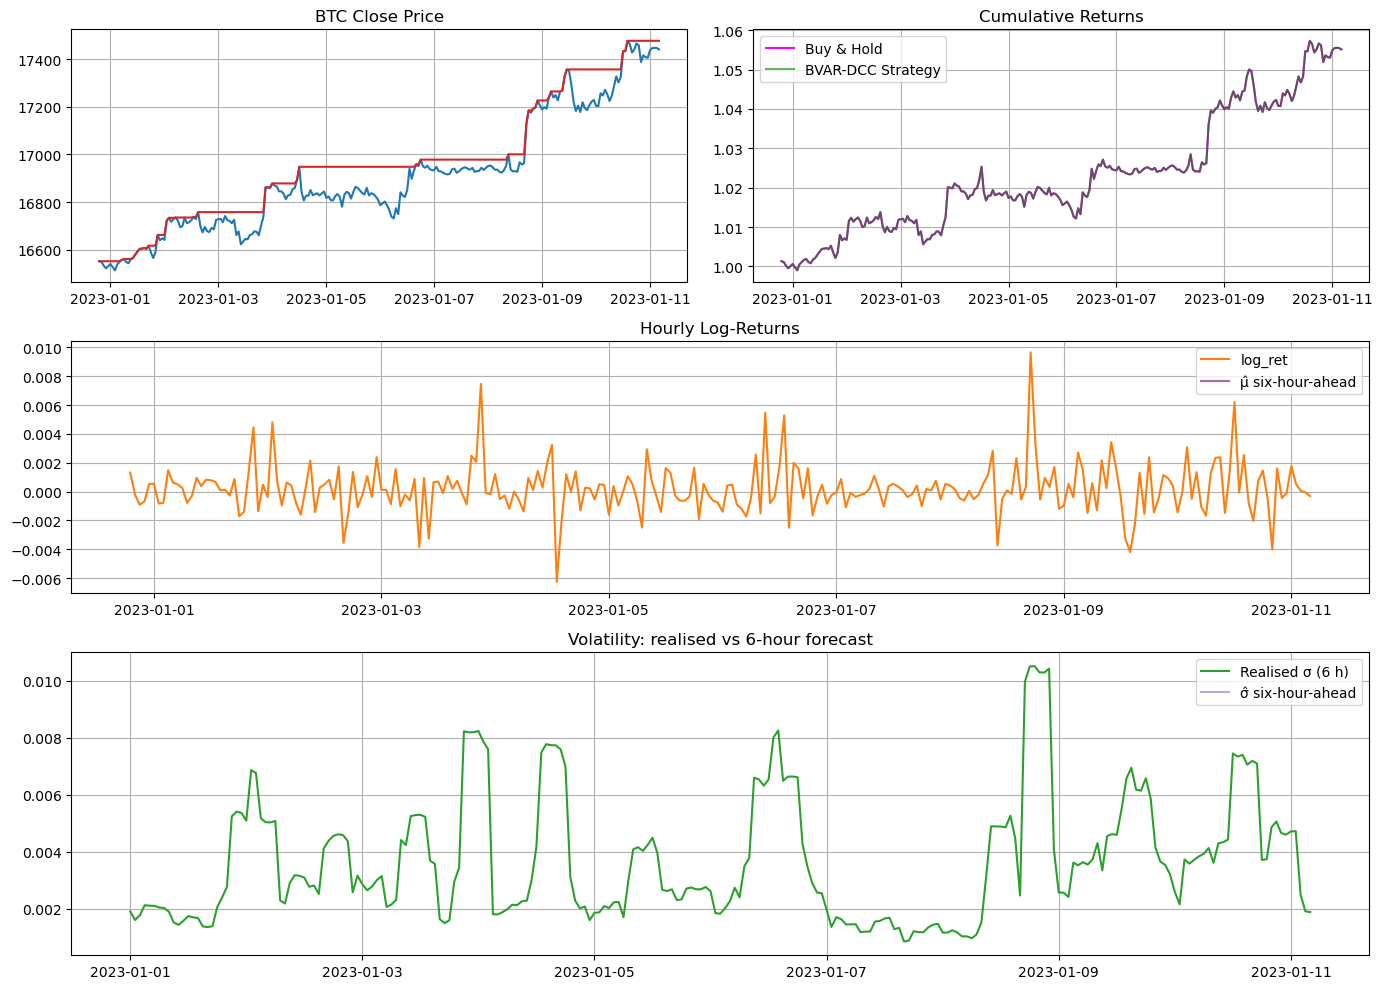

250 | 2023-01-11 04:00:00-06:00 | Close 17,441.24 | Position 1.00 | Return -0.00031 | μ̂  nan | σ̂  nan | Reason: HOLD: no valid forecast


Initializing NUTS using adapt_diag...


KeyboardInterrupt: 

In [18]:
# Configuration
warnings.filterwarnings("ignore", category=UserWarning)
np.random.seed(42)

# ----------------- Helper Functions -------------------
def fit_bvar(y_vars, lag_order=3):  # Reduced lag order for stability
    """Simplified Bayesian VAR implementation"""
    y = y_vars.values
    n, m = y.shape
    
    with pm.Model() as bvar_model:
        # Hierarchical priors
        sigma = pm.HalfNormal('sigma', sigma=1, shape=m)
        beta_mu = pm.Normal('beta_mu', mu=0, sigma=1)
        beta_sd = pm.HalfNormal('beta_sd', sigma=1)
        beta = pm.Normal('beta', mu=beta_mu, sigma=beta_sd, 
                        shape=(lag_order, m, m))
        
        # Likelihood with reduced computational graph
        mu = pm.math.sum([
            pm.math.dot(beta[i], y[t-1-i]) 
            for i in range(lag_order) 
            for t in range(lag_order, n)
        ])
        
        pm.Normal('y', mu=mu, sigma=sigma, observed=y[lag_order:])
        
        # Faster sampling configuration
        trace = pm.sample(
            draws=200,  # Reduced samples
            tune=200,
            cores=1,    # Single core to avoid parallel issues
            target_accept=0.85,
            random_seed=42,
            init='adapt_diag'
        )
    
    return trace, bvar_model

def forecast_bvar(var_res, steps=6):
    """Generate forecasts from Bayesian VAR"""
    with var_res['model']:
        ppc = pm.sample_posterior_predictive(
            var_res['trace'],
            var_names=['beta', 'sigma'],
            random_seed=42
        )
        
        beta_samples = ppc.posterior['beta']
        sigma_samples = ppc.posterior['sigma']
        forecasts = np.zeros((steps, len(beta_samples.chain), len(beta_samples.draw), var_res['last_y'].shape[1]))
        last_obs = var_res['last_y'].copy()
        
        for step in range(steps):
            mu = np.einsum('ijk,kl->ijl', beta_samples, last_obs[-var_res['k_ar']:][::-1])
            forecasts[step] = mu + sigma_samples * np.random.randn(*mu.shape)
            last_obs = np.concatenate([last_obs, forecasts[step:step+1].mean(axis=(1,2))])
        
        return forecasts

def calculate_atr(high, low, close, window=14):
    """Calculate Average True Range"""
    high_low = high - low
    high_close = np.abs(high - close.shift())
    low_close = np.abs(low - close.shift())
    true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    return true_range.rolling(window).mean()

# ----------------- Initialization -------------------
# Walk-forward metrics
wf_metrics = {
    'window': [],
    'strat_return': [],
    'bh_return': [],
    'max_dd': []
}

# Containers for plotting and storage
ts_x, close_y, cummax_y, logret_y = [], [], [], []
realvol_y = []
fcst_x, fcst_y = [], []
mean_fcst_x, mean_fcst_y = [], []
cstrategy_y, creturns_y = [], []
results_log, decision_log, forecast_log = [], [], []
X_train = []

# State variables
mu_hist = deque(maxlen=2000)
s_hist = deque(maxlen=2000)
hold_ttl = 0
cooldown = 0
position = 1  # 1 = long, 0 = flat
cum_asset = 0.0
cum_strat = 0.0

# Model storage
var_res = None
garch_models = None

# ---------------- MAIN BACKTEST LOOP ----------------
for n, partial_df in enumerate(simulate_market(btc, delay=0.1), start=1):
    partial_df = partial_df.copy()
    partial_df['cummax'] = partial_df['close'].cummax()
    
    # Current market data
    latest = partial_df.iloc[-1]
    tstamp = latest.name
    prev_pos = position

    # ------ 1. Calculate Log Changes ------
    vol = partial_df['volume'].replace(0, np.nan)
    log_chg_open = np.log(partial_df['open'] / partial_df['open'].shift(1))
    log_chg_high = np.log(partial_df['high'] / partial_df['high'].shift(1))
    log_chg_low = np.log(partial_df['low'] / partial_df['low'].shift(1))
    log_chg_close = np.log(partial_df['close'] / partial_df['close'].shift(1))
    log_chg_volume = np.log(vol / vol.shift(1))

    X_train.append({
        'timestamp': tstamp,
        'open': log_chg_open.iloc[-1],
        'high': log_chg_high.iloc[-1],
        'low': log_chg_low.iloc[-1],
        'close': log_chg_close.iloc[-1],
        'volume': log_chg_volume.iloc[-1]
    })

    # ------ 2. Return Accrual ------
    cum_asset += log_chg_close.iloc[-1]
    cum_strat += prev_pos * log_chg_close.iloc[-1]
    creturns_y.append(np.exp(cum_asset))
    cstrategy_y.append(np.exp(cum_strat))

    # ------ 3. Realized Volatility ------
    realised = np.sqrt((log_chg_close**2).rolling(6).sum()).iloc[-1] if len(log_chg_close) >= 6 else np.nan
    
    # Book-keeping
    ts_x.append(tstamp)
    close_y.append(latest.close)
    logret_y.append(log_chg_close.iloc[-1])
    realvol_y.append(realised)
    cummax_y.append(partial_df['cummax'].iloc[-1])

    # ------ 4. Model Fitting ------
    df_train = pd.DataFrame(X_train).dropna()
    mu_6h = mu_block = vol_6h = mu_signal = np.nan
    
    min_sample = 300
    lookback = int(0.6 * len(df_train))
    N_update = 3

    if len(df_train) >= min_sample and n % N_update == 0:
        y_vars = df_train[['open', 'high', 'low', 'close', 'volume']].dropna().iloc[-lookback:]
        y_vars = y_vars.replace([np.inf, -np.inf], np.nan).dropna()

        # Fit BVAR
        try:
            trace, bvar_model = fit_bvar(y_vars, lag_order=6)
            var_res = {
                'trace': trace,
                'model': bvar_model,
                'last_y': y_vars.values[-6:],
                'k_ar': 6
            }
        except Exception as e:
            print(f"BVAR fitting failed: {str(e)}")
            var_res = None

        # Fit GARCH models
        try:
            if var_res is not None:
                # Get residuals
                forecasts = forecast_bvar(var_res, steps=1)
                pred_return = forecasts.mean(axis=(1,2))[0][y_vars.columns.get_loc('close')]
                resids = pd.Series([(y_vars['close'].iloc[-1] - pred_return) * 1000])
                
                garch_models = {}
                for col in y_vars.columns:
                    am = ConstantMean(y_vars[col] * 1000)
                    am.volatility = GARCH(p=1, q=1)
                    am.distribution = StudentsT()
                    garch_models[col] = am.fit(disp='off', update_freq=10)
                
                # DCC estimation
                std_resids = pd.DataFrame({k: v.resid / v.conditional_volatility 
                                        for k, v in garch_models.items()})
                corr = std_resids.ewm(alpha=0.06).cov()
                
                if 'close' in garch_models:
                    vol_6h = np.sqrt(
                        np.clip(corr.iloc[-1].loc['close','close'], 0.01, 0.99) * 
                        np.clip(garch_models['close'].forecast(horizon=6).variance.iloc[-1].sum(), 1e-6, np.inf)
                    ) / 1000
        except Exception as e:
            print(f"GARCH fitting failed: {str(e)}")
            garch_models = None

    # ------ 5. Forecasting ------
    if var_res is not None:
        try:
            forecasts = forecast_bvar(var_res, steps=6)
            mu_path = forecasts.mean(axis=(1,2))
            idx_close = df_train.columns.get_loc('close')
            mu_vec = mu_path[:, idx_close]
            mu_6h = mu_vec[-1]
            mu_block = mu_vec.sum()
            mu_signal = mu_block
        except Exception as e:
            print(f"Forecasting failed: {str(e)}")

    # ------ 6. Dynamic Risk Management ------
    # Volatility regime detection
    λ = 0.94
    alpha = 1 - λ
    target_exp = 0.008
    k = 1.5
    min_obs = 30
    
    rv = pd.Series(realvol_y).dropna()
    if len(rv) >= min_obs:
        stats = rv.ewm(alpha=alpha, adjust=False)
        ewma_mean = stats.mean().iloc[-1]
        ewma_sd = np.sqrt(stats.var(bias=False).iloc[-1])
        sigma_cut = max(target_exp, ewma_mean + k * ewma_sd)
    else:
        sigma_cut = target_exp
    
    # Signal processing
    if np.isfinite(mu_signal):
        mu_hist.append(mu_signal)
    
    s = mu_signal / (vol_6h + 1e-12) if np.isfinite(vol_6h) else np.nan
    
    if np.isfinite(s):
        s_hist.append(s)
    
    s_eps = np.quantile(np.abs(s_hist), 0.40) if len(s_hist) >= 200 else 0.10

    # ------ 7. Trading Decision ------
    close_price = latest.close
    cummax = partial_df['cummax'].iloc[-1]
    atr = calculate_atr(partial_df['high'], partial_df['low'], partial_df['close']).iloc[-1]
    
    # Dynamic trailing stop
    vol_scaled_dd = np.clip(0.01 + 3*realised, 0.01, 0.1) if np.isfinite(realised) else 0.02
    trail_threshold = cummax * (1 - vol_scaled_dd)
    safety_stop = close_price - 2 * atr
    trail_threshold = min(trail_threshold, safety_stop)
    trail_break = close_price < trail_threshold
    
    # Position management
    if cooldown > 0:
        cooldown -= 1
    
    if hold_ttl > 0:
        hold_ttl = max(hold_ttl - 1, 0)
    
    new_pos = position
    reason = "HOLD: no valid forecast"
    
    if np.isfinite(mu_signal) and np.isfinite(vol_6h):
        # Dynamic position sizing
        raw_size = np.clip(s / (2 * s_eps), 0, 1)
        vol_scale = np.clip(1 / (vol_6h + 1e-6), 0.5, 2)
        position_size = raw_size * vol_scale
        
        emergency_flat = trail_break and (s <= s_eps/2 or mu_signal < -abs(s_eps)*vol_6h)
        
        if emergency_flat and cooldown == 0:
            new_pos = 0
            reason = f"FLAT: emergency (s={s:.2f})"
        elif hold_ttl > 0:
            new_pos = position_size
            if s > s_eps:
                hold_ttl = 6
            reason = f"HOLD-LONG: size={position_size:.2f}, TTL={hold_ttl}"
        elif s > s_eps and cooldown == 0:
            new_pos = position_size
            hold_ttl = 6
            reason = f"LONG: size={position_size:.2f}"
        elif s < -s_eps and vol_6h > sigma_cut and cooldown == 0:
            new_pos = 0
            reason = f"FLAT: s={s:.2f} < -s_eps"
        else:
            new_pos = position_size * 0.5
            reason = f"CAUTIOUS: size={position_size:.2f}"
    
    if int(new_pos) != int(position):
        cooldown = 2
    position = new_pos

    # ------ 8. Logging ------
    decision_log.append({
        "timestamp": tstamp,
        "prev_position": prev_pos,
        "new_position": new_pos,
        "position_size": position_size if 'position_size' in locals() else position,
        "cooldown": cooldown,
        "hold_ttl": hold_ttl,
        "mu_blk": mu_signal,
        "sigma_cut": sigma_cut,
        "vol_6h": vol_6h,
        "close": close_price,
        "cummax": cummax,
        "trail_threshold": trail_threshold,
        "reason": reason,
        "s": s,
        "s_eps": s_eps,
        "atr": atr
    })
    
    results_log.append({
        "timestamp": tstamp,
        "close": close_price,
        "log_ret": log_chg_close.iloc[-1],
        "realized_vol": realised,
        "forecasted_vol": vol_6h if np.isfinite(vol_6h) else np.nan,
        "forecasted_mu": mu_signal if np.isfinite(mu_signal) else np.nan,
        "position": position,
        "position_size": position_size if 'position_size' in locals() else position,
        "cum_asset": cum_asset,
        "cum_strat": cum_strat,
        "atr": atr,
        "model_version": "BVAR-DCC-v1"
    })

    # ------ 9. Walk-Forward Validation ------
    if n % 168 == 0 and n >= 1000:  # Weekly evaluation after initial window
        window_start = n - 1000
        window_end = n
        
        if len(results_log) > window_end:
            window_df = pd.DataFrame(results_log[window_start:window_end])
            strat_returns = window_df['log_ret'] * window_df['position']
            
            wf_metrics['window'].append(window_end)
            wf_metrics['strat_return'].append(np.exp(strat_returns.sum()) - 1)
            wf_metrics['bh_return'].append(np.exp(window_df['log_ret'].sum()) - 1)
            wf_metrics['max_dd'].append(
                (np.exp(strat_returns.cumsum()) / np.exp(strat_returns.cumsum()).cummax() - 1).min()
            )

    # ------ 10. Visualization ------
    if n % 50 == 0:  # Update plots every 50 iterations
        clear_output(wait=True)
        fig = plt.figure(figsize=(14, 10))
        gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1.2])
        
        # Price Plot
        ax1 = fig.add_subplot(gs[0, 0])
        ax1.plot(ts_x, close_y, color="tab:blue")
        ax1.plot(ts_x, cummax_y, color="tab:red")
        ax1.set_title("BTC Close Price")
        ax1.grid(True)
        
        # Cumulative Returns
        ax2 = fig.add_subplot(gs[0, 1])
        ax2.plot(ts_x, creturns_y, label="Buy & Hold", color="magenta")
        ax2.plot(ts_x, cstrategy_y, label="BVAR-DCC Strategy", color="green", alpha=0.6)
        ax2.set_title("Cumulative Returns")
        ax2.legend()
        ax2.grid(True)
        
        # Log Returns
        ax3 = fig.add_subplot(gs[1, :])
        ax3.plot(ts_x, logret_y, color="tab:orange", label="log_ret")
        ax3.plot(mean_fcst_x, mean_fcst_y, color="purple", label="μ̂ six-hour-ahead", alpha=0.6)
        ax3.set_title("Hourly Log-Returns")
        ax3.legend()
        ax3.grid(True)
        
        # Volatility
        ax4 = fig.add_subplot(gs[2, :])
        ax4.plot(ts_x, realvol_y, color="tab:green", label="Realised σ (6 h)")
        ax4.plot(fcst_x, fcst_y, color="tab:purple", label="σ̂ six-hour-ahead", alpha=0.6)
        ax4.set_title("Volatility: realised vs 6-hour forecast")
        ax4.legend()
        ax4.grid(True)
        
        plt.tight_layout()
        plt.show()

        print(f"{n:3d} | {tstamp} | Close {latest.close:,.2f} | "
              f"Position {position:.2f} | Return {log_chg_close.iloc[-1]: .5f} | "
              f"μ̂ {mu_signal if np.isfinite(mu_signal) else np.nan: .5f} | "
              f"σ̂ {vol_6h if np.isfinite(vol_6h) else np.nan: .5f} | "
              f"Reason: {reason}")

    # Clean up memory
    if n % 100 == 0:
        import gc
        gc.collect()

    # Exit condition
    if os.path.exists("exit.flag"):
        print("Exit flag detected - stopping.")
        break

# ----------------- Post Processing -----------------
# Create final DataFrames
df_results = pd.DataFrame(results_log).set_index("timestamp").sort_index()
df_results.index = df_results.index.floor("h")

df_final = df_results.groupby(level=0).agg({
    'close': 'first',
    'log_ret': 'first',
    'realized_vol': 'first',
    'forecasted_vol': 'last',
    'forecasted_mu': 'last',
    'position': 'last',
    'position_size': 'last',
    'cum_asset': 'last',
    'cum_strat': 'last',
    'atr': 'last'
}).sort_index()

df_decision_log = pd.DataFrame(decision_log).set_index("timestamp").sort_index()
df_forecasts = pd.DataFrame(forecast_log)
if not df_forecasts.empty and 'target_ts' in df_forecasts.columns:
    df_forecasts = df_forecasts.set_index('target_ts').sort_index()

# Print final performance
strat_returns = df_final['log_ret'] * df_final['position']
total_strat_return = np.exp(strat_returns.sum()) - 1
total_bh_return = np.exp(df_final['log_ret'].sum()) - 1

print(f"\nFinal Performance:")
print(f"Strategy Return: {total_strat_return:.2%}")
print(f"Buy & Hold Return: {total_bh_return:.2%}")
print(f"Max Drawdown: {(np.exp(strat_returns.cumsum()) / np.exp(strat_returns.cumsum()).cummax() - 1).min():.2%}")

### v.09 (Deepseek)

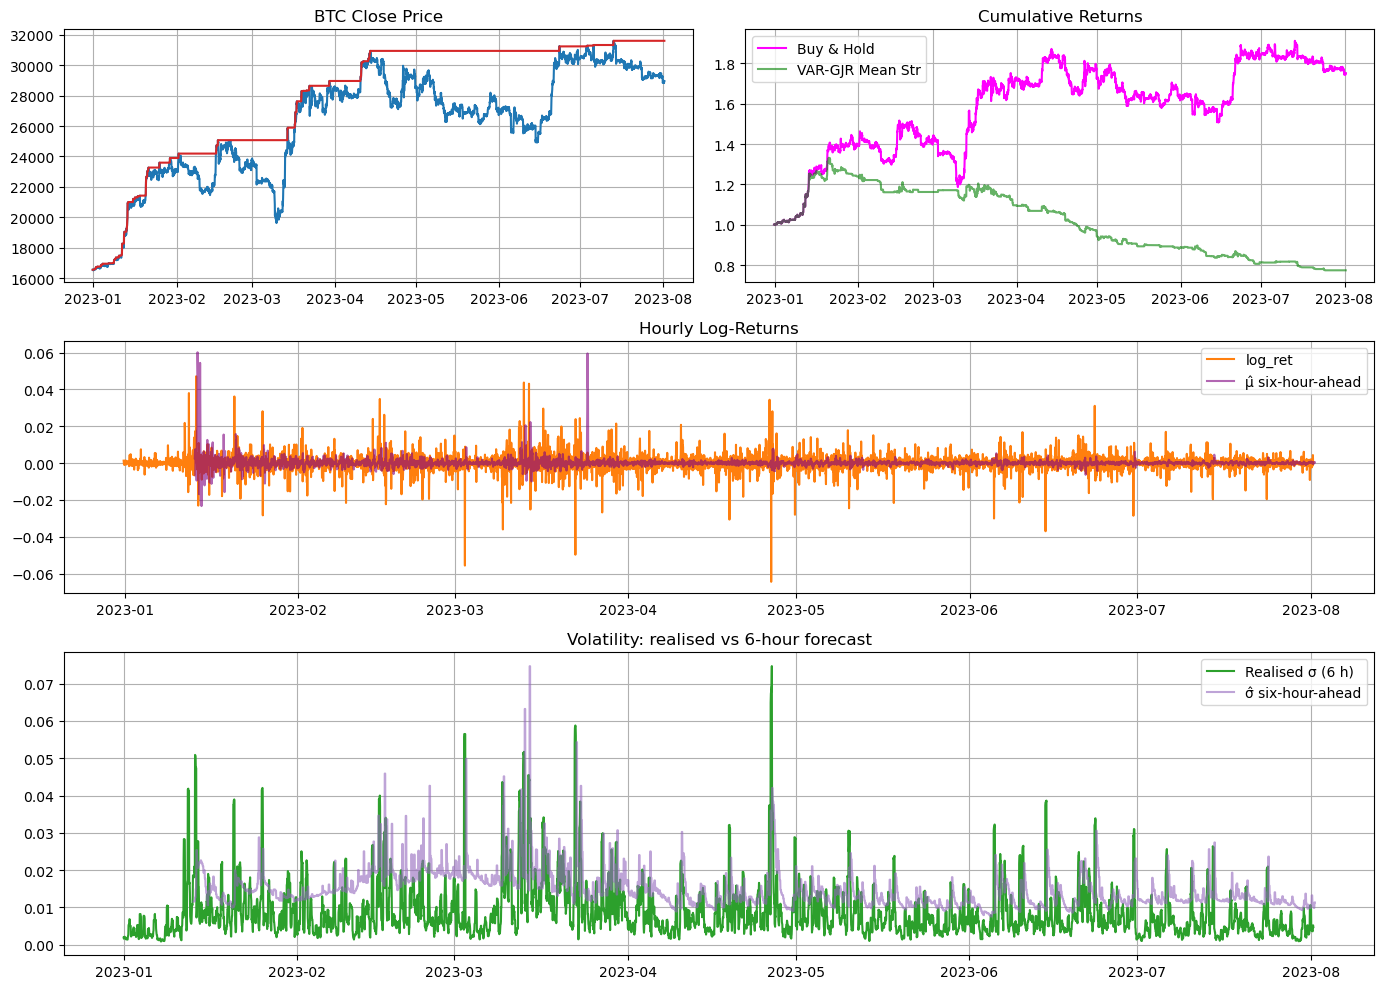

5105 | 2023-08-01 11:00:00-06:00 | Close 28,954.01 | trail 30,834.25 | r  0.00062 | RV_blk  0.00471 | μ_blk  0.00039 | σ_blk  0.01134 | s  0.025 | pos 0 | TIM(200)=0.02 | flips/w~0
Exit flag detected—stopping.


In [42]:
# --- parameters -------------------------------------------------------
N_UPDATE       = 3           # refit models every N bars
MIN_SAMPLE     = 300         # min obs to start modeling
LOOKBACK_CAP   = 4000        # safety cap when data grows
FEE            = 0.00075     # taker ~7.5 bps one side (adjust to your acct)
PCTL_ON        = 0.35        # s-quantile for ON threshold (controls time-in-market)
HYSTERESIS_OFF = 0.60        # s_off = HYSTERESIS_OFF * s_on
# MOM_THRESHOLD  = 0.015        # 24h momentum gate (2%)
SIGMA_FLOOR    = 0.005       # floor for sigma_cut when little history
K_SMOOTH       = True        # Kalman-smooth μ? (set False to disable)

MOM_Z = 0.60   # z-threshold for 24h momentum (try 0.6–0.8)
STRONG_TREND_Z = 0.90
S_WIN   = 300    # new: rolling window for |s| quantile (~2 weeks of hours)
flipped        = False
score_below_cnt = 0

# --- Kalman state (for μ smoothing) ----------------------------------
kf_m, kf_P = 0.0, 1.0   # mean and covariance

# ----------------- INITIALIZATION ------------------------------------
ts_x, close_y, cummax_y, logret_y = [], [], [], []
realvol_y = []
fcst_x, fcst_y = [], []
cstrategy_y, creturns_y = [], []
mean_fcst_x, mean_fcst_y = [], []

results_log, decision_log, forecast_log = [], [], []
X_train = []

mu_hist = deque(maxlen=2000)
s_hist  = deque(maxlen=2000)

position   = 1
started_trading = False
t0_trade = None


cum_asset  = 0.0
cum_strat  = 0.0
cooldown   = 3

var_res  = None
lag_order = None
g_mod     = None

# -------------- MAIN BACKTEST LOOP -----------------------------------
for n, partial_df in enumerate(simulate_market(btc, delay=0.1), start=1):
    partial_df = partial_df.copy()
    latest  = partial_df.iloc[-1]
    tstamp  = latest.name
    prev_pos = position

    # cooldown tick
    if cooldown > 0:
        cooldown -= 1

    # ------ 1) DATA PREP ---------------------------------------------
    partial_df['cummax'] = partial_df['close'].cummax()
    vol = partial_df['volume'].replace(0, np.nan)

    log_chg_open   = np.log(partial_df['open']   / partial_df['open'].shift(1))
    log_chg_high   = np.log(partial_df['high']   / partial_df['high'].shift(1))
    log_chg_low    = np.log(partial_df['low']    / partial_df['low'].shift(1))
    log_chg_close  = np.log(partial_df['close']  / partial_df['close'].shift(1))
    log_chg_volume = np.log(vol / vol.shift(1))

    # ------ 2) RETURN ACCRUAL ----------------------------------------
    r_1h = log_chg_close.iloc[-1]
    cum_asset += r_1h
    cum_strat += prev_pos * r_1h
    creturns_y.append(np.exp(cum_asset))
    cstrategy_y.append(np.exp(cum_strat))

    # ------ 3) REALIZED BLOCK VOL (6h) -------------------------------
    if len(log_chg_close) >= 6:
        real_vol_block = np.sqrt((log_chg_close**2).rolling(6).sum()).iloc[-1]
    else:
        real_vol_block = np.nan

    # book-keeping for plots
    ts_x.append(tstamp)
    close_y.append(float(latest.close))
    cummax = float(partial_df['cummax'].iloc[-1])
    cummax_y.append(cummax)
    logret_y.append(r_1h)
    realvol_y.append(real_vol_block)

    results_log.append(dict(
        timestamp=tstamp, close=float(latest.close), log_ret=r_1h,
        realized_vol=real_vol_block, forecasted_vol=np.nan, forecasted_mu=np.nan,
        position=position, cum_asset=cum_asset, cum_strat=cum_strat
    ))

    # ------ 4) TRAILING STOP SETUP -----------------------------------
    # width adapts to recent realized block vol
    rv_now = real_vol_block if np.isfinite(real_vol_block) else 0.015
    dd_pct = np.clip(0.015 + 2.0 * rv_now, 0.015, 0.08)
    trail_threshold = cummax * (1 - dd_pct)
    trail_break = float(latest.close) < trail_threshold

    # ------ 5) TRAIN MODELS (every N_UPDATE) -------------------------
    X_train.append({
        'timestamp': tstamp,
        'open':   log_chg_open.iloc[-1],
        'high':   log_chg_high.iloc[-1],
        'low':    log_chg_low.iloc[-1],
        'close':  log_chg_close.iloc[-1],
        'volume': log_chg_volume.iloc[-1],
    })
    df_train = pd.DataFrame(X_train).dropna()
    lookback = min(LOOKBACK_CAP, int(0.6 * len(df_train)))

    if len(df_train) >= MIN_SAMPLE and n % N_UPDATE == 0:
        y_vars = df_train[['open','high','low','close','volume']].iloc[-lookback:]
        y_vars = y_vars.replace([np.inf,-np.inf], np.nan).dropna()

        # VAR on returns
        var_model = VAR(y_vars)
        var_res   = var_model.fit(maxlags=6, trend='n')   # returns => no intercept
        lag_order = var_res.k_ar

        # GJR-GARCH for asymmetry (stable & simple)

        resids_dec = var_res.resid['close'].dropna().to_numpy().astype(float)         # decimal
        resids_pct = resids_dec * 100.0                                               # percent
        print("std(resids, %):", resids_pct.std())  # expect ~0.1–1.5 for BTC 1h depending on regime

        g_mod = arch_model(
            resids_pct,
            mean='Zero',
            vol='GARCH',  # add o=1 for GJR if you want asymmetry
            p=1, o=1 ,q=1,
            dist='t',
            rescale=False
        ).fit(disp='off')


    # ------ 6) FORECASTS ---------------------------------------------
    mu_block = np.nan
    vol_6h   = np.nan

    if (var_res is not None) and (lag_order is not None):
        y_vars = df_train[['open','high','low','close','volume']].dropna().iloc[-lookback:]
        if len(y_vars) >= lag_order:
            mu_path   = var_res.forecast(y_vars.values[-lag_order:], steps=6)
            idx_close = y_vars.columns.get_loc('close')
            mu_block  = float(mu_path[:, idx_close].sum()) # 6h cumulative

    if (g_mod is not None) and g_mod.optimization_result.success:


        g_f    = g_mod.forecast(horizon=6, reindex=False)
        h_pct2 = np.asarray(g_f.variance.values[-1], dtype=float)       # shape (6,), variance in %^2
        sigma1h_pct = np.sqrt(h_pct2)                                    # 1h σ in %
        sigma1h_med_pct = float(np.median(sigma1h_pct))
        vol_6h = float(np.sqrt(h_pct2.sum()) / 100.0)                    # 6h block σ in decimal

        print("σ̂_1h(median, %):", sigma1h_med_pct)
        print("σ̂_6h(decimal):", vol_6h)

    has_fcst = np.isfinite(mu_block) and np.isfinite(vol_6h)

    # activate live trading only after first valid forecast
    if (not started_trading) and has_fcst:
        started_trading = True

    # ------ 7) (optional) KALMAN SMOOTH μ ----------------------------
    mu_for_score = mu_block
    if K_SMOOTH and np.isfinite(mu_block):
        mu_hist.append(mu_block)
        R = np.nanvar(list(mu_hist)[-200:]) if len(mu_hist) >= 50 else 1e-6  # obs var
        Q = 0.15 * R                                                         # process var
        kf_P = kf_P + Q
        K    = kf_P / (kf_P + R + 1e-12)
        kf_m = kf_m + K * (mu_block - kf_m)
        kf_P = (1 - K) * kf_P
        mu_for_score = float(kf_m)

    # ------ 8) DYNAMIC σ_CUT & SCORE ---------------------------------
    rv_series = pd.Series(realvol_y).dropna()
    if len(rv_series) >= 30:
        ewma = rv_series.ewm(alpha=1-0.94, adjust=False)
        ewma_mean = ewma.mean().iloc[-1]
        ewma_sd   = np.sqrt(ewma.var().iloc[-1])
        sigma_cut = max(SIGMA_FLOOR, ewma_mean + 1.5 * ewma_sd)
    else:
        sigma_cut = SIGMA_FLOOR

    s = (mu_for_score / (vol_6h + 1e-12)) if (np.isfinite(mu_for_score) and np.isfinite(vol_6h)) else np.nan
    if np.isfinite(s):
        s_hist.append(s)

    if len(s_hist) >= 60:
        s_window = np.abs(list(s_hist)[-S_WIN:])         # last S_WIN scores, abs
        s_on = np.quantile(s_window, PCTL_ON)            # adaptive ON threshold
    else:
        s_on = 0.06                                      # gentler default than 0.12
    s_off = HYSTERESIS_OFF * s_on


    # ------ 9) REGIME & MOMENTUM GATES -------------------------------
    n = len(partial_df)

    ema72  = partial_df['close'].ewm(span=72,  adjust=False).mean().iloc[-1] if n >= 72  else np.nan
    ema168 = partial_df['close'].ewm(span=168, adjust=False).mean().iloc[-1] if n >= 168 else np.nan
    ema336 = partial_df['close'].ewm(span=336, adjust=False).mean().iloc[-1] if n >= 336 else np.nan

    if n < 168:
        # warm-up: single filter
        trend_ok = (latest.close > ema72) if np.isfinite(ema72) else False
    elif n < 336:
        # mid warm-up: two-stack
        trend_ok = (latest.close > ema72) and (ema72 > ema168)
    else:
        # full regime: three-stack
        trend_ok = (latest.close > ema72) and (ema72 > ema168) and (ema168 > ema336)


    # 24h simple momentum in decimal
    mom_24h = (latest.close / partial_df['close'].iloc[-24] - 1) if len(partial_df) >= 24 else 0.0

    # convert a 6h sigma to 24h sigma (fallback to realized if forecast missing)
    rv_now_safe = rv_now if np.isfinite(rv_now) else 0.01
    sig_24h = (np.sqrt(4) * vol_6h) if np.isfinite(vol_6h) else (np.sqrt(4) * rv_now_safe)

    # z-scored momentum gate
    mom_z  = mom_24h / (sig_24h + 1e-12)
    mom_ok = mom_z > MOM_Z


    risk_off = np.isfinite(vol_6h) and (vol_6h > sigma_cut)
    one_h_sigma = (vol_6h / np.sqrt(6)) if np.isfinite(vol_6h) else np.nan

    # ------ 10) STATE MACHINE (long-only) ----------------------------
    if not started_trading or not has_fcst:
        # no new entries without a forecast; allow emergency exits only
        new_pos, reason = position, "HOLD: no forecast"

    else:
        new_pos, reason = position, "HOLD"

        # entry gates (computed regardless of pos so 'reason' can reference them)
        strong_trend = trend_ok and (mom_z > STRONG_TREND_Z) and (not risk_off)
        score_ok     = np.isfinite(s) and (s > s_on) and (not risk_off)

        if position == 1:
            # exits: trailing stop, risk spike, regime flip, or score fades (2-bar persistence)
            score_low = np.isfinite(s) and (s < s_off)
            score_below_cnt = score_below_cnt + 1 if score_low else 0
            score_trigger = score_below_cnt >= 2

            if trail_break or risk_off or (not trend_ok) or score_trigger:
                new_pos = 0
                reason  = (f"EXIT: trail={trail_break}, risk_off={risk_off}, "
                        f"trend={trend_ok}, s<{s_off:.3f} ({score_below_cnt})")
        else:
            # flat: reset the streak and check entries
            score_below_cnt = 0
            if (cooldown == 0) and (score_ok or strong_trend):
                new_pos = 1
                reason  = f"ENTER: {'score' if score_ok else 'trend'} gate"

    # apply flip (fees + cooldown)
    flipped = (int(new_pos) != int(position))
    if flipped:
        cum_strat -= FEE
        cooldown   = 2
    position = int(new_pos)

    # ------ 11) STORE FORECAST ROWS ----------------------------------
    if np.isfinite(vol_6h) and np.isfinite(mu_block):
        future_ts = tstamp + pd.Timedelta(hours=6)
        fcst_x.append(future_ts);  fcst_y.append(vol_6h)
        mean_fcst_x.append(future_ts); mean_fcst_y.append(mu_block)

        results_log.append(dict(
            timestamp=future_ts, close=np.nan, log_ret=np.nan, realized_vol=np.nan,
            forecasted_vol=vol_6h, forecasted_mu=mu_block, position=np.nan,
            cum_asset=np.nan, cum_strat=np.nan
        ))
        forecast_log.append(dict(
            origin_ts=tstamp, target_ts=future_ts,
            forecasted_vol=vol_6h, forecasted_mu=mu_block
        ))

    # ------ 12) DECISION LOG -----------------------------------------
    decision_log.append({
        "timestamp": tstamp,
        "prev_position": prev_pos,
        "new_position": position,
        "cooldown": cooldown,
        "mu_blk": mu_block,
        "mu_smooth": mu_for_score,
        "sigma_cut": sigma_cut,
        "vol_6h": vol_6h,
        "close": float(latest.close),
        "cummax": cummax,
        "trail_threshold": trail_threshold,
        "reason": reason,
        "s": s,
        "s_on": s_on,
        "s_off": s_off,
        "trend_ok": bool(trend_ok),
        "mom_24h": mom_24h,
        "risk_off": bool(risk_off),
        "flip_fee": FEE if flipped else 0.0,
        "mom_z": float(mom_z),
        "score_ok": bool(np.isfinite(s) and s > s_on),
        "regime_ok": bool(trend_ok and not risk_off),
    })

    # ------ 13) PLOT --------------------------------------------------
    clear_output(wait=True)
    fig = plt.figure(figsize=(14, 10))
    gs  = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1.2])

    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(ts_x, close_y, color="tab:blue")
    ax1.plot(ts_x, cummax_y, color="tab:red")
    ax1.set_title("BTC Close Price"); ax1.grid(True)

    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(ts_x, creturns_y,  label="Buy & Hold", color="magenta")
    ax2.plot(ts_x, cstrategy_y, label="VAR-GJR Mean Str", color="green", alpha=0.6)
    ax2.set_title("Cumulative Returns"); ax2.legend(); ax2.grid(True)

    ax3 = fig.add_subplot(gs[1, :])
    ax3.plot(ts_x, logret_y, color="tab:orange", label="log_ret")
    ax3.plot(mean_fcst_x, mean_fcst_y, color="purple", label="μ̂ six-hour-ahead", alpha=0.6)
    ax3.set_title("Hourly Log-Returns"); ax3.legend(); ax3.grid(True)

    ax4 = fig.add_subplot(gs[2, :])
    ax4.plot(ts_x, realvol_y, color="tab:green", label="Realised σ (6 h)")
    ax4.plot(fcst_x, fcst_y, color="tab:purple", label="σ̂ six-hour-ahead", alpha=0.6)
    ax4.set_title("Volatility: realised vs 6-hour forecast")
    ax4.legend(); ax4.grid(True)

    plt.tight_layout(); plt.show()

    # quick telemetry
    window = min(200, len(decision_log))
    tim = np.mean([d["new_position"] for d in decision_log[-window:]]) if window else np.nan
    flips_week = sum(int(decision_log[i]["new_position"] != decision_log[i-1]["new_position"])
                     for i in range(max(1, len(decision_log)-168), len(decision_log)))
    print(f"{n:4d} | {tstamp} | Close {latest.close:,.2f} | trail {trail_threshold:,.2f} | "
          f"r {r_1h: .5f} | RV_blk {rv_now: .5f} | μ_blk {mu_block: .5f} | σ_blk {vol_6h: .5f} | "
          f"s {s if np.isfinite(s) else np.nan: .3f} | pos {position} | TIM(200)={tim:.2f} | flips/w~{flips_week}")

    # Auto-stop
    if os.path.exists("exit.flag"):
        print("Exit flag detected—stopping.")
        break
    # if n == 5000: break

# ------------------------- FINAL DFs ---------------------------------
df_results = (pd.DataFrame(results_log)
                .set_index("timestamp")
                .sort_index())

df_results.index = df_results.index.floor("h")

df_final = (df_results
    .groupby(level=0)
    .agg(
        close          = ('close',          'first'),
        log_ret        = ('log_ret',        'first'),
        realized_vol   = ('realized_vol',   'first'),
        forecasted_vol = ('forecasted_vol', 'last'),
        forecasted_mu  = ('forecasted_mu',  'last'),
        position       = ('position',       'last'),
        cum_asset      = ('cum_asset',      'last'),
        cum_strat      = ('cum_strat',      'last'),
    )
    .sort_index()
)

df_log_changes = (pd.DataFrame(X_train)
                  .set_index("timestamp")
                  .sort_index())

df_forecasts = pd.DataFrame(forecast_log)
if df_forecasts.empty or 'target_ts' not in df_forecasts.columns:
    print("No forecast rows captured yet (df_forecasts is empty).")
    df_forecasts = (pd.DataFrame(columns=['origin_ts','forecasted_vol','forecasted_mu'])
                    .set_index(pd.DatetimeIndex([], name='target_ts')))
else:
    df_forecasts = df_forecasts.set_index('target_ts').sort_index()

df_decision_log = (pd.DataFrame(decision_log)
                   .set_index("timestamp")
                   .sort_index())


### Analysis

In [45]:
# Build a single frame to analyze decisions vs forward returns
A = df_decision_log.copy()

# bring position & 1h returns from df_final (align on the hour index)
A = A.join(df_final[['position','log_ret']], how='left')

# forward returns: next 1h and next 6h (bars t+1..t+6)
A['fwd_1h'] = A['log_ret'].shift(-1)
A['fwd_6h'] = A['log_ret'].shift(-1).rolling(6).sum().shift(-5)

# useful flags
A['score_ok'] = np.isfinite(A['s']) & (A['s'] > A['s_on']) & (~A['risk_off'])
A['score_low'] = np.isfinite(A['s']) & (A['s'] < A['s_off'])
A['flat'] = (A['position'] == 0)
A['long'] = (A['position'] == 1)

# exit/enter markers (bar where flip happened)
A['flip'] = A['position'].diff().fillna(0).astype(int)
A['exit_bar']  = (A['flip'] == -1)
A['enter_bar'] = (A['flip'] ==  1)

# categorize exit reason (rough bucket)
def bucket_reason(r):
    r = str(r)
    if 'risk_off=True' in r: return 'risk_off'
    if 'trail=True'    in r: return 'trailing_stop'
    if 'trend=False'   in r: return 'regime_flip'
    if 's<'            in r: return 'score_fade'
    if r.startswith('HOLD: no forecast'): return 'no_fcst'
    return 'other'
A['exit_bucket'] = np.where(A['exit_bar'], A['reason'].map(bucket_reason), np.nan)


#### 1) Does the score actually predict next returns?

In [49]:
print("Corr(s, fwd_6h):", A[['s','fwd_6h']].dropna().corr().iloc[0,1])
print("Hit rate 1h (sign match):", np.mean(np.sign(A['s']) == np.sign(A['fwd_1h'])))
print("Hit rate 6h (sign match):", np.mean(np.sign(A['s']) == np.sign(A['fwd_6h'])))

# monotonicity: average future return by |s| decile
A['s_abs'] = A['s'].abs()
A['s_bin'] = pd.qcut(A['s_abs'], q=10, duplicates='drop')
print(A.groupby('s_bin')['fwd_6h'].agg(['count','mean','median']))


Corr(s, fwd_6h): -0.005319240632207968
Hit rate 1h (sign match): 0.4772727272727273
Hit rate 6h (sign match): 0.4727664576802508
                       count      mean    median
s_bin                                           
(-0.0009884, 0.00386]    480  0.000031  0.000065
(0.00386, 0.00839]       478  0.000064 -0.000165
(0.00839, 0.0134]        481  0.000703 -0.000031
(0.0134, 0.0187]         479  0.000796  0.000436
(0.0187, 0.0242]         480  0.000910  0.000184
(0.0242, 0.0319]         479  0.000017  0.000020
(0.0319, 0.0423]         480  0.000482  0.000290
(0.0423, 0.0573]         481  0.000272 -0.000481
(0.0573, 0.0888]         480  0.000425 -0.000035
(0.0888, 2.387]          481  0.001501  0.000182


C:\Users\axeld\AppData\Local\Temp\ipykernel_25436\3338114679.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(A.groupby('s_bin')['fwd_6h'].agg(['count','mean','median']))


#### 2) “Missed upside” while flat even though gates were open

In [50]:
# Bars where we are FLAT but score & regime say it's ok to be long
mask_open_but_flat = A['flat'] & A['trend_ok'] & (~A['risk_off']) & A['score_ok']

print("Share of bars open-but-flat:", mask_open_but_flat.mean())
print("Avg fwd_6h when open-but-flat:", A.loc[mask_open_but_flat, 'fwd_6h'].mean())
print("Median fwd_6h when open-but-flat:", A.loc[mask_open_but_flat, 'fwd_6h'].median())

# What blocked entries most often when we were flat?
block_counts = pd.DataFrame({
    'flat': A['flat'],
    'trend_ok': A['trend_ok'],
    'risk_off': A['risk_off'],
    'score_ok': A['score_ok'],
}).assign(
    blocker=np.select(
        [
            A['flat'] & (~A['trend_ok']),
            A['flat'] & A['trend_ok'] & A['risk_off'],
            A['flat'] & A['trend_ok'] & (~A['risk_off']) & (~A['score_ok']),
        ],
        ['trend_filter','risk_off','score_gate'],
        default='other'
    )
)['blocker'].value_counts()
print(block_counts)


Share of bars open-but-flat: 0.020963949843260186
Avg fwd_6h when open-but-flat: -0.00021940443673320172
Median fwd_6h when open-but-flat: -0.0012444857194346699
blocker
trend_filter    2997
other           1120
score_gate       653
risk_off         334
Name: count, dtype: int64


#### 3) Exits that hurt (immediate 6h after exit)

In [51]:
bad_exits = (A['exit_bar']) & (A['fwd_6h'] > 0)
print("Bad exits %:", bad_exits.mean())

print(A.loc[A['exit_bar']].groupby('exit_bucket')['fwd_6h']
         .agg(['count','mean','median'])
         .sort_values('mean'))


Bad exits %: 0.03742163009404389
             count      mean    median
exit_bucket                           
other          397  0.000409 -0.000273


#### 4) Trail stop width sanity

In [56]:
# Compare dd at exits vs next-6h return
cols = ['cummax','trail_threshold','close','fwd_6h','reason']
print(A.loc[A['exit_bar'] & A['reason'].str.contains('trail')][cols].tail(10))


Empty DataFrame
Columns: [cummax, trail_threshold, close, fwd_6h, reason]
Index: []


#### 5) Risk-off filter cost/benefit

In [55]:
print("Avg fwd_6h when risk_off==True:", A.loc[A['risk_off'], 'fwd_6h'].mean())
print("Avg fwd_6h when risk_off==False:", A.loc[~A['risk_off'], 'fwd_6h'].mean())

Avg fwd_6h when risk_off==True: -0.0005731604614764576
Avg fwd_6h when risk_off==False: 0.0013548791235646488


#### 6) Trend & momentum gate value

In [54]:
print("Avg fwd_6h | trend_ok:", A.loc[A['trend_ok'], 'fwd_6h'].mean())
print("Avg fwd_6h | trend_not_ok:", A.loc[~A['trend_ok'], 'fwd_6h'].mean())

# If you have z-scored momentum saved (mom_z); otherwise skip this block
if 'mom_z' in A.columns:
    print("Avg fwd_6h | mom_z>0 & trend_ok:", A.loc[A['trend_ok'] & (A['mom_z']>0), 'fwd_6h'].mean())
    print("Avg fwd_6h | mom_z>1 & trend_ok:", A.loc[A['trend_ok'] & (A['mom_z']>1), 'fwd_6h'].mean())


Avg fwd_6h | trend_ok: 0.0009411485725232669
Avg fwd_6h | trend_not_ok: 0.0005068250316738736
Avg fwd_6h | mom_z>0 & trend_ok: 0.0007323439714541733
Avg fwd_6h | mom_z>1 & trend_ok: 0.0036998658573207696


#### 7) Cooldown & score persistence (missed re-entries)

In [53]:
# Hours where cooldown>0 AND score_ok==True AND trend_ok & !risk_off (we were forced flat)
mask_cd_loss = (A['cooldown']>0) & A['flat'] & A['trend_ok'] & (~A['risk_off']) & A['score_ok']
print("Cooldown lost-opportunity (mean fwd_6h):", A.loc[mask_cd_loss, 'fwd_6h'].mean())

# Bars where we exited due to score_fade, but s bounced back above s_on on the very next bar
ex_score = A['exit_bar'] & A['reason'].str.contains('s<')
bounce = ex_score & (A['s'].shift(-1) > A['s_on'].shift(-1))
print("Score-fade followed by immediate bounce (count):", bounce.sum(),
      "| mean fwd_6h:", A.loc[bounce,'fwd_6h'].mean())


Cooldown lost-opportunity (mean fwd_6h): -0.00021940443673320172
Score-fade followed by immediate bounce (count): 0 | mean fwd_6h: nan


#### 8) Where does the strategy actually make/lose money?

In [52]:
# Contribution by state
print(pd.DataFrame({
    'long_mean_fwd6': [A.loc[A['long'], 'fwd_6h'].mean()],
    'flat_mean_fwd6': [A.loc[A['flat'], 'fwd_6h'].mean()],
    'long_share':     [A['long'].mean()],
}).T)

# Contribution by score strength when long
A_long = A[A['long'] & np.isfinite(A['s'])]
A_long['s_quint'] = pd.qcut(A_long['s'], 5, duplicates='drop')
print(A_long.groupby('s_quint')['fwd_6h'].agg(['count','mean','median']))


                       0
long_mean_fwd6  0.001467
flat_mean_fwd6  0.000456
long_share      0.198472
                    count      mean    median
s_quint                                      
(-0.424, -0.00574]    143  0.000720  0.000115
(-0.00574, 0.0192]    143 -0.001660 -0.001618
(0.0192, 0.0409]      142  0.002159  0.000591
(0.0409, 0.089]       143 -0.001505 -0.000838
(0.089, 2.387]        143  0.004735  0.002595


C:\Users\axeld\AppData\Local\Temp\ipykernel_25436\1995543326.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  A_long['s_quint'] = pd.qcut(A_long['s'], 5, duplicates='drop')
C:\Users\axeld\AppData\Local\Temp\ipykernel_25436\1995543326.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(A_long.groupby('s_quint')['fwd_6h'].agg(['count','mean','median']))


In [57]:
A = df_decision_log.join(df_final[['position','log_ret']], how='left')
A['fwd_6h'] = A['log_ret'].shift(-1).rolling(6).sum().shift(-5)

# Quantiles of |s|
Q = A['s'].abs().quantile([.7,.8,.9,.95,.98]).to_dict()
print("s_abs quantiles:", Q)

def mean_fwd(mask, name):
    print(f"{name:30s}  n={mask.sum():4d}  mean fwd_6h={A.loc[mask,'fwd_6h'].mean(): .6f}")

for qname, qv in Q.items():
    m = (A['s'].abs()>qv) & A['trend_ok'] & (~A['risk_off']) & (A['s']>0)
    mean_fwd(m, f"|s|>{qname} & trend_ok & s>0")

# Strong momentum tests (adjust z threshold if you like)
for z in (0.8, 1.0, 1.5, 2.0):
    m = A['trend_ok'] & (~A['risk_off']) & (A.get('mom_z', 0) > z)
    mean_fwd(m, f"trend_ok & mom_z>{z}")

# Confluence: moderate score + momentum
q80 = Q[0.8]
for z in (0.5, 0.8, 1.0):
    m = A['trend_ok'] & (~A['risk_off']) & (A['s']>0) & (A['s'].abs()>q80) & (A.get('mom_z', 0)>z)
    mean_fwd(m, f"|s|>q80 & mom_z>{z}")


s_abs quantiles: {0.7: 0.04226291816238083, 0.8: 0.057299824363870204, 0.9: 0.08883921676476894, 0.95: 0.12277148554681964, 0.98: 0.18369316580919642}
|s|>0.7 & trend_ok & s>0        n= 240  mean fwd_6h= 0.001670
|s|>0.8 & trend_ok & s>0        n= 197  mean fwd_6h= 0.002420
|s|>0.9 & trend_ok & s>0        n= 130  mean fwd_6h= 0.003832
|s|>0.95 & trend_ok & s>0       n=  90  mean fwd_6h= 0.003837
|s|>0.98 & trend_ok & s>0       n=  50  mean fwd_6h= 0.006842
trend_ok & mom_z>0.8            n= 389  mean fwd_6h= 0.002338
trend_ok & mom_z>1.0            n= 307  mean fwd_6h= 0.003734
trend_ok & mom_z>1.5            n= 171  mean fwd_6h= 0.005254
trend_ok & mom_z>2.0            n= 112  mean fwd_6h= 0.005471
|s|>q80 & mom_z>0.5             n=  96  mean fwd_6h= 0.004284
|s|>q80 & mom_z>0.8             n=  74  mean fwd_6h= 0.003757
|s|>q80 & mom_z>1.0             n=  62  mean fwd_6h= 0.003112


### v.09 ChatGPT

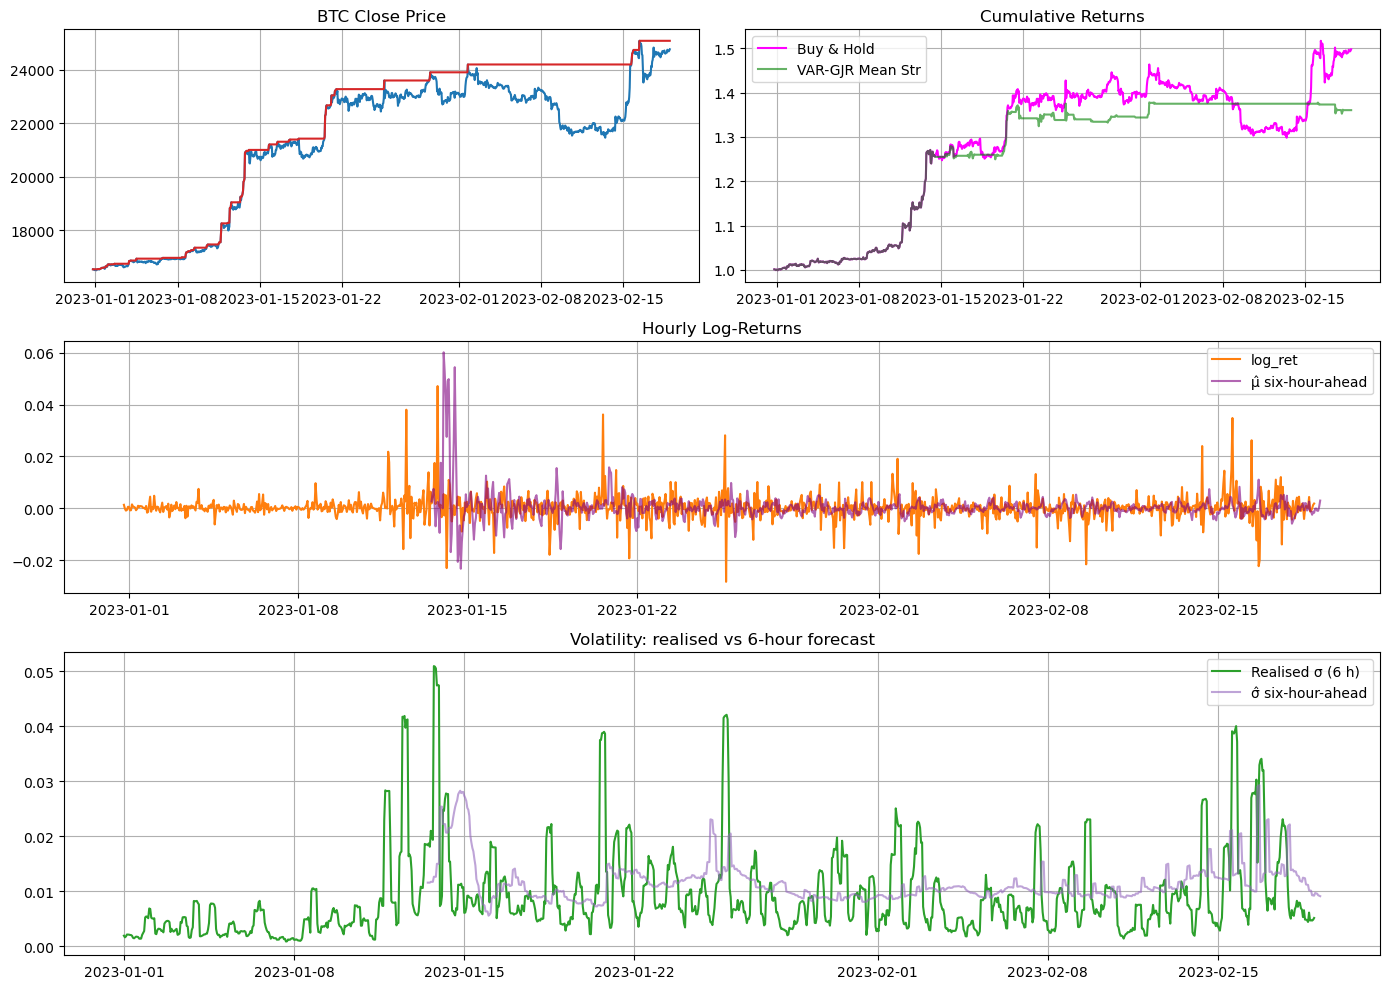

1182 | 2023-02-18 23:00:00-06:00 | Close 24,757.63 | trail 24,439.14 | r  0.00181 | RV_blk  0.00513 | μ_blk  0.00295 | σ_blk  0.00910 | s  0.080 | pos 0 | TIM(200)=0.06 | flips/w~6
Exit flag detected—stopping.


In [68]:
# --- parameters -------------------------------------------------------
COOLDOWN       = 8      # global re-entry cooldown after any flip
EXIT_PERSIST   = 4      # bars s < s_off required to exit on score fade
SCORE_EXIT_COOL = 8     # extra cooldown if exit was due ONLY to score fade

N_UPDATE       = 3           # refit models every N bars
MIN_SAMPLE     = 300         # min obs to start modeling
LOOKBACK_CAP   = 4000        # safety cap when data grows
FEE            = 0.00075     # taker ~7.5 bps one side (adjust to your acct)
PCTL_ON        = 0.90        # s-quantile for ON threshold (controls time-in-market)
HYSTERESIS_OFF = 0.80        # s_off = HYSTERESIS_OFF * s_on
# MOM_THRESHOLD  = 0.015        # 24h momentum gate (2%)
SIGMA_FLOOR    = 0.005       # floor for sigma_cut when little history
K_SMOOTH       = True        # Kalman-smooth μ? (set False to disable)

MOM_Z = 0.60   # z-threshold for 24h momentum (try 0.6–0.8)
STRONG_TREND_Z = 0.90
S_WIN   = 500    # new: rolling window for |s| quantile (~2 weeks of hours)
flipped        = False
score_below_cnt = 0
score_exit_cool  = 0

# --- Kalman state (for μ smoothing) ----------------------------------
kf_m, kf_P = 0.0, 1.0   # mean and covariance

# ----------------- INITIALIZATION ------------------------------------
ts_x, close_y, cummax_y, logret_y = [], [], [], []
realvol_y = []
fcst_x, fcst_y = [], []
cstrategy_y, creturns_y = [], []
mean_fcst_x, mean_fcst_y = [], []

results_log, decision_log, forecast_log = [], [], []
X_train = []

mu_hist = deque(maxlen=2000)
s_hist  = deque(maxlen=2000)

position   = 1
started_trading = False
t0_trade = None


sigma_ratios = deque(maxlen=200)   # realized / forecast, matched at target time
sigma_scale  = 1.0                 # multiplicative calibration applied to vol_6h
fcst_map     = {}                  # target_ts -> forecasted σ_6h (decimal)

pending_sigma = {}                  # target_ts -> σ_fcst_used (scaled)
sigma_ratio_hist = deque(maxlen=200)  # realized/forecast ratios


cum_asset  = 0.0
cum_strat  = 0.0
cooldown   = COOLDOWN
score_below_cnt = 0
score_ok_cnt    = 0   # NEW: consecutive bars with score_ok while FLAT

var_res  = None
lag_order = None
g_mod     = None

# -------------- MAIN BACKTEST LOOP -----------------------------------
for n, partial_df in enumerate(simulate_market(btc, delay=0.1), start=1):
    partial_df = partial_df.copy()
    latest  = partial_df.iloc[-1]
    tstamp  = latest.name
    prev_pos = position

    # cooldown tick
    if cooldown > 0:
        cooldown -= 1
        if score_exit_cool > 0:
            score_exit_cool -= 1

    # ------ 1) DATA PREP ---------------------------------------------
    partial_df['cummax'] = partial_df['close'].cummax()
    vol = partial_df['volume'].replace(0, np.nan)

    log_chg_open   = np.log(partial_df['open']   / partial_df['open'].shift(1))
    log_chg_high   = np.log(partial_df['high']   / partial_df['high'].shift(1))
    log_chg_low    = np.log(partial_df['low']    / partial_df['low'].shift(1))
    log_chg_close  = np.log(partial_df['close']  / partial_df['close'].shift(1))
    log_chg_volume = np.log(vol / vol.shift(1))

    # ------ 2) RETURN ACCRUAL ----------------------------------------
    r_1h = log_chg_close.iloc[-1]
    cum_asset += r_1h
    cum_strat += prev_pos * r_1h
    creturns_y.append(np.exp(cum_asset))
    cstrategy_y.append(np.exp(cum_strat))

    # ------ 3) REALIZED BLOCK VOL (6h) -------------------------------
    if len(log_chg_close) >= 6:
        real_vol_block = np.sqrt((log_chg_close**2).rolling(6).sum()).iloc[-1]
    else:
        real_vol_block = np.nan

    # book-keeping for plots
    ts_x.append(tstamp)
    close_y.append(float(latest.close))
    cummax = float(partial_df['cummax'].iloc[-1])
    cummax_y.append(cummax)
    logret_y.append(r_1h)
    realvol_y.append(real_vol_block)

    results_log.append(dict(
        timestamp=tstamp, close=float(latest.close), log_ret=r_1h,
        realized_vol=real_vol_block, forecasted_vol=np.nan, forecasted_mu=np.nan,
        position=position, cum_asset=cum_asset, cum_strat=cum_strat
    ))



    # ... after real_vol_block is computed ...
    # If we have a forecast that targeted *this* timestamp, compare & update calibration
    if (tstamp in fcst_map) and np.isfinite(real_vol_block):
        pred = fcst_map.pop(tstamp)
        if pred > 0:
            sigma_ratios.append(float(real_vol_block) / float(pred))

    # Smooth multiplicative scale (robust to outliers via median)
    if len(sigma_ratios) >= 20:
        target = np.median(sigma_ratios)          # realized / forecast
        target = np.clip(target, 0.5, 1.3)        # guardrails
        sigma_scale = 0.8 * sigma_scale + 0.2 * target




    # ------ 4) TRAILING STOP SETUP -----------------------------------
    # width adapts to recent realized block vol
    rv_now = real_vol_block if np.isfinite(real_vol_block) else 0.015
    dd_pct = np.clip(0.015 + 2.0 * rv_now, 0.015, 0.08)
    trail_threshold = cummax * (1 - dd_pct)
    trail_break = float(latest.close) < trail_threshold

    # ------ 5) TRAIN MODELS (every N_UPDATE) -------------------------
    X_train.append({
        'timestamp': tstamp,
        'open':   log_chg_open.iloc[-1],
        'high':   log_chg_high.iloc[-1],
        'low':    log_chg_low.iloc[-1],
        'close':  log_chg_close.iloc[-1],
        'volume': log_chg_volume.iloc[-1],
    })
    df_train = pd.DataFrame(X_train).dropna()
    lookback = min(LOOKBACK_CAP, int(0.6 * len(df_train)))

    if len(df_train) >= MIN_SAMPLE and n % N_UPDATE == 0:
        y_vars = df_train[['open','high','low','close','volume']].iloc[-lookback:]
        y_vars = y_vars.replace([np.inf,-np.inf], np.nan).dropna()

        # VAR on returns
        var_model = VAR(y_vars)
        var_res   = var_model.fit(maxlags=6, trend='n')   # returns => no intercept
        lag_order = var_res.k_ar

        # GJR-GARCH for asymmetry (stable & simple)

        resids_dec = var_res.resid['close'].dropna().to_numpy().astype(float)         # decimal
        resids_pct = resids_dec * 100.0                                               # percent
        print("std(resids, %):", resids_pct.std())  # expect ~0.1–1.5 for BTC 1h depending on regime

        g_mod = arch_model(
            resids_pct,
            mean='Zero',
            vol='GARCH',  # add o=1 for GJR if you want asymmetry
            p=1, o=1 ,q=1,
            dist='t',
            rescale=False
        ).fit(disp='off')


    # ------ 6) FORECASTS ---------------------------------------------
    mu_block = np.nan
    vol_6h   = np.nan

    if (var_res is not None) and (lag_order is not None):
        y_vars = df_train[['open','high','low','close','volume']].dropna().iloc[-lookback:]
        if len(y_vars) >= lag_order:
            mu_path   = var_res.forecast(y_vars.values[-lag_order:], steps=6)
            idx_close = y_vars.columns.get_loc('close')
            mu_block  = float(mu_path[:, idx_close].sum()) # 6h cumulative

    if (g_mod is not None) and g_mod.optimization_result.success:


        g_f    = g_mod.forecast(horizon=6, reindex=False)
        h_pct2 = np.asarray(g_f.variance.values[-1], dtype=float)       # shape (6,), variance in %^2
        sigma1h_pct = np.sqrt(h_pct2)                                    # 1h σ in %
        sigma1h_med_pct = float(np.median(sigma1h_pct))
        vol_6h = float(np.sqrt(h_pct2.sum()) / 100.0)                    # 6h block σ in decimal

        vol_6h *= float(sigma_scale)

        print("σ̂_1h(median, %):", sigma1h_med_pct)
        print("σ̂_6h(decimal):", vol_6h)

    has_fcst = np.isfinite(mu_block) and np.isfinite(vol_6h)

    # activate live trading only after first valid forecast
    if (not started_trading) and has_fcst:
        started_trading = True

    # ------ 7) (optional) KALMAN SMOOTH μ ----------------------------
    mu_for_score = mu_block
    if K_SMOOTH and np.isfinite(mu_block):
        mu_hist.append(mu_block)
        R = np.nanvar(list(mu_hist)[-200:]) if len(mu_hist) >= 50 else 1e-6  # obs var
        Q = 0.15 * R                                                         # process var
        kf_P = kf_P + Q
        K    = kf_P / (kf_P + R + 1e-12)
        kf_m = kf_m + K * (mu_block - kf_m)
        kf_P = (1 - K) * kf_P
        mu_for_score = float(kf_m)

    # ------ 8) DYNAMIC σ_CUT & SCORE ---------------------------------
    rv_series = pd.Series(realvol_y).dropna()
    if len(rv_series) >= 30:
        ewma = rv_series.ewm(alpha=1-0.94, adjust=False)
        ewma_mean = ewma.mean().iloc[-1]
        ewma_sd   = np.sqrt(ewma.var().iloc[-1])
        sigma_cut = max(SIGMA_FLOOR, ewma_mean + 1.5 * ewma_sd)
    else:
        sigma_cut = SIGMA_FLOOR

    # --- Blended sigma for gates & score (stabilizes denominator) ---
    # EWMA(realized 6h σ) you already computed as ewma_mean
    rv_ewma_6h = ewma_mean if len(rv_series) >= 30 else SIGMA_FLOOR

    def _blend_sigma(sig_fcst, sig_real, w=0.60):
        # RMS blend keeps units right and avoids bias
        if np.isfinite(sig_fcst) and np.isfinite(sig_real):
            return float(np.sqrt(w*(sig_fcst**2) + (1.0-w)*(sig_real**2)))
        return float(sig_fcst) if np.isfinite(sig_fcst) else float(sig_real)

    vol_blend_6h = _blend_sigma(vol_6h, rv_ewma_6h, w=0.60)
    vol_den_6h   = max(SIGMA_FLOOR, vol_blend_6h)


    s = (mu_for_score / (vol_den_6h + 1e-12)) if np.isfinite(mu_for_score) else np.nan
    if np.isfinite(s):
        s_hist.append(s)



    # ------ 8b) ADAPTIVE SCORE GATE (tail-only) ------
    if len(s_hist) >= 300:
        recent_abs = np.abs(np.array(s_hist)[-S_WIN:])
        s_on = float(np.quantile(recent_abs, PCTL_ON))   # q90 of |s| over recent window
    else:
        s_on = 0.06                                    # warm-up fallback
    s_off = HYSTERESIS_OFF * s_on                      # stronger hysteresis



    # ------ 9) REGIME & MOMENTUM GATES -------------------------------
    n = len(partial_df)

    ema72  = partial_df['close'].ewm(span=72,  adjust=False).mean().iloc[-1] if n >= 72  else np.nan
    ema168 = partial_df['close'].ewm(span=168, adjust=False).mean().iloc[-1] if n >= 168 else np.nan
    ema336 = partial_df['close'].ewm(span=336, adjust=False).mean().iloc[-1] if n >= 336 else np.nan

    if n < 168:
        # warm-up: single filter
        trend_ok = (latest.close > ema72) if np.isfinite(ema72) else False
    elif n < 336:
        # mid warm-up: two-stack
        trend_ok = (latest.close > ema72) and (ema72 > ema168)
    else:
        # full regime: three-stack
        trend_ok = (latest.close > ema72) and (ema72 > ema168) and (ema168 > ema336)


    # 24h simple momentum in decimal
    mom_24h = (latest.close / partial_df['close'].iloc[-24] - 1) if len(partial_df) >= 24 else 0.0

    # convert a 6h sigma to 24h sigma (fallback to realized if forecast missing)
    rv_now_safe = rv_now if np.isfinite(rv_now) else 0.01
    sig_24h = np.sqrt(4) * (vol_den_6h if np.isfinite(vol_den_6h) else rv_now_safe)

    # z-scored momentum gate
    mom_z  = mom_24h / (sig_24h + 1e-12)
    mom_ok = mom_z > MOM_Z


    risk_off = np.isfinite(vol_den_6h) and (vol_den_6h > sigma_cut)
    one_h_sigma = (vol_den_6h / np.sqrt(6)) if np.isfinite(vol_den_6h) else np.nan


    # ------ 10) STATE MACHINE (long-only) ----------------------------
    if not started_trading or not has_fcst:
        new_pos, reason = position, "HOLD: no forecast"

    else:
        new_pos, reason = position, "HOLD"

        # gate pre-compute
        score_ok     = np.isfinite(s) and (s > s_on) and (mom_z > 0.0) and (not risk_off)
        strong_trend = trend_ok and (mom_z > STRONG_TREND_Z) and (not risk_off)

        if position == 1:
            score_low = np.isfinite(s) and (s < s_off)
            score_below_cnt = score_below_cnt + 1 if score_low else 0
            score_trigger = score_below_cnt >= EXIT_PERSIST

            if trail_break or risk_off or (not trend_ok) or score_trigger:
                new_pos = 0
                reason  = (f"EXIT: trail={trail_break}, risk_off={risk_off}, "
                        f"trend={trend_ok}, s<{s_off:.3f} ({score_below_cnt})")
                # if this was purely a score fade (not regime/risk), set extra cooldown
                if score_trigger and (not trail_break) and (not risk_off) and trend_ok:
                    score_exit_cool = SCORE_EXIT_COOL

        else:
            # flat
            score_below_cnt = 0
            can_enter = (cooldown == 0) and (score_exit_cool == 0)
            if can_enter and trend_ok and (score_ok or strong_trend):
                new_pos = 1
                reason  = f"ENTER: {'score' if score_ok else 'trend'} gate"
                # optional: tag entry source for diagnostics
                enter_via = 'score2' if score_ok else 'trend'

        # apply flip (fees + cooldown)
        flipped = (int(new_pos) != int(position))
        if flipped:
            cum_strat -= FEE
            cooldown   = COOLDOWN
        position = int(new_pos)



    # ------ 11) STORE FORECAST ROWS ----------------------------------
    if np.isfinite(vol_6h) and np.isfinite(mu_block):
        future_ts = tstamp + pd.Timedelta(hours=6)
        fcst_x.append(future_ts);  fcst_y.append(vol_6h)
        mean_fcst_x.append(future_ts); mean_fcst_y.append(mu_block)

        fcst_map[future_ts] = vol_6h

        results_log.append(dict(
            timestamp=future_ts, close=np.nan, log_ret=np.nan, realized_vol=np.nan,
            forecasted_vol=vol_6h, forecasted_mu=mu_block, position=np.nan,
            cum_asset=np.nan, cum_strat=np.nan
        ))
        forecast_log.append(dict(
            origin_ts=tstamp, target_ts=future_ts,
            forecasted_vol=vol_6h, forecasted_mu=mu_block
        ))

    # ------ 12) DECISION LOG -----------------------------------------
    decision_log.append({
        "timestamp": tstamp,
        "prev_position": prev_pos,
        "new_position": position,
        "cooldown": cooldown,
        "mu_blk": mu_block,
        "mu_smooth": mu_for_score,
        "sigma_cut": sigma_cut,
        "vol_6h": vol_6h,
        "close": float(latest.close),
        "cummax": cummax,
        "trail_threshold": trail_threshold,
        "reason": reason,
        "s": s,
        "s_on": s_on,
        "s_off": s_off,
        "trend_ok": bool(trend_ok),
        "mom_24h": mom_24h,
        "risk_off": bool(risk_off),
        "flip_fee": FEE if flipped else 0.0,
        "mom_z": float(mom_z),
        "score_ok": bool(np.isfinite(s) and s > s_on),
        "regime_ok": bool(trend_ok and not risk_off),
        "enter_via": enter_via if 'enter_via' in locals() else "",
        "vol_fcst_6h": vol_6h,
        "vol_blend_6h": vol_den_6h,
        "sigma_scale": float(sigma_scale),
    })

    # ------ 13) PLOT --------------------------------------------------
    clear_output(wait=True)
    fig = plt.figure(figsize=(14, 10))
    gs  = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1.2])

    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(ts_x, close_y, color="tab:blue")
    ax1.plot(ts_x, cummax_y, color="tab:red")
    ax1.set_title("BTC Close Price"); ax1.grid(True)

    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(ts_x, creturns_y,  label="Buy & Hold", color="magenta")
    ax2.plot(ts_x, cstrategy_y, label="VAR-GJR Mean Str", color="green", alpha=0.6)
    ax2.set_title("Cumulative Returns"); ax2.legend(); ax2.grid(True)

    ax3 = fig.add_subplot(gs[1, :])
    ax3.plot(ts_x, logret_y, color="tab:orange", label="log_ret")
    ax3.plot(mean_fcst_x, mean_fcst_y, color="purple", label="μ̂ six-hour-ahead", alpha=0.6)
    ax3.set_title("Hourly Log-Returns"); ax3.legend(); ax3.grid(True)

    ax4 = fig.add_subplot(gs[2, :])
    ax4.plot(ts_x, realvol_y, color="tab:green", label="Realised σ (6 h)")
    ax4.plot(fcst_x, fcst_y, color="tab:purple", label="σ̂ six-hour-ahead", alpha=0.6)
    ax4.set_title("Volatility: realised vs 6-hour forecast")
    ax4.legend(); ax4.grid(True)

    plt.tight_layout(); plt.show()

    # quick telemetry
    window = min(200, len(decision_log))
    tim = np.mean([d["new_position"] for d in decision_log[-window:]]) if window else np.nan
    flips_week = sum(int(decision_log[i]["new_position"] != decision_log[i-1]["new_position"])
                     for i in range(max(1, len(decision_log)-168), len(decision_log)))
    print(f"{n:4d} | {tstamp} | Close {latest.close:,.2f} | trail {trail_threshold:,.2f} | "
          f"r {r_1h: .5f} | RV_blk {rv_now: .5f} | μ_blk {mu_block: .5f} | σ_blk {vol_6h: .5f} | "
          f"s {s if np.isfinite(s) else np.nan: .3f} | pos {position} | TIM(200)={tim:.2f} | flips/w~{flips_week}")

    # Auto-stop
    if os.path.exists("exit.flag"):
        print("Exit flag detected—stopping.")
        break
    # if n == 5000: break

# ------------------------- FINAL DFs ---------------------------------
df_results = (pd.DataFrame(results_log)
                .set_index("timestamp")
                .sort_index())

df_results.index = df_results.index.floor("h")

df_final = (df_results
    .groupby(level=0)
    .agg(
        close          = ('close',          'first'),
        log_ret        = ('log_ret',        'first'),
        realized_vol   = ('realized_vol',   'first'),
        forecasted_vol = ('forecasted_vol', 'last'),
        forecasted_mu  = ('forecasted_mu',  'last'),
        position       = ('position',       'last'),
        cum_asset      = ('cum_asset',      'last'),
        cum_strat      = ('cum_strat',      'last'),
    )
    .sort_index()
)

df_log_changes = (pd.DataFrame(X_train)
                  .set_index("timestamp")
                  .sort_index())

df_forecasts = pd.DataFrame(forecast_log)
if df_forecasts.empty or 'target_ts' not in df_forecasts.columns:
    print("No forecast rows captured yet (df_forecasts is empty).")
    df_forecasts = (pd.DataFrame(columns=['origin_ts','forecasted_vol','forecasted_mu'])
                    .set_index(pd.DatetimeIndex([], name='target_ts')))
else:
    df_forecasts = df_forecasts.set_index('target_ts').sort_index()

df_decision_log = (pd.DataFrame(decision_log)
                   .set_index("timestamp")
                   .sort_index())


In [65]:
# --- helpers ----------------------------------------------------------
def _dd_stats(eq):
    """
    Max drawdown on a wealth/equity curve.
    Returns (min_drawdown_float, drawdown_array).
    """
    v = np.asarray(eq, dtype=float)
    v = v[~np.isnan(v)]
    if v.size == 0:
        return np.nan, np.array([])

    roll_max = np.maximum.accumulate(v)
    dd = (v / roll_max) - 1.0
    return float(dd.min()), dd





def diagnose_strategy(df_final, df_decision_log):
    df  = df_final.sort_index().copy()
    dec = df_decision_log.sort_index().copy()

    # --- basic series ---
    cs  = df['cum_strat'].ffill()
    ca  = df['cum_asset'].ffill()
    r_s = cs.diff().fillna(0.0)                  # hourly log returns (strategy)
    r_b = df['log_ret'].fillna(0.0)              # hourly log returns (buy&hold)

    eq_s = np.exp(cs)                            # wealth (strategy)
    eq_b = np.exp(ca)                            # wealth (buy&hold)

    # --- core performance ---
    ann = np.sqrt(24*365)
    sharpe_s = (r_s.mean() / (r_s.std(ddof=0) + 1e-12)) * ann
    sharpe_b = (r_b.mean() / (r_b.std(ddof=0) + 1e-12)) * ann

    mdd_s, _ = _dd_stats(eq_s)
    mdd_b, _ = _dd_stats(eq_b)

    flips = int((df['position'].ffill().astype(float).diff().abs() > 0).sum())
    weeks = max(1.0, len(df)/(24*7))
    flips_per_week = flips / weeks
    tim = float(df['position'].ffill().mean())

    # =========================
    # Forecast & calibration sanity
    # =========================
    med_sigma_real   = float(df.get('realized_vol', pd.Series(dtype=float)).median(skipna=True))
    med_sigma_fcst   = float(df.get('forecasted_vol', pd.Series(dtype=float)).median(skipna=True))  # raw σ̂ used for plotting
    med_sigma_blend  = float(dec.get('vol_blend_6h', pd.Series(dtype=float)).median(skipna=True))   # σ used in gates/score
    med_sigma_fcst2  = float(dec.get('vol_fcst_6h',  pd.Series(dtype=float)).median(skipna=True))   # σ̂ after scaling (pre-blend)
    med_sigma_scale  = float(dec.get('sigma_scale',  pd.Series(dtype=float)).median(skipna=True))

    def _ratio(num, den):
        return (num/den) if (np.isfinite(num) and np.isfinite(den) and den>0) else np.nan

    ratio_raw    = _ratio(med_sigma_fcst,  med_sigma_real)
    ratio_scaled = _ratio(med_sigma_fcst2, med_sigma_real)
    ratio_blend  = _ratio(med_sigma_blend, med_sigma_real)

    # =========================
    # Gate usage
    # =========================
    regime_ok = dec.get('regime_ok',
                        (dec.get('trend_ok', pd.Series(False, index=dec.index)).astype(bool)
                         & ~dec.get('risk_off', pd.Series(False, index=dec.index)).astype(bool))).astype(bool)
    score_ok  = dec.get('score_ok', pd.Series(False, index=dec.index)).astype(bool)
    mom_z     = dec.get('mom_z', pd.Series(0.0, index=dec.index).astype(float))

    regime_ok_share = float(regime_ok.mean()) if len(regime_ok) else np.nan
    score_ok_share  = float((regime_ok & score_ok).mean()) if len(regime_ok) else np.nan
    mom_ok_share    = float((regime_ok & (mom_z > 0)).mean()) if len(regime_ok) else np.nan

    # =========================
    # Score predictiveness (aligned)
    # =========================
    s = dec.get('s', pd.Series(index=dec.index, dtype=float)).astype(float)
    fwd6 = df['log_ret'].rolling(6).sum().shift(-6)           # on df index
    fwd6_dec = fwd6.reindex(dec.index)                        # align to decision log index

    tmp = pd.concat([s, fwd6_dec], axis=1).dropna()
    corr_s_fwd6 = float(tmp.corr().iloc[0,1]) if len(tmp) > 5 else np.nan

    thr = s.abs().quantile(0.9) if s.notna().any() else np.nan
    tail_mask = (s.abs().ge(thr) & regime_ok & s.notna()) if np.isfinite(thr) else pd.Series(False, index=dec.index)
    tail_mean = float(fwd6_dec[tail_mask].mean(skipna=True)) if tail_mask.any() else np.nan

    # =========================
    # Missed upside while flat & gates open
    # =========================
    pos_dec  = df['position'].ffill().reindex(dec.index).fillna(0).astype(int)
    open_but_flat = (pos_dec==0) & regime_ok & (score_ok | (mom_z > 0.9)) \
                    & ~dec.get('risk_off', pd.Series(False, index=dec.index)) \
                    & (dec.get('cooldown', pd.Series(0, index=dec.index))==0)
    open_flat_share = float(open_but_flat.mean()) if len(open_but_flat) else np.nan
    open_flat_mean  = float(fwd6_dec[open_but_flat].mean(skipna=True)) if open_but_flat.any() else np.nan
    open_flat_median= float(fwd6_dec[open_but_flat].median(skipna=True)) if open_but_flat.any() else np.nan

    # =========================
    # Exits diagnostics
    # =========================
    exit_idx = dec.index[(dec.get('prev_position',0)==1) & (dec.get('new_position',0)==0)]
    fwd6_exit = fwd6_dec.reindex(exit_idx)
    bad_exits_share = float((fwd6_exit > 0).mean()) if len(fwd6_exit) else np.nan
    bad_exits_mean  = float(fwd6_exit.mean(skipna=True)) if len(fwd6_exit) else np.nan

    reasons = dec.get('reason', pd.Series('', index=dec.index)).astype(str)
    score_exit_share = float(reasons.reindex(exit_idx).str.contains('s<', regex=False).mean()) if len(exit_idx) else np.nan
    risk_exit_share  = float(reasons.reindex(exit_idx).str.contains('risk_off', regex=False).mean()) if len(exit_idx) else np.nan
    trend_exit_share = float(reasons.reindex(exit_idx).str.contains('trend=False', regex=False).mean()) if len(exit_idx) else np.nan

    # Cooldown “cost” (bars where cooldown blocked entry while gates open)
    cool_mask = (dec.get('cooldown', pd.Series(0, index=dec.index))>0) & regime_ok & (score_ok | (mom_z>0.9))
    cool_share = float(cool_mask.mean()) if len(cool_mask) else np.nan
    cool_mean  = float(fwd6_dec[cool_mask].mean(skipna=True)) if cool_mask.any() else np.nan

    # Entry mix (if you logged enter_via)
    enter_breakdown = dec.get('enter_via', pd.Series([], dtype=str)).replace('', np.nan).dropna().value_counts()

    # =========================
    # Print
    # =========================
    print("=== PERF ===")
    print(f"Final Wealth:  Strategy {eq_s.iloc[-1]:.3f} | Buy&Hold {eq_b.iloc[-1]:.3f}")
    print(f"Sharpe (ann): Strategy {sharpe_s:.2f} | Buy&Hold {sharpe_b:.2f}")
    print(f"MaxDD:        Strategy {mdd_s:.1%} | Buy&Hold {mdd_b:.1%}")
    print(f"TIM: {tim:.2f} | flips/week ~ {flips_per_week:.1f} (total flips={flips})")

    print("\n=== VOL SANITY ===")
    print(f"Median σ_real(6h)={med_sigma_real:.4f}")
    print(f"Median σ̂_raw(6h)={med_sigma_fcst:.4f}  | ratio(raw/real)={ratio_raw:.2f}")
    print(f"Median σ̂_scaled(6h)={med_sigma_fcst2:.4f} | ratio(scaled/real)={ratio_scaled:.2f} | median scale={med_sigma_scale:.3f}")
    print(f"Median σ_used(blend)={med_sigma_blend:.4f} | ratio(blend/real)={ratio_blend:.2f}")

    print("\n=== GATES (share of bars) ===")
    print(f"Regime OK: {regime_ok_share:.2f}")
    print(f"Score OK & Regime OK: {score_ok_share:.2f}")
    print(f"Mom>0 & Regime OK: {mom_ok_share:.2f}")

    print("\n=== SCORE PREDICTIVENESS ===")
    print(f"Corr(s, fwd_6h) = {corr_s_fwd6:.3f} | Mean fwd_6h in top |s| decile (regime ok) = {tail_mean:.4f}")

    print("\n=== MISSED UPSIDE (flat while gates open) ===")
    print(f"Share: {open_flat_share:.3f} | mean fwd_6h: {open_flat_mean:.4f} | median fwd_6h: {open_flat_median:.4f}")

    print("\n=== EXITS ===")
    print(f"Bad exits %% (fwd_6h>0): {bad_exits_share:.3f} | mean fwd_6h after exit: {bad_exits_mean:.4f}")
    print(f"Exit mix — score:{score_exit_share:.2f} risk:{risk_exit_share:.2f} trend:{trend_exit_share:.2f}")

    if len(enter_breakdown):
        print("\n=== ENTRY MIX ===")
        print(enter_breakdown.to_string())

    print("\n=== COOLDOWN IMPACT ===")
    print(f"Cooldown blocks — share: {cool_share:.3f} | mean fwd_6h while blocked: {cool_mean:.4f}")

    # --- action hints ---
    print("\n=== ACTION HINTS ===")
    hints = []
    if np.isfinite(ratio_blend) and ratio_blend > 1.25:
        hints.append("• σ used in gates still high vs realized → lower blend weight (w→0.5) or let sigma_scale converge longer.")
    if flips_per_week > 8:
        hints.append("• Too many flips → raise HYSTERESIS_OFF or EXIT_PERSIST; consider COOLDOWN up a notch.")
    if open_flat_share > 0.03 and open_flat_mean > 0:
        hints.append("• Missing upside while flat → reduce COOLDOWN or allow ‘trend’ entries when score_exit_cool>0.")
    if (not np.isfinite(corr_s_fwd6) or corr_s_fwd6 < 0.02) and (not np.isfinite(tail_mean) or tail_mean <= 0):
        hints.append("• Score weak → tighten to tails (higher quantile) and/or lengthen S_WIN; gate with trend_ok & s>0 only.")
    if not hints:
        hints.append("• Looks consistent. If still underperforming, nudge STRONG_TREND_Z down (0.90→0.80) to catch bursts.")
    print("\n".join(hints))



In [66]:
diagnose_strategy(df_final, df_decision_log)

=== PERF ===
Final Wealth:  Strategy 1.370 | Buy&Hold 1.439
Sharpe (ann): Strategy 8.98 | Buy&Hold 8.91
MaxDD:        Strategy -4.6% | Buy&Hold -5.0%
TIM: 0.61 | flips/week ~ 9.6 (total flips=45)

=== VOL SANITY ===
Median σ_real(6h)=0.0066
Median σ̂_raw(6h)=0.0107  | ratio(raw/real)=1.63
Median σ̂_scaled(6h)=0.0107 | ratio(scaled/real)=1.63 | median scale=0.809
Median σ_used(blend)=0.0088 | ratio(blend/real)=1.34

=== GATES (share of bars) ===
Regime OK: 0.77
Score OK & Regime OK: 0.22
Mom>0 & Regime OK: 0.60

=== SCORE PREDICTIVENESS ===
Corr(s, fwd_6h) = 0.048 | Mean fwd_6h in top |s| decile (regime ok) = 0.0053

=== MISSED UPSIDE (flat while gates open) ===
Share: 0.024 | mean fwd_6h: 0.0000 | median fwd_6h: -0.0010

=== EXITS ===
Bad exits %% (fwd_6h>0): 0.391 | mean fwd_6h after exit: -0.0018
Exit mix — score:1.00 risk:1.00 trend:0.04

=== ENTRY MIX ===
enter_via
score2    717
trend      61

=== COOLDOWN IMPACT ===
Cooldown blocks — share: 0.193 | mean fwd_6h while blocked: 0.003

### Buy and hold

In [1]:
from strategies.PriceVolBacktester import Long_Only_Backtester as LO

In [2]:
btc

NameError: name 'btc' is not defined

In [ ]:
filepath = sol
symbol = "BTC-USD"
start = "2022-12-31"
end = "2024-06-15"
tc = 0.095

In [ ]:
tester_sol = LO(filepath = filepath, symbol = symbol, 
            start = start, end = end, tc = tc)

In [21]:
tester.data

,open,high,low,close,volume,returns
timestamp,,,,,,
2022-12-31 18:00:00-06:00,16541.77,16545.70,16508.39,16529.67,4364.83570,NaN
2022-12-31 19:00:00-06:00,16529.59,16556.80,16525.78,16551.47,3590.06669,0.001318
2022-12-31 20:00:00-06:00,16551.47,16559.77,16538.14,16548.19,3318.84038,-0.000198
2022-12-31 21:00:00-06:00,16548.19,16548.19,16518.21,16533.04,4242.08050,-0.000916
2022-12-31 22:00:00-06:00,16533.04,16535.97,16511.92,16521.85,4285.00909,-0.000677
...,...,...,...,...,...,...
2024-06-15 19:00:00-06:00,66161.96,66218.48,66102.03,66175.68,256.25855,0.000207
2024-06-15 20:00:00-06:00,66175.68,66182.26,66114.27,66142.86,149.85752,-0.000496
2024-06-15 21:00:00-06:00,66142.86,66164.30,66076.55,66146.00,160.87464,0.000047


In [22]:
tester.test_strategy(percentiles=(90, 5, 20))

SIMPLE PRICE & VOLUME STRATEGY | INSTRUMENT = BTC-USD | THRESHOLDS = 0.00449, [-0.75337 -0.39158]
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         4.353692
Multiple (Buy-and-Hold):     4.008791
--------------------------------------
Out-/Underperformance:       0.344901


CAGR:                        1.745454
Annualized Mean:             1.010026
Annualized Std:              0.459969
Sharpe Ratio:                3.794721


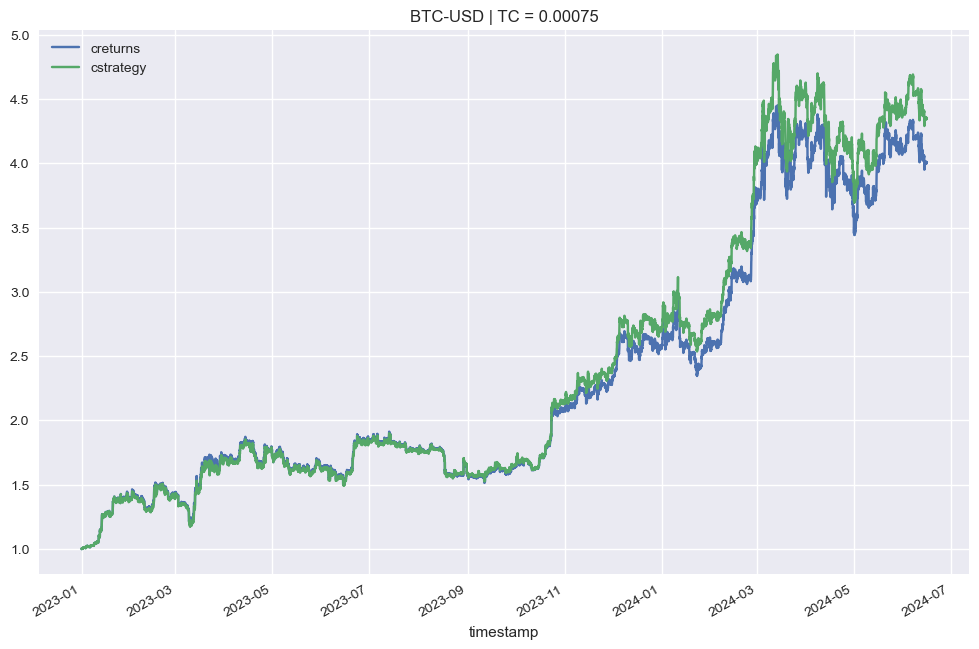

In [23]:
tester.plot_results()

In [24]:
tester.results

,close,volume,returns,vol_ch,position,strategy,trades,creturns,cstrategy
timestamp,,,,,,,,,
2022-12-31 18:00:00-06:00,16529.67,4364.83570,NaN,NaN,1,NaN,0.0,NaN,NaN
2022-12-31 19:00:00-06:00,16551.47,3590.06669,0.001318,-0.195410,1,0.001318,0.0,1.001319,1.001319
2022-12-31 20:00:00-06:00,16548.19,3318.84038,-0.000198,-0.078555,1,-0.000198,0.0,1.001120,1.001120
2022-12-31 21:00:00-06:00,16533.04,4242.08050,-0.000916,0.245438,1,-0.000916,0.0,1.000204,1.000204
2022-12-31 22:00:00-06:00,16521.85,4285.00909,-0.000677,0.010069,1,-0.000677,0.0,0.999527,0.999527
...,...,...,...,...,...,...,...,...,...
2024-06-15 19:00:00-06:00,66175.68,256.25855,0.000207,0.136335,1,0.000207,0.0,4.003448,4.347889
2024-06-15 20:00:00-06:00,66142.86,149.85752,-0.000496,-0.536502,1,-0.000496,0.0,4.001463,4.345733
2024-06-15 21:00:00-06:00,66146.00,160.87464,0.000047,0.070940,1,0.000047,0.0,4.001653,4.345939


In [25]:
tester.optimize_strategy(return_range = (85, 98, 1), 
                         vol_low_range = (2, 16, 1), 
                         vol_high_range = (16, 35, 1))

Return_Perc: 85 | Volume_Perc: [2, 26] | Multiple: 6.15371
SIMPLE PRICE & VOLUME STRATEGY | INSTRUMENT = BTC-USD | THRESHOLDS = 0.00332, [-0.95969 -0.30066]
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         6.153711
Multiple (Buy-and-Hold):     4.008791
--------------------------------------
Out-/Underperformance:       2.14492


CAGR:                        2.48169
Annualized Mean:             1.247615
Annualized Std:              0.455157
Sharpe Ratio:                5.452384


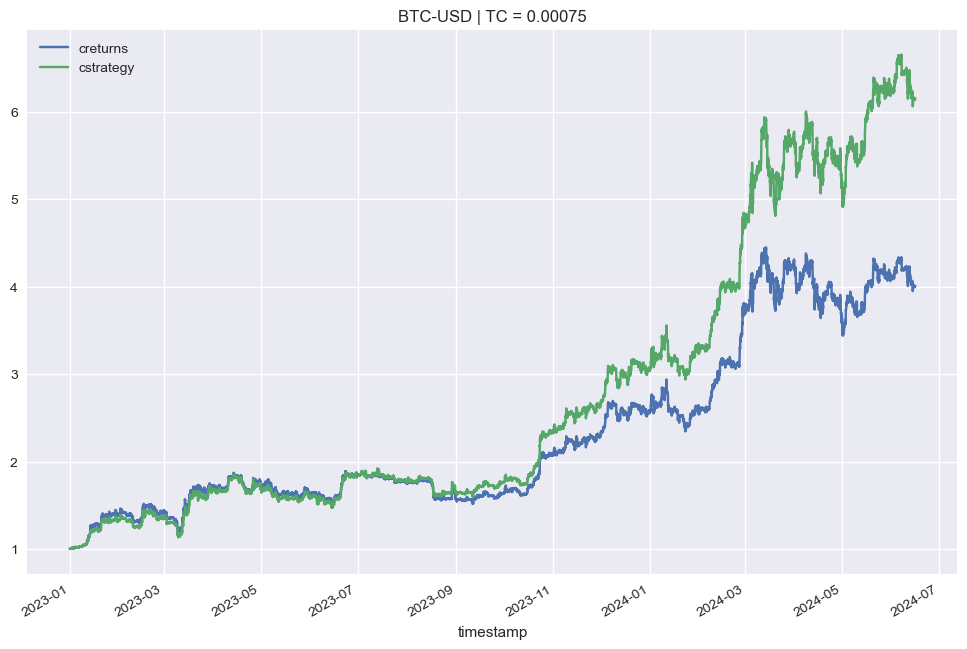

In [27]:
tester.plot_results()

In [29]:
ret_tresh = tester.return_thresh
ret_tresh

0.0033197914672255815

In [30]:
vol_tresh = tester.volume_thresh
vol_tresh

array([-0.95969241, -0.3006619 ])

In [34]:
filepath = btc
symbol = "BTC-USD"
start = "2024-06-15"
end = "2025-05-15"
tc = 0.00075

In [35]:
tester_price_vol = LO(filepath = filepath, symbol = symbol, start = start, end = end, tc = tc)
tester_price_vol

Long_Only_Backtester(symbol = BTC-USD, start = 2024-06-15, end = 2025-05-15)

In [36]:
tester_price_vol.test_strategy(thresh = (ret_tresh, vol_tresh[0], vol_tresh[1]))

SIMPLE PRICE & VOLUME STRATEGY | INSTRUMENT = BTC-USD | THRESHOLDS = 0.00332, [-0.95969 -0.30066]
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         2.385756
Multiple (Buy-and-Hold):     1.57021
--------------------------------------
Out-/Underperformance:       0.815546


CAGR:                        1.587962
Annualized Mean:             0.950989
Annualized Std:              0.515654
Sharpe Ratio:                3.079512


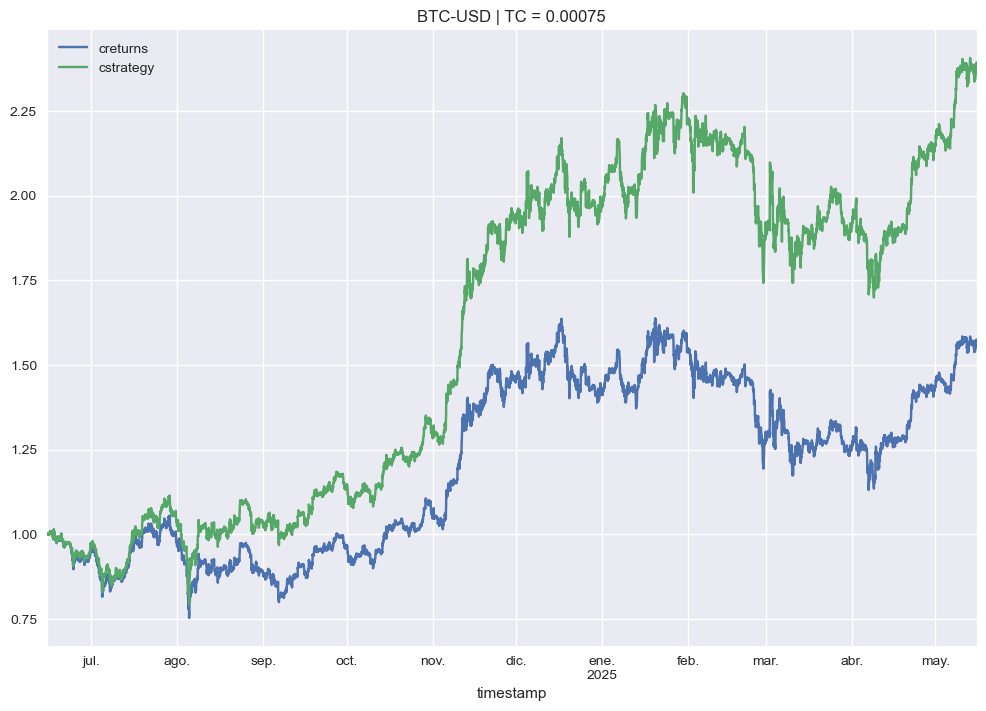

In [37]:
tester_price_vol.plot_results()

In [38]:
tester_price_vol.results

,close,volume,returns,vol_ch,position,strategy,trades,creturns,cstrategy
timestamp,,,,,,,,,
2024-06-15 00:00:00-06:00,66168.57,848.80651,NaN,NaN,1,NaN,0.0,NaN,NaN
2024-06-15 01:00:00-06:00,66076.99,1073.61193,-0.001385,0.234953,1,-0.001385,0.0,0.998616,0.998616
2024-06-15 02:00:00-06:00,66221.31,285.96083,0.002182,-1.322929,1,0.002182,0.0,1.000797,1.000797
2024-06-15 03:00:00-06:00,66227.00,339.29279,0.000086,0.171009,1,0.000086,0.0,1.000883,1.000883
2024-06-15 04:00:00-06:00,66300.01,361.43381,0.001102,0.063216,1,0.001102,0.0,1.001986,1.001986
...,...,...,...,...,...,...,...,...,...
2025-05-15 19:00:00-06:00,104047.61,842.64231,0.002722,0.045023,1,0.002722,0.0,1.572463,2.389180
2025-05-15 20:00:00-06:00,104199.80,1102.45583,0.001462,0.268753,1,0.001462,0.0,1.574763,2.392675
2025-05-15 21:00:00-06:00,104023.49,543.50598,-0.001693,-0.707255,1,-0.001693,0.0,1.572098,2.388626
